### imports, directories, load data

In [1]:
import sys
sys.path.append('../')  

In [2]:
# custom imports
from general_utils import get_transient_timestamps_mod, calculate_auROC, significant_modulation_proportion, generate_labels_from_cv_filtered, calculate_auROC_with_permutation
import assemblies
from assemblies import *

# general imports
import numpy as np
import pdb
import pickle
import pandas as pd
import sys
import os
import copy
import cv2
import random
import csv

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# stats imports
import math as math
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel, wilcoxon, mannwhitneyu, chi2_contingency, fisher_exact, sem
from statsmodels.formula.api import mixedlm, ols
from scipy.spatial.distance import euclidean, pdist, squareform, mahalanobis
from statsmodels.regression.mixed_linear_model import MixedLM

In [3]:
figDataSaveDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data"
dryadDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc/dryad"

In [4]:
saveDir_data = 'C:/code/miniscope-analysis-mek/InterneuronInhibNAc/InterneuronInhibNAc/dryad'
file_path = os.path.join(dryadDir, 'population_encoding_data.pkl')

with open(file_path, 'rb') as f:
    loaded_variables = pickle.load(f)
return loaded_variables

# Load all variables
loaded_variables = load_all_variables()

# Access all variables directly as before
data_groups_d2 = loaded_variables["data_groups_d2"]
data_groups_d01 = loaded_variables["data_groups_d01"]
day0_1_auROCs = loaded_variables["day0_1_auROCs"]
day2_14_auROCs_partner = loaded_variables["day2_14_auROCs_partner"]
day2_14_auROCs_novel = loaded_variables["day2_14_auROCs_novel"]

assembly_results_partner_day0 = loaded_variables["assembly_results_partner_day0"]
assembly_results_partner_day1 = loaded_variables["assembly_results_partner_day1"]
assembly_results_partner_day2 = loaded_variables["assembly_results_partner_day2"]
assembly_results_nonsocial_day2 = loaded_variables["assembly_results_nonsocial_day2"]
assembly_results_partner_day14 = loaded_variables["assembly_results_partner_day14"]
assembly_results_novel_day2 = loaded_variables["assembly_results_novel_day2"]
assemblies_data_day0 = loaded_variables["assemblies_data_day0"]
assemblies_data_day1 = loaded_variables["assemblies_data_day1"]
assemblies_data_day2 = loaded_variables["assemblies_data_day2"]
assemblies_data_day14 = loaded_variables["assemblies_data_day14"]

print('All variables loaded successfully')

All variables loaded successfully


In [5]:
def smooth_data(C_final, smooth_length=5, sampling_rate=15):
    window_length = int(smooth_length * sampling_rate)
    if window_length % 2 == 0:
        window_length += 1  # Ensure the window length is odd
    smoothed_data = np.apply_along_axis(
        lambda m: np.convolve(m, np.ones(window_length) / window_length, mode='same'), axis=1, arr=C_final
    )
    return smoothed_data
    
def generate_labels_from_cv(cv, total_frames, behavior_label, event_type=None):
    labels = np.zeros(total_frames, dtype=int)
    if event_type is None:
        for _, row in cv.iterrows():
            if row['EventType'] == behavior_label:
                start = int(row['scopeFrameStart'] / 2)  # Adjust for downsampling
                end = int(row['scopeFrameEnd'] / 2)
                labels[start:end] = 1
    else:
        for _, row in cv.iterrows():
            if row['EventType'] in event_type:
                start = int(row['scopeFrameStart'] / 2)  # Adjust for downsampling
                end = int(row['scopeFrameEnd'] / 2)
                labels[start:end] = 1
    return labels

In [6]:
def generate_event_vectors(cv, C_final, behavior_label, event_type=None, shift_amount=0, return_individual_vectors=False, first_3sec_only=False):
    vectors = []
    event_bounds = []
    total_frames = C_final.shape[1]
    
    frames_per_second = 15  
    frames_3sec = 3 * frames_per_second
    
    if shift_amount != 0:
        cv = cv.copy()
        cv['scopeFrameStart'] = np.roll(cv['scopeFrameStart'], shift_amount)
        cv['scopeFrameEnd'] = np.roll(cv['scopeFrameEnd'], shift_amount)
    
    for _, row in cv.iterrows():
        if event_type is None:
            condition = row['EventType'] == behavior_label
        else:
            condition = row['EventType'] in event_type
        
        if condition:
            start = int(row['scopeFrameStart'] / 2)
            end = int(row['scopeFrameEnd'] / 2)
            
            if 0 <= start < end <= total_frames:
                if first_3sec_only:
                    if (end - start) >= frames_3sec:
                        end = start + frames_3sec
                    else:
                        continue
                
                if return_individual_vectors:
                    event_vectors = C_final[:, start:end].T
                    if event_vectors.size > 0:  # Check if the array is not empty
                        vectors.extend(event_vectors)
                else:
                    event_vector = np.nanmean(C_final[:, start:end], axis=1)
                    if not np.isnan(event_vector).all() and event_vector.size > 0:
                        vectors.append(event_vector)
                event_bounds.append((start, end))
    
    if len(vectors) == 0:
        return np.array([]), []  # Return empty array and empty list if no vectors

    if return_individual_vectors:
        return np.array(vectors)
    else:
        return np.array(vectors), event_bounds

### neuron counts

In [7]:
def plot_neuron_count_violin(data_groups_d2, save_dir=None, filename=None, title_in=None, y_label=None):
    """
    Plot the number of neurons in control vs. experimental groups as a split violin plot and perform a t-test.

    Parameters:
    - data_groups_d2: dict, input data containing C_final matrices
    - save_dir: str, directory to save the plots and data
    - filename: str, filename to save the plots and data
    - title_in: str, title of the plot
    - y_label: str, label for the y-axis
    """
    ctrl_counts = []
    expt_counts = []

    # Extract number of neurons for each animal
    for group, counts in zip(['control', 'expt'], [ctrl_counts, expt_counts]):
        for animal_id, animal_data in data_groups_d2[group].items():
            if 'day2' in animal_data:
                C_final = animal_data['day2']['C_final']
                num_neurons = C_final.shape[0]
                counts.append(num_neurons)

    # Calculate means and standard errors
    ctrl_mean = np.mean(ctrl_counts)
    ctrl_sem = np.std(ctrl_counts) / np.sqrt(len(ctrl_counts))
    expt_mean = np.mean(expt_counts)
    expt_sem = np.std(expt_counts) / np.sqrt(len(expt_counts))

    # Combine all animals for overall statistics
    all_counts = ctrl_counts + expt_counts
    all_mean = np.mean(all_counts)
    all_sem = np.std(all_counts) / np.sqrt(len(all_counts))

    # Report group-specific and overall statistics
    print(f"Control: Mean = {ctrl_mean:.2f}, SEM = {ctrl_sem:.2f}")
    print(f"Experimental: Mean = {expt_mean:.2f}, SEM = {expt_sem:.2f}")
    print(f"All Animals: Mean = {all_mean:.2f}, SEM = {all_sem:.2f}")

    # Perform t-test
    t_stat, p_value = ttest_ind(ctrl_counts, expt_counts, equal_var=False)
    print(f"T-test results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

    # Save data as CSV if required
    if save_dir and filename:
        data_csv = {
            'Group': ['Control'] * len(ctrl_counts) + ['Experimental'] * len(expt_counts),
            'Neuron Count': ctrl_counts + expt_counts
        }
        df_csv = pd.DataFrame(data_csv)
        csv_path = os.path.join(save_dir, filename + '_data.csv')
        df_csv.to_csv(csv_path, index=False)
        print(f"Data saved as {csv_path}")

    # Define colors
    colors = {'Control': '#048BA8', 'Experimental': '#D31F30'}

    # Prepare data for split violin plot
    data = ctrl_counts + expt_counts
    groups = ['Control'] * len(ctrl_counts) + ['Experimental'] * len(expt_counts)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=groups, y=data, split=True, inner=None, palette=colors, scale='width')
    
    # Overlay means and standard errors as points with error bars
    plt.errorbar(0, ctrl_mean, yerr=ctrl_sem, fmt='o', color='black', capsize=5)
    plt.errorbar(1, expt_mean, yerr=expt_sem, fmt='o', color='black', capsize=5)

    plt.xticks([0, 1], ['Control', 'Experimental'])
    plt.ylabel(y_label if y_label else 'Neuron Count')
    plt.title(title_in if title_in else 'Neuron Count in Control vs. Experimental Groups')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save plot if required
    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        print(f"Plot saved as {save_path_svg} and {save_path_png}")

    plt.show()

    # Return results for further analysis
    return {
        'control': {'mean': ctrl_mean, 'sem': ctrl_sem, 'counts': ctrl_counts},
        'experimental': {'mean': expt_mean, 'sem': expt_sem, 'counts': expt_counts},
        'all': {'mean': all_mean, 'sem': all_sem, 'counts': all_counts},
        't_test': {'t_statistic': t_stat, 'p_value': p_value}
    }



Control: Mean = 55.12, SEM = 4.30
Experimental: Mean = 43.14, SEM = 7.00
All Animals: Mean = 49.53, SEM = 4.28
T-test results: t-statistic = 1.355, p-value = 2.050e-01
Data saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\total_neuron_count_data.csv
Plot saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\total_neuron_count.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\total_neuron_count.png


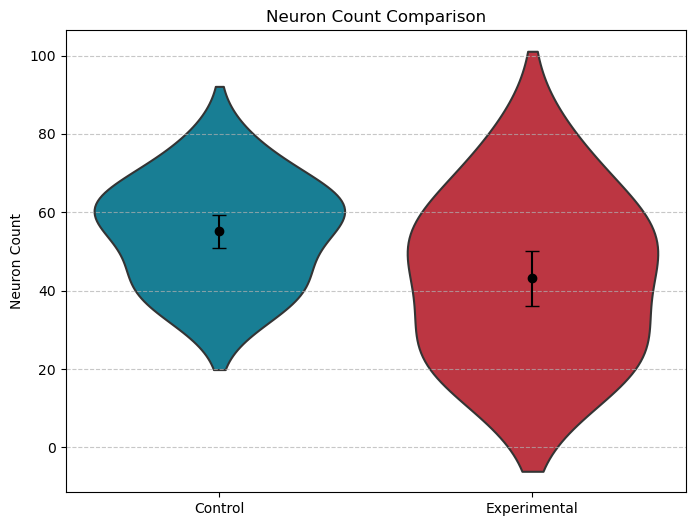

In [8]:
results = plot_neuron_count_violin(data_groups_d2, save_dir=figDataSaveDir + '/imagingInhib_cells_supp', filename='total_neuron_count', title_in='Neuron Count Comparison', y_label='Neuron Count')


### ensembles

In [9]:
example_matrix = data_groups_d01['control']['animal1']['day0']['C_final']
example_matrix.shape

(56, 53613)

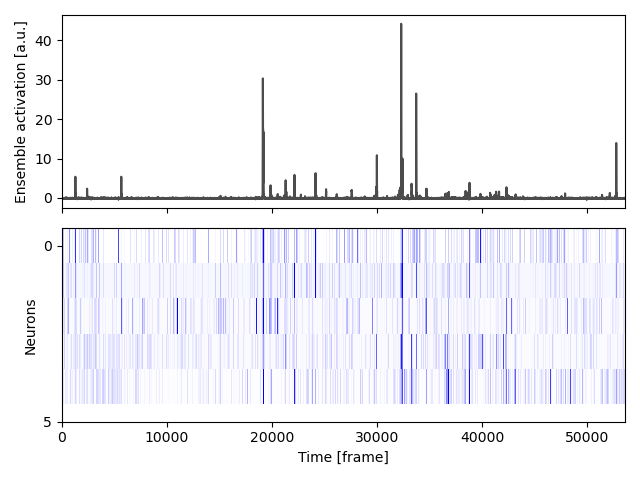

Patterns shape: (15, 56)
Number of assemblies: 15


In [10]:
%matplotlib widget
assembly_dict, fig, axs = find_assemblies(
    example_matrix, 
    method='ica', 
    nullhyp='mp', 
    n_shuffles=1000, 
    percentile=99, 
    tracywidow=False, 
    compute_activity=True, 
    use_bool=False, 
    plot=True, 
    plot_each_pattern=True,
    save_single_pattern=True,
    which_pattern_toSave = 9,
    save_dir = figDataSaveDir + '/imagingInhib_population_supp',
    filename='assembly_example_4'
)

# Check the returned dictionary
print("Patterns shape:", assembly_dict['patterns'].shape)
print("Number of assemblies:", assembly_dict['significance'].nassemblies)


    
    
    

In [11]:
def extract_assemblies(data_groups, whichDays='day2', method='ica', nullhyp = 'mp'):
    assemblies_data = {'control': {}, 'expt': {}}
    print('beginning to extract assemblies')
    for group in ['control', 'expt']:
        for animal_id, animal_data in data_groups[group].items():
            if whichDays in animal_data:
                C_final = animal_data[whichDays]['C_final']
                cv = animal_data[whichDays]['cv']  # Include cv data

                # Safely get partner_side, defaulting to None if it doesn't exist
                partner_side = animal_data[whichDays].get('partner_side', None)
                
                assembly_dict, _, _ = find_assemblies(
                    C_final, 
                    method=method, 
                    nullhyp=nullhyp, 
                    n_shuffles=1000, 
                    percentile=99, 
                    tracywidow=False, 
                    compute_activity=True, 
                    use_bool=False, 
                    plot=False, 
                    plot_each_pattern=False
                )
                if assembly_dict is None:
                    assemblies_data[group][animal_id] = 'none'
                    print(f"Group: {group}, Animal: {animal_id} - Skipping due to empty actmat.")
                    continue
                
                # Extract the number of assemblies and number of neurons
                num_assemblies = assembly_dict['significance'].nassemblies
                num_neurons = C_final.shape[0]
                
                # Include activation timeseries and cv data
                activations = assembly_dict['activations']
                important_neurons = assembly_dict['patterns']
                assemblies_data[group][animal_id] = {
                    whichDays: {
                        'num_assemblies': num_assemblies,
                        'num_neurons': num_neurons,
                        'activations': activations,
                        'cv': cv,
                        'important_neurons': important_neurons, # this is an array with the weight for each neuron
                        'partner_side': partner_side  # Add partner_side information
                    }
                }
                

    return assemblies_data



def plot_assemblies_count(assemblies_data, whichDays='day2', save_dir=None, filename=None, title_in=None, x_label=None, y_label=None, jitter_strength=0.03):
    """
    Plot normalized number of assemblies in control vs. experimental groups and perform a t-test.

    Parameters:
    - assemblies_data: dict, output from extract_assemblies function
    - whichDays: str, day to analyze (e.g., 'day2')
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots
    - title_in: str, title of the plot
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis
    """
    ctrl_counts = []
    expt_counts = []

    for animal_id, data in assemblies_data['control'].items():
        if whichDays in data:
            num_assemblies = data[whichDays]['num_assemblies']
            num_neurons = data[whichDays]['num_neurons']
            ctrl_counts.append(num_assemblies / num_neurons)

    for animal_id, data in assemblies_data['expt'].items():
        if whichDays in data and animal_id not in ['6679', '5789']:
            num_assemblies = data[whichDays]['num_assemblies']
            num_neurons = data[whichDays]['num_neurons']
            expt_counts.append(num_assemblies / num_neurons)

    # Calculate means and standard errors
    ctrl_mean = np.mean(ctrl_counts)
    ctrl_sem = stats.sem(ctrl_counts)
    expt_mean = np.mean(expt_counts)
    expt_sem = stats.sem(expt_counts)

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(ctrl_counts, expt_counts, equal_var = False)

    # Print t-test results
    print(f"T-test results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

    # Define colors
    colors = {'control': '#048BA8', 'expt': '#D31F30'}

    # Plotting
    plt.figure()
    


    ctrl_jitter = np.random.normal(0, jitter_strength, len(ctrl_counts))
    expt_jitter = np.random.normal(0, jitter_strength, len(expt_counts))

    plt.scatter(np.full(len(ctrl_counts), 1) + ctrl_jitter, ctrl_counts, color=colors['control'], label='Control')
    plt.scatter(np.full(len(expt_counts), 2) + expt_jitter, expt_counts, color=colors['expt'], label='Experimental')
    
    # Plot mean and standard error
    plt.errorbar(1, ctrl_mean, yerr=ctrl_sem, fmt='', color='black', capsize=0)
    plt.errorbar(2, expt_mean, yerr=expt_sem, fmt='', color='black', capsize=0)

    plt.xlim(0.5,2.5)
    plt.xticks([1, 2], ['Control', 'Experimental'])
    plt.ylabel(y_label if y_label else 'Normalized Number of Assemblies')
    plt.title(title_in if title_in else 'Normalized Number of Assemblies in Control vs. Experimental Groups')
    plt.legend()

    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
    
    plt.show()


def assembly_prediction_PPTs(assemblies_data, days=['day2', 'day14'], context='partner', eventType='chamber'):
    results = {'control': {}, 'expt': {}}
    print('beginning prediction')
    for group_name, group_data in assemblies_data.items():
        for animal_id, sessions in group_data.items():
            results[group_name][animal_id] = {}
            for day in days:
                try:
                    # Attempt to retrieve session data
                    session_data = sessions.get(day)
                except AttributeError as e:
                    print(f"Cant find this session in {group_name}, {animal_id}, {day}: {e}")
                    continue
                    
                if session_data and 'activations' in session_data and 'cv' in session_data:
                    #pdb.set_trace()
                    activations = session_data['activations']
                    cv = session_data['cv']
                    num_assemblies = session_data['num_assemblies']
                    num_neurons = session_data['num_neurons']

                    # Get partner_side from session_data
                    partner_side = session_data.get('partner_side', None)
                    
                    # Replace NaNs in activations with zeros
                    if np.isnan(activations).any():
                        print(f"Replacing NaNs for {animal_id} on {day}")
                        activations = np.nan_to_num(activations)

                    # Determine the event type based on the day and context
                    if day in ['day0', 'day1']:
                        event_type = 'Distance between [ 2 and 1 ] Less Than  50.00 mm'
                    else:
                        side_info = partner_side.capitalize() if partner_side else ''
                        if side_info:
                            if context == 'partner':
                                event_type = f'Area:Mouse 1 Center In {side_info} chamber'
                            elif context == 'novel':
                                opposite_side = 'Right' if side_info == 'Left' else 'Left'
                                event_type = f'Area:Mouse 1 Center In {opposite_side} chamber'
                            elif context == 'nonsocial':
                                event_type = [
                                    f'Area:Mouse 1 Center In Center chamber'
                                ]

                    # Filter CV for specified EventType
                    if isinstance(event_type, list):
                        filtered_cv = cv[cv['EventType'].isin(event_type)]
                    else:
                        filtered_cv = cv[cv['EventType'] == event_type]

                    labels = generate_labels_from_cv_filtered(filtered_cv, activations.shape[1])

                    # Calculate auROC and determine significant modulation
                    prop_positive, prop_negative, pos_indices, neg_indices, auroc_values, p_values_list = significant_modulation_proportion(activations, labels,
                                                                                                    num_permutations=1000,
                                                                                                    seed=42)
                    prop_total = prop_positive + prop_negative

                    important_neurons = session_data['important_neurons']
                    
                    results[group_name][animal_id][day] = {
                        'positive': prop_positive,
                        'negative': prop_negative,
                        'total': prop_total,
                        'pos_indices': pos_indices,
                        'neg_indices': neg_indices,
                        'num_neurons': num_neurons, 
                        'important_neurons': important_neurons,
                        'auroc_values': auroc_values,
                        'p_values': p_values_list
                    }
                else:
                    print(f"Missing data for {animal_id} on {day}, skipping.")
                    
    return results

def plot_assembly_prediction_results(results, proportion_type='total', save_dir=None, filename=None, 
                              title_in=None, x_label=None, y_label=None):
    """
    Plot normalized proportions of control and experimental animals with bars, error bars, 
    and individual data points.

    Parameters:
    - results: dict, results from assembly_prediction_PPTs
    - proportion_type: str, type of proportion to plot ('total', 'positive', 'negative')
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots
    - title_in: str, title of the plot
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis
    """
    # Prepare data
    control_proportions = []
    expt_proportions = []
    csv_data = []

    # Extract data
    for group_name, group_data in results.items():
        for animal_id, animal_data in group_data.items():
            for day, data in animal_data.items():
                # Calculate count based on proportion type
                if proportion_type == 'total':
                    count = len(data['pos_indices']) + len(data['neg_indices'])
                elif proportion_type == 'positive':
                    count = len(data['pos_indices'])
                elif proportion_type == 'negative':
                    count = len(data['neg_indices'])
                else:
                    raise ValueError("proportion_type must be 'total', 'positive', or 'negative'")
                
                # Normalize by number of neurons
                normalized_count = count / data['num_neurons']
                
                # Store data
                if group_name == 'control':
                    control_proportions.append(normalized_count)
                    csv_data.append({'Group': 'Control', 'Animal': animal_id, 
                                   'Day': day, 'Normalized_Proportion': normalized_count})
                elif group_name == 'expt':
                    expt_proportions.append(normalized_count)
                    csv_data.append({'Group': 'Experimental', 'Animal': animal_id, 
                                   'Day': day, 'Normalized_Proportion': normalized_count})

    # Calculate statistics
    control_mean = np.nanmean(control_proportions)
    control_sem = stats.sem(control_proportions, nan_policy='omit')
    expt_mean = np.nanmean(expt_proportions)
    expt_sem = stats.sem(expt_proportions, nan_policy='omit')

    # Set colors
    colors = {'control': '#128CA8', 'expt': '#CC2028'}

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(top=False, right=False)
    
    # Plot bars
    width = 0.4
    bar_positions = [0, 1]
    ax.bar(bar_positions[0], control_mean, width, color=colors['control'], 
           edgecolor='black', zorder=2)
    ax.bar(bar_positions[1], expt_mean, width, color=colors['expt'], 
           edgecolor='black', zorder=2)

    # Add SEM lines
    for pos, mean, sem, data in [(bar_positions[0], control_mean, control_sem, control_proportions),
                                (bar_positions[1], expt_mean, expt_sem, expt_proportions)]:
        if sem > 0:
            ax.plot([pos, pos], [mean, mean + sem], color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean + sem, pos-0.05, pos+0.05, color='black', linewidth=1.5, zorder=3)
        
        # Add jittered black dots
        jitter = np.random.uniform(-width/3, width/3, size=len(data))
        ax.scatter(pos + jitter, data, color='black', s=64, zorder=3)

    # Set labels and title
    ax.set_ylabel(y_label if y_label else f'Normalized {proportion_type.capitalize()} Proportion of Assemblies')
    if title_in:
        ax.set_title(title_in)
        
    # Set x-axis
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(['Vehicle', 'IEM-1460'])
    
    # Set y-axis limits
    all_values = control_proportions + expt_proportions
    ax.set_ylim(0, max(all_values) * 1.2)

    # Save results
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, filename + '.svg'), format='svg', bbox_inches='tight')
        plt.savefig(os.path.join(save_dir, filename + '.png'), format='png', bbox_inches='tight')
        
        # Save CSV with data points
        csv_path = os.path.join(save_dir, filename + '_data.csv')
        pd.DataFrame(csv_data).to_csv(csv_path, index=False)

    # Print statistics
    n_control = len(control_proportions)
    n_expt = len(expt_proportions)
    t_stat, p_value = stats.ttest_ind(control_proportions, expt_proportions, equal_var=False, nan_policy='omit')
    
    print(f"\nStatistical Results:")
    print(f"Control: n={n_control}, mean={control_mean:.2f}, SEM={control_sem:.2f}")
    print(f"IEM-1460: n={n_expt}, mean={expt_mean:.2f}, SEM={expt_sem:.2f}")
    print(f"t({n_control + n_expt - 2}) = {t_stat:.2f}, p = {p_value:.3f}")
    
    plt.show()




In [12]:
assemblies_data_day0 = extract_assemblies(data_groups_d01, whichDays = 'day0')
assemblies_data_day1 = extract_assemblies(data_groups_d01, whichDays = 'day1')

beginning to extract assemblies
beginning to extract assemblies


C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\population\..\assemblies.py:195: UserWarning: Silent neurons detected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
  warnings.warn(f'Silent neurons detected: '


actmat_didspike is empty after removing silent neurons. Skipping assembly detection.
Group: expt, Animal: animal6 - Skipping due to empty actmat.


In [13]:
assemblies_data_day2 = extract_assemblies(data_groups_d2, whichDays = 'day2')

beginning to extract assemblies


In [14]:
assemblies_data_day14 = extract_assemblies(data_groups_d2, whichDays = 'day14')

beginning to extract assemblies


C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\population\..\assemblies.py:195: UserWarning: Silent neurons detected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
  warnings.warn(f'Silent neurons detected: '


actmat_didspike is empty after removing silent neurons. Skipping assembly detection.
Group: control, Animal: animal6 - Skipping due to empty actmat.


T-test results: t-statistic = -0.810, p-value = 4.359e-01


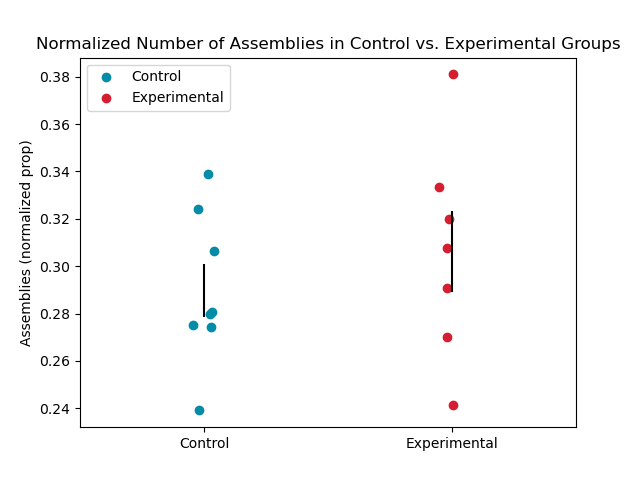

In [15]:
plot_assemblies_count(assemblies_data_day2, whichDays = 'day2', save_dir=figDataSaveDir + '/imagingInhib_population_supp', filename='assembly_total_day2', title_in=None, y_label='Assemblies (normalized prop)', x_label=None, jitter_strength = 0.03)

In [16]:
assembly_results_partner_day0 = assembly_prediction_PPTs(assemblies_data_day0, days=['day0'])

beginning prediction


In [17]:
assembly_results_partner_day1 = assembly_prediction_PPTs(assemblies_data_day1, days=['day1'])

beginning prediction
Cant find this session in expt, animal6, day1: 'str' object has no attribute 'get'


In [18]:
assembly_results_partner_day2 = assembly_prediction_PPTs(assemblies_data_day2, days=['day2'])


beginning prediction


In [19]:
assembly_results_novel_day2 = assembly_prediction_PPTs(assemblies_data_day2,  days=['day2'], context='novel')

beginning prediction


In [20]:
assembly_results_partner_day14 = assembly_prediction_PPTs(assemblies_data_day14, days=['day14'])


beginning prediction
Cant find this session in control, animal6, day14: 'str' object has no attribute 'get'


### ensemble v neurons example

In [21]:
def calculate_auROC_assemblies(trace, partner_periods):
    """Calculate auROC for a trace comparing partner vs non-partner periods"""
    partner_activity = trace[partner_periods == 1]
    nonpartner_activity = trace[partner_periods == 0]
    
    if len(partner_activity) == 0 or len(nonpartner_activity) == 0:
        return np.nan
        
    n1 = len(partner_activity)
    n2 = len(nonpartner_activity)
    r = stats.rankdata(np.concatenate([partner_activity, nonpartner_activity]))
    r1 = np.sum(r[:n1])
    
    # Calculate U statistic and convert to auROC
    u1 = r1 - (n1 * (n1 + 1)) / 2
    auroc = u1 / (n1 * n2)
    
    return auroc
    
def visualize_assembly_detail(assemblies_data, data_groups, assembly_idx=6, t_start=9500, t_end=10800, 
                            group='control', animal_id='animal1', day='day2',
                            figDataSaveDir=None, filename=None):
    # Previous data extraction code stays the same
    animal_data = assemblies_data[group][animal_id][day]
    orig_data = data_groups[group][animal_id][day]
    
    activations = animal_data['activations']
    neural_data = orig_data['C_final']
    cv_data = animal_data['cv']
    partner_side = animal_data['partner_side']
    important_neurons = animal_data['important_neurons']
    
    # Get partner vector
    event_type = f'Area:Mouse 1 Center In {partner_side.capitalize()} chamber'
    partner_events = cv_data[cv_data['EventType'] == event_type]
    partner_vector = np.zeros(activations.shape[1])
    # Fixed code
    for _, event in partner_events.iterrows():
        start_idx = event['scopeFrameStart'] // 2  # Integer division by 2
        end_idx = event['scopeFrameEnd'] // 2
        partner_vector[start_idx:end_idx] = 1
    
    # Get neurons
    weights = important_neurons[assembly_idx]
    threshold = np.mean(np.abs(weights)) + 2 * np.std(np.abs(weights))
    top_neurons = np.where(np.abs(weights) > threshold)[0][:3]
    
    # Create figure
    fig, axes = plt.subplots(1 + len(top_neurons), 1, figsize=(15, 12), sharex=True)
    
    # Time window
    time_slice = slice(t_start, t_end)
    time_array = np.arange(t_end - t_start)
    
    # Get partner periods for overlay
    partner_periods = partner_vector[time_slice]
    changes = np.diff(np.concatenate(([0], partner_periods, [0])))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    
    # Dictionary to store data for CSV
    data_dict = {}
    
    # Calculate auROC and store assembly data
    assembly_trace = activations[assembly_idx, time_slice]
    assembly_auroc = calculate_auROC_assemblies(assembly_trace, partner_periods)
    data_dict[f'Assembly_{assembly_idx}'] = assembly_trace
    
    # Plot assembly activation (top)
    axes[0].plot(time_array, assembly_trace, 'k', linewidth=1)
    for start, end in zip(starts, ends):
        axes[0].axvspan(start, end, color='gray', alpha=0.2, linewidth=0)
    axes[0].set_ylabel('Assembly\nactivation')
    axes[0].set_title(f'Assembly {assembly_idx} (auROC: {assembly_auroc:.3f})')
    
    # Colors for neurons
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot each neuron and calculate its auROC
    for i, neuron_idx in enumerate(top_neurons):
        trace = neural_data[neuron_idx, time_slice]
        neuron_auroc = calculate_auROC_assemblies(trace, partner_periods)
        data_dict[f'Neuron_{neuron_idx}'] = trace
        
        axes[i+1].plot(time_array, trace, color=colors[i], linewidth=1)
        for start, end in zip(starts, ends):
            axes[i+1].axvspan(start, end, color='gray', alpha=0.2, linewidth=0)
        axes[i+1].set_ylabel(f'Neuron {neuron_idx}\nactivity')
        axes[i+1].set_title(f'Neuron {neuron_idx} (auROC: {neuron_auroc:.3f})')
    
    axes[-1].set_xlabel('Time (frames)')
    
    plt.suptitle(f'{animal_id} Assembly {assembly_idx} Detail')
    plt.tight_layout()
    
    # Add partner periods to data dictionary
    data_dict['Partner_Presence'] = partner_periods
    
    # Save if directory and filename provided
    if figDataSaveDir and filename:
        # Create directory if it doesn't exist
        os.makedirs(figDataSaveDir, exist_ok=True)
        
        # Save figure in multiple formats
        fig.savefig(os.path.join(figDataSaveDir, f"{filename}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(figDataSaveDir, f"{filename}.svg"), bbox_inches='tight')
        
        # Save data as CSV
        df = pd.DataFrame(data_dict)
        df.to_csv(os.path.join(figDataSaveDir, f"{filename}_data.csv"), index=False)
    
    return fig, axes
                                

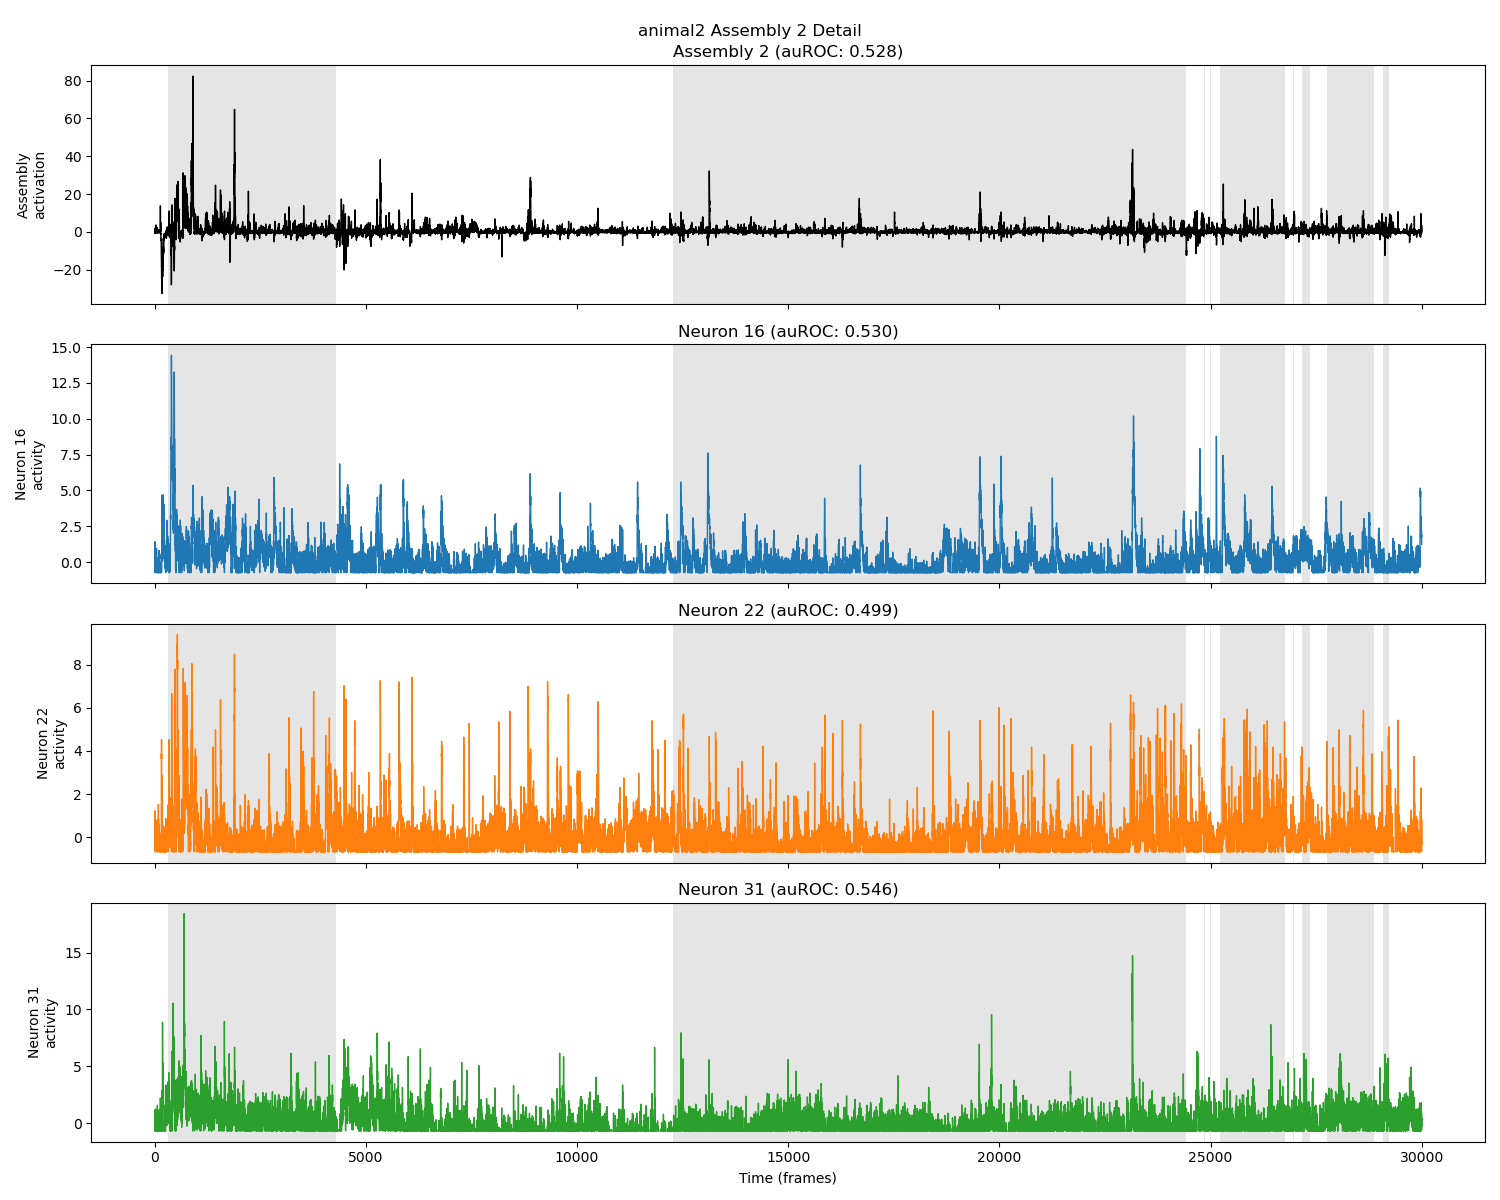

In [22]:
%matplotlib widget
fig, axes = visualize_assembly_detail(assemblies_data_day2, data_groups_d2, assembly_idx=2, t_start=0, t_end=30000, 
                            group='control', animal_id='animal2', day='day2', figDataSaveDir=figDataSaveDir + '/imagingInhib_population',
                                    filename='assembly_ensembleVNeuron_example_2')

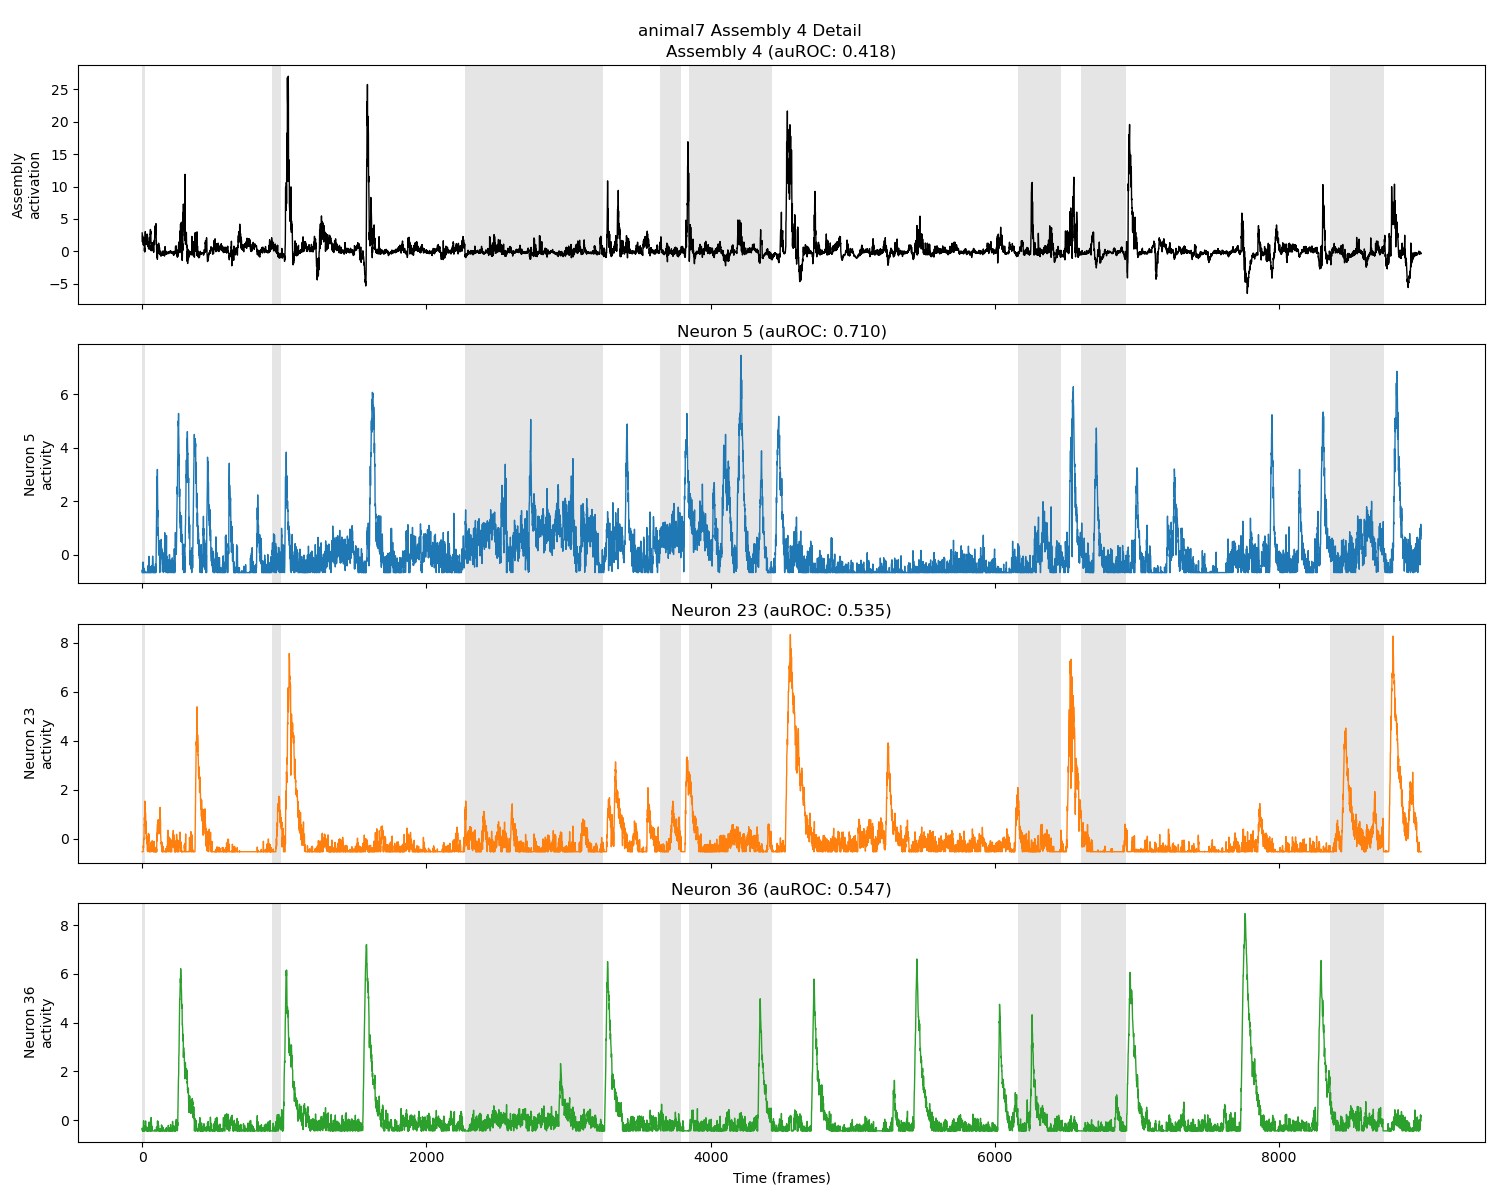

In [23]:
%matplotlib widget
fig, axes = visualize_assembly_detail(assemblies_data_day2, data_groups_d2, assembly_idx=4, t_start=13700, t_end=22700, 
                            group='control', animal_id='animal7', day='day2', figDataSaveDir=figDataSaveDir + '/imagingInhib_population',
                                    filename='assembly_ensembleVNeuron_example')

### splicing ensembles out

In [24]:
def visualize_assembly_comparison(assemblies_data, data_groups, assembly_idx=6, t_start=9500, t_end=10800,
                                group='control', animal_id='animal1', day='day2',
                                threshold_std=1.5, window_size=10, figDataSaveDir=None, filename=None):
    """
    Parameters:
    -----------
    window_size : int
        Number of samples to remove before and after each threshold crossing
    threshold_std : float
        Number of standard deviations above mean for threshold
    """
    # Extract data
    animal_data = assemblies_data[group][animal_id][day]
    orig_data = data_groups[group][animal_id][day]
    
    activations = animal_data['activations']
    neural_data = orig_data['C_final']
    cv_data = animal_data['cv']
    partner_side = animal_data['partner_side']
    important_neurons = animal_data['important_neurons']
    
    # Get partner vector
    event_type = f'Area:Mouse 1 Center In {partner_side.capitalize()} chamber'
    partner_events = cv_data[cv_data['EventType'] == event_type]
    partner_vector = np.zeros(activations.shape[1])
    for _, event in partner_events.iterrows():
        start_idx = event['scopeFrameStart'] // 2  # Divide by 2 to match imaging rate
        end_idx = event['scopeFrameEnd'] // 2
        partner_vector[start_idx:end_idx] = 1
    
    # Get neurons
    weights = important_neurons[assembly_idx]
    threshold = np.mean(np.abs(weights)) + 2 * np.std(np.abs(weights))
    top_neurons = np.where(np.abs(weights) > threshold)[0][:3]
    
    # Time window
    time_slice = slice(t_start, t_end)
    time_array = np.arange(t_end - t_start)
    partner_periods = partner_vector[time_slice]
    
    # Get assembly activation and threshold
    assembly_trace = activations[assembly_idx, time_slice]
    activation_threshold = np.mean(assembly_trace) + threshold_std * np.std(assembly_trace)
    
    # Get neuron traces
    neuron_traces = [neural_data[n_idx, time_slice] for n_idx in top_neurons]
    
    # Find periods of assembly activation using threshold crossings
    threshold_crossings = assembly_trace > activation_threshold
    
    # Create binary mask for segments to keep
    keep_mask = np.ones_like(assembly_trace, dtype=bool)
    
    # Find the start indices of threshold crossings
    crossing_starts = np.where(np.diff(threshold_crossings.astype(int)) == 1)[0]
    
    # For each threshold crossing, remove window_size samples before and after
    for crossing in crossing_starts:
        start_idx = max(0, crossing - window_size)
        end_idx = min(len(assembly_trace), crossing + window_size)
        keep_mask[start_idx:end_idx] = False
    
    # Create spliced traces by keeping only non-assembly timepoints
    assembly_spliced = assembly_trace[keep_mask]
    neuron_spliced = [trace[keep_mask] for trace in neuron_traces]
    
    # Create new time arrays
    original_time = np.arange(len(assembly_trace))
    spliced_time = np.arange(len(assembly_spliced))
    
    # Create partner periods for spliced data
    spliced_partner = partner_periods[keep_mask]
    
    # Create figure
    n_rows = 8  # 4 original + 4 spliced
    fig, axes = plt.subplots(n_rows, 1, figsize=(15, 20), sharex=False)
    
    # Colors for neurons
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot and store y-limits for original data (first 4 rows)
    ylims = []
    
    # Assembly
    axes[0].plot(original_time, assembly_trace, 'k', linewidth=1)
    axes[0].axhline(y=activation_threshold, color='r', linestyle='--', alpha=0.5)
    axes[0].set_ylabel('Assembly\nactivation')
    ylims.append(axes[0].get_ylim())
    
    # Add vertical bars for assembly activation periods to original plots
    removal_periods = ~keep_mask  # Periods that will be removed
    for i in range(len(original_time)):
        if removal_periods[i]:
            for ax in axes[:4]:  # Only for original plots
                ax.axvspan(i, i + 1, color='#E6E6FA', alpha=0.1)  # Light purple shading

    
    # Original Neurons
    for i, (trace, color) in enumerate(zip(neuron_traces, colors)):
        axes[i+1].plot(original_time, trace, color=color, linewidth=1)
        axes[i+1].set_ylabel(f'Neuron {top_neurons[i]}\nactivity')
        ylims.append(axes[i+1].get_ylim())
    
    # Spliced plots (bottom 4 rows)
    # Assembly
    axes[4].plot(spliced_time, assembly_spliced, 'k', linewidth=1)
    axes[4].set_ylabel('Assembly\nactivation')
    axes[4].set_ylim(ylims[0])  # Match assembly y-limits
    
    # Spliced Neurons
    for i, (trace, color) in enumerate(zip(neuron_spliced, colors)):
        axes[i+5].plot(spliced_time, trace, color=color, linewidth=1)
        axes[i+5].set_ylabel(f'Neuron {top_neurons[i]}\nactivity')
        axes[i+5].set_ylim(ylims[i+1])  # Match corresponding neuron y-limits
    
    # Add partner periods shading only to spliced plots
    changes = np.diff(np.concatenate(([0], spliced_partner, [0])))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    
    #for ax in axes[4:]:  # Only spliced plots
        #for start, end in zip(starts, ends):
            #ax.axvspan(start, end, color='gray', alpha=0.2, linewidth=0)
    
    # Add x-labels with different scales
    axes[3].set_xlabel('Original Time (frames)')
    axes[-1].set_xlabel('Spliced Time (frames)')
    
    plt.tight_layout()
    
    # Save if directory and filename provided
    if figDataSaveDir and filename:
        os.makedirs(figDataSaveDir, exist_ok=True)
        fig.savefig(os.path.join(figDataSaveDir, f"{filename}.png"), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(figDataSaveDir, f"{filename}.svg"), bbox_inches='tight')
    
    return fig, axes


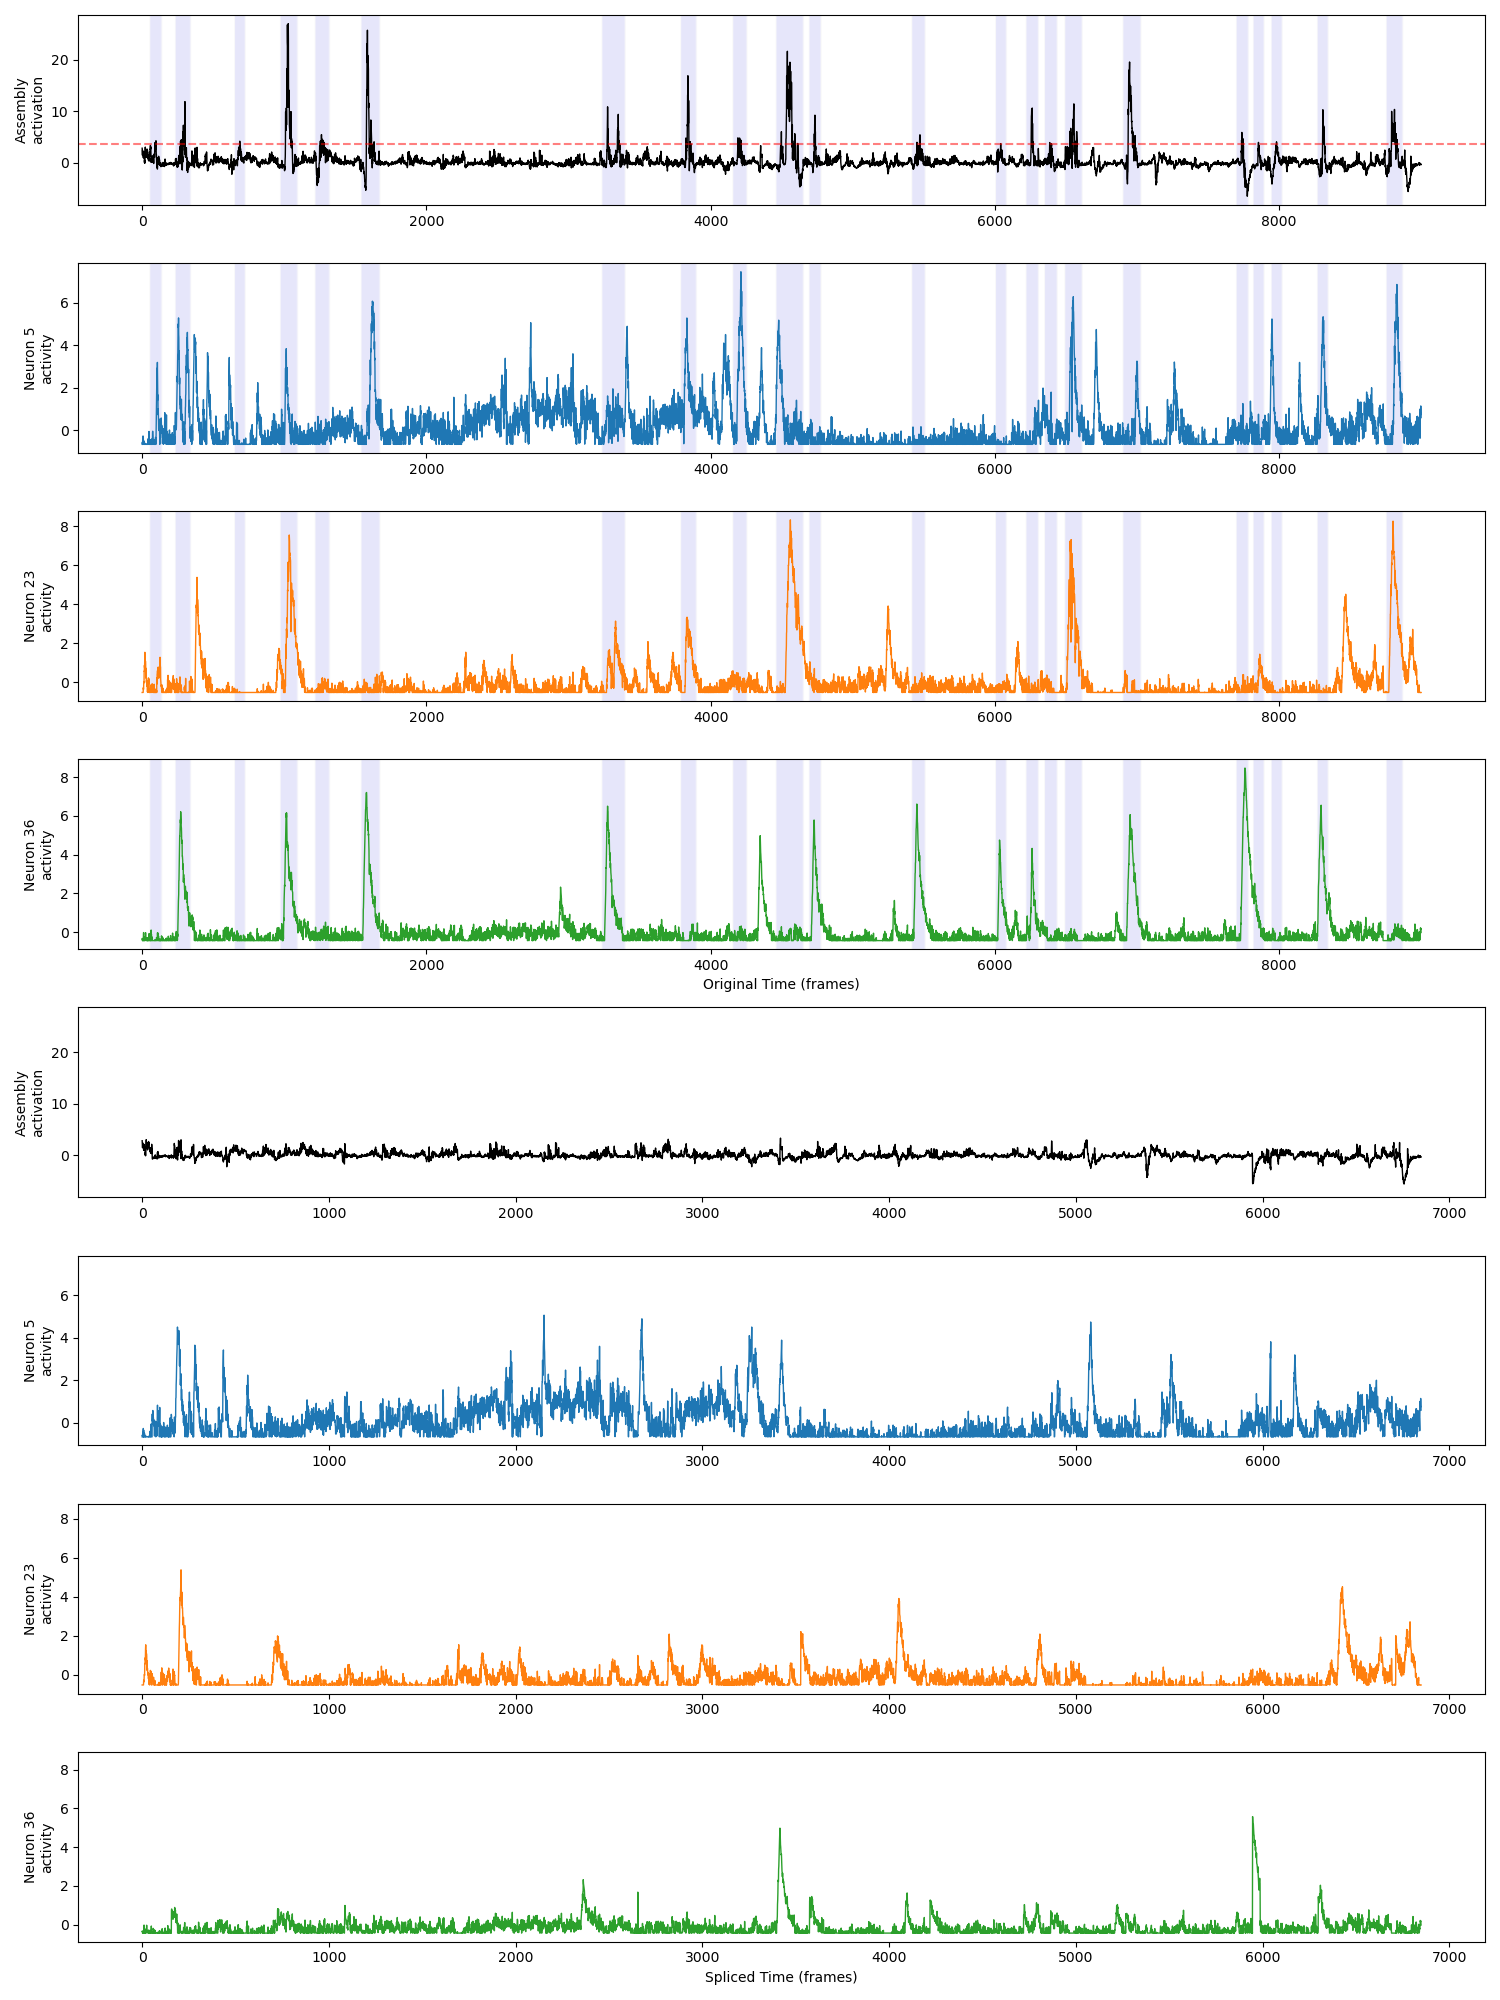

In [25]:
fig, axes = visualize_assembly_comparison(assemblies_data_day2, data_groups_d2, assembly_idx=4, t_start=13700, t_end=22700, 
                            group='control', animal_id='animal7', day='day2',  threshold_std=1.5, window_size = 35, figDataSaveDir=figDataSaveDir + '/imagingInhib_population_supp',
                                    filename='removingEnsembleEpochs_example')


In [70]:
def process_neuron_aurocs(data_groups, assemblies_data, threshold_std=1.5, window_size=30, 
                         animal_select=None):
    """
    Process auROCs specifically for neurons participating in ensembles
    
    Parameters:
    -----------
    data_groups : dict
        Nested dictionary containing experimental data for control and experimental groups
    assemblies_data : dict
        Nested dictionary containing ensemble data for control and experimental groups
    threshold_std : float, optional
        Standard deviation threshold for ensemble activation (default: 1.5)
    window_size : int, optional
        Window size around ensemble activation to remove (default: 30)
    animal_select : str, optional
        Specific animal to process (format: 'group_animal_id')
    
    Returns:
    --------
    dict
        Processed results with auROCs and ensemble participation details
    """
    results = {
        'control': {},
        'expt': {}
    }
    
    # Track ensemble participation statistics
    ensemble_participation_stats = {
        'control': {
            'total_neurons': 0,
            'ensemble_neurons': 0,
            'neurons_per_ensemble': [],
            'ensemble_count_distribution': {}
        },
        'expt': {
            'total_neurons': 0,
            'ensemble_neurons': 0,
            'neurons_per_ensemble': [],
            'ensemble_count_distribution': {}
        }
    }
    
    for group in ['control', 'expt']:
        for animal_id in data_groups[group]:
            try:
                # Skip if not the selected animal (when specified)
                if animal_select is not None:
                    select_group, select_animal = animal_select.split('_')
                    if group != select_group or animal_id != select_animal:
                        continue
                        
                if 'day2' in data_groups[group][animal_id]:
                    print(f"Processing {group} {animal_id}...")
                    
                    orig_data = data_groups[group][animal_id]['day2']
                    assemblies = assemblies_data[group][animal_id]['day2']
                    
                    neural_data = orig_data['C_final']
                    cv_data = orig_data['cv']
                    partner_side = orig_data['partner_side']
                    n_neurons = neural_data.shape[0]
                    
                    # Update total neurons
                    ensemble_stats = ensemble_participation_stats[group]
                    ensemble_stats['total_neurons'] += n_neurons
                    
                    # Process assemblies and neurons
                    activations = assemblies['activations']
                    important_neurons = assemblies['important_neurons']
                    n_assemblies = activations.shape[0]
                    
                    # Get neuron-assembly associations
                    neuron_assemblies = []
                    neurons_in_ensembles = []
                    for neuron_idx in range(n_neurons):
                        participating_assemblies = []
                        for assembly_idx in range(n_assemblies):
                            weights = important_neurons[assembly_idx]
                            threshold = np.mean(np.abs(weights)) + 2 * np.std(np.abs(weights))
                            if neuron_idx < len(weights) and np.abs(weights[neuron_idx]) > threshold:
                                participating_assemblies.append(assembly_idx)
                        
                        neuron_assemblies.append(participating_assemblies)
                        
                        # Track ensemble participation
                        if participating_assemblies:
                            neurons_in_ensembles.append(neuron_idx)
                            
                    # Update ensemble participation stats
                    ensemble_stats['ensemble_neurons'] += len(neurons_in_ensembles)
                    ensemble_stats['neurons_per_ensemble'].append(len(neurons_in_ensembles))
                    
                    # Compute ensemble participation distribution
                    neuron_ensemble_counts = [len(assemblies) for assemblies in neuron_assemblies]
                    for count in set(neuron_ensemble_counts):
                        ensemble_stats['ensemble_count_distribution'][count] = \
                            ensemble_stats['ensemble_count_distribution'].get(count, 0) + \
                            neuron_ensemble_counts.count(count)
                    
                    # Create neuron-specific removal masks (only for ensemble neurons)
                    neuron_keep_masks = []
                    original_aurocs = []
                    spliced_aurocs = []
                    
                    for neuron_idx in neurons_in_ensembles:
                        keep_mask = np.ones(neural_data.shape[1], dtype=bool)
                        
                        for assembly_idx in neuron_assemblies[neuron_idx]:
                            assembly_trace = activations[assembly_idx]
                            activation_threshold = np.mean(assembly_trace) + threshold_std * np.std(assembly_trace)
                            
                            threshold_crossings = assembly_trace > activation_threshold
                            crossing_starts = np.where(np.diff(threshold_crossings.astype(int)) == 1)[0]
                            
                            for crossing in crossing_starts:
                                start_idx = max(0, crossing - window_size)
                                end_idx = min(len(assembly_trace), crossing + window_size)
                                keep_mask[start_idx:end_idx] = False
                        
                        neuron_keep_masks.append(keep_mask)
                    
                    # Get partner vector
                    event_type = f'Area:Mouse 1 Center In {partner_side.capitalize()} chamber'
                    partner_events = cv_data[cv_data['EventType'] == event_type]
                    partner_vector = np.zeros(neural_data.shape[1])
                    for _, event in partner_events.iterrows():
                        start_idx = event['scopeFrameStart'] // 2
                        end_idx = event['scopeFrameEnd'] // 2
                        partner_vector[start_idx:end_idx] = 1
                    
                    # Calculate auROCs for ensemble neurons
                    for i, neuron_idx in enumerate(neurons_in_ensembles):
                        original_auroc = calculate_auROC_assemblies(neural_data[neuron_idx], partner_vector)
                        
                        neuron_trace_spliced = neural_data[neuron_idx][neuron_keep_masks[i]]
                        partner_vector_spliced = partner_vector[neuron_keep_masks[i]]
                        spliced_auroc = calculate_auROC_assemblies(neuron_trace_spliced, partner_vector_spliced)
                        
                        original_aurocs.append(original_auroc)
                        spliced_aurocs.append(spliced_auroc)
                    
                    # Store results
                    results[group][animal_id] = {
                        'original_aurocs': np.array(original_aurocs),
                        'spliced_aurocs': np.array(spliced_aurocs),
                        'ensemble_neurons': neurons_in_ensembles,
                        'neuron_assemblies': [neuron_assemblies[idx] for idx in neurons_in_ensembles],
                        'neuron_keep_masks': neuron_keep_masks
                    }
            
            except IndexError as e:
                print(f"\nIndexing error in {group} {animal_id}")
                print(f"Error occurred while processing neuron {neuron_idx} for assembly {assembly_idx}")
                print(f"Weights length: {len(weights)}, Attempted index: {neuron_idx}")
                print(f"Full error: {str(e)}\n")
                raise
    
    # Optionally print ensemble participation statistics
    for group in ['control', 'expt']:
        stats = ensemble_participation_stats[group]
        print(f"\n{group.capitalize()} Group Ensemble Participation:")
        print(f"Total Neurons: {stats['total_neurons']}")
        print(f"Neurons in Ensembles: {stats['ensemble_neurons']} ({stats['ensemble_neurons']/stats['total_neurons']*100:.2f}%)")
        print("Ensemble Participation Distribution:")
        for count, num_neurons in sorted(stats['ensemble_count_distribution'].items()):
            print(f"  Neurons in {count} ensembles: {num_neurons}")
    
    return results, ensemble_participation_stats

def plot_ensemble_participation_pie(stats, save_dir, filename_prefix, show_in_notebook=True):
    """
    Create pie charts showing ensemble participation distribution for all neurons,
    with separate legends and explicit handling of very small categories.
    
    Parameters:
    -----------
    stats : dict
        Ensemble participation statistics from `process_neuron_aurocs`.
    save_dir : str
        Directory to save the output files.
    filename_prefix : str
        Prefix for the filenames of the saved files.
    show_in_notebook : bool, optional
        Whether to display the plot inline in a Jupyter Notebook (default: True).
    
    Outputs:
    --------
    Saves pie charts (SVG and PNG) and a CSV with the percentages of neurons in each category.
    """

    os.makedirs(save_dir, exist_ok=True)
    
    colors_ctrl = ['#158CA8', '#5BBFD8', '#A0E4F4']
    colors_expt = ['#CD2029', '#F26C74', '#F7A1A6']
    csv_data = {'Group': [], 'Category': [], 'Percentage': []}
    
    for group, colors in zip(['control', 'expt'], [colors_ctrl, colors_expt]):
        group_stats = stats[group]
        total_neurons = group_stats['total_neurons']
        ensemble_neurons = group_stats['ensemble_neurons']
        
        # Calculate neurons in each category
        neurons_not_in_ensembles = total_neurons - ensemble_neurons
        neurons_in_1_ensemble = group_stats['ensemble_count_distribution'].get(1, 0)
        neurons_in_2_or_more = sum(v for k, v in group_stats['ensemble_count_distribution'].items() if k >= 2)
        
        # Debugging: Print calculations
        print(f"\n{group.capitalize()} Group:")
        print(f"  Total Neurons: {total_neurons}")
        print(f"  Neurons Not in Ensembles: {neurons_not_in_ensembles}")
        print(f"  Neurons in 1 Ensemble: {neurons_in_1_ensemble}")
        print(f"  Neurons in 2+ Ensembles: {neurons_in_2_or_more}")
        
        # Calculate percentages
        percentages = {
            'Not in Ensembles': (neurons_not_in_ensembles / total_neurons) * 100,
            'In 1 Ensemble': (neurons_in_1_ensemble / total_neurons) * 100,
            'In 2+ Ensembles': (neurons_in_2_or_more / total_neurons) * 100
        }
        
        # Debugging: Print percentages
        print(f"  Percentages: {percentages}")
        
        for category, percentage in percentages.items():
            csv_data['Group'].append(group.capitalize())
            csv_data['Category'].append(category)
            csv_data['Percentage'].append(percentage)
        
        # Create pie chart
        plt.figure(figsize=(8, 8))
        wedges, texts, autotexts = plt.pie(
            percentages.values(),
            startangle=90,
            colors=colors,
            autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
            pctdistance=0.85
        )
        plt.legend(
            wedges,
            percentages.keys(),
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            title=f"{group.capitalize()} Group"
        )
        plt.title(f"{group.capitalize()} Group Ensemble Participation")
        
        # Save plot
        plt.savefig(os.path.join(save_dir, f"{filename_prefix}_{group}_ensemble_pie.svg"), bbox_inches='tight')
        plt.savefig(os.path.join(save_dir, f"{filename_prefix}_{group}_ensemble_pie.png"), bbox_inches='tight')
        
        if show_in_notebook:
            plt.show()
    
    # Save CSV
    csv_path = os.path.join(save_dir, f"{filename_prefix}_ensemble_participation.csv")
    pd.DataFrame(csv_data).to_csv(csv_path, index=False)

def plot_neuron_auroc_percent_change(results, percent_change=10, 
                                     animal_select=None, save_dir=None, filename_prefix="proportions"):
    """
    Plot percent change in auROC for neurons after ensemble removal, comparing control and experimental groups.
    """
    if animal_select is not None:
        pass
    else:
        # Create single plot
        fig, ax = plt.subplots(figsize=(6, 6))

        # Colors for different categories
        increase_color = '#ff4b4b'  # Red
        decrease_color = '#4b4bff'  # Blue
        stable_color = '#808080'    # Gray

        # Store counts for statistical tests
        chi_square_data = {'control': {}, 'expt': {}}
        stats = {}
        x_positions = {'control': 0, 'expt': 0.5}
        neuron_data = []  # List to store individual neuron data for CSV

        for group_idx, group in enumerate(['control', 'expt']):
            all_original_aurocs = []
            all_spliced_aurocs = []

            for animal_id in results[group]:
                all_original_aurocs.extend(results[group][animal_id]['original_aurocs'])
                all_spliced_aurocs.extend(results[group][animal_id]['spliced_aurocs'])

            all_original_aurocs = np.array(all_original_aurocs)
            all_spliced_aurocs = np.array(all_spliced_aurocs)

            # Calculate percent change
            percent_changes = ((all_spliced_aurocs - all_original_aurocs) / all_original_aurocs) * 100

            # Categorize neurons
            increase_mask = percent_changes > percent_change
            decrease_mask = percent_changes < -percent_change
            stable_mask = np.abs(percent_changes) <= percent_change

            # Store counts for chi-square
            chi_square_data[group]['increase'] = np.sum(increase_mask)
            chi_square_data[group]['decrease'] = np.sum(decrease_mask)
            chi_square_data[group]['stable'] = np.sum(stable_mask)

            # Calculate percentages
            total_neurons = len(percent_changes)
            proportion_increase = (np.sum(increase_mask) / total_neurons) * 100
            proportion_decrease = (np.sum(decrease_mask) / total_neurons) * 100
            proportion_stable = (np.sum(stable_mask) / total_neurons) * 100
            
            stats[group] = {
                'increase': proportion_increase,
                'decrease': proportion_decrease,
                'stable': proportion_stable
            }

            # Add individual neuron data to CSV list
            for idx, change in enumerate(percent_changes):
                neuron_data.append({
                    'Group': group.capitalize(),
                    'Animal ID': animal_id,
                    'Original AUROC': all_original_aurocs[idx],
                    'Spliced AUROC': all_spliced_aurocs[idx],
                    'Percent Change': change,
                    'Category': 'Increase' if increase_mask[idx] else 
                                'Decrease' if decrease_mask[idx] else 'Stable'
                })

            # Add jitter to x positions
            x_jittered = np.random.normal(x_positions[group], 0.025, len(percent_changes))

            # Plot points
            for mask, color, label in [(increase_mask, increase_color, 'Increase'),
                                       (decrease_mask, decrease_color, 'Decrease'),
                                       (stable_mask, stable_color, 'Stable')]:
                if np.any(mask):
                    ax.scatter(x_jittered[mask], percent_changes[mask],
                               color=color, alpha=0.7, s=150,
                               label=label if group_idx == 0 else "")

        # Perform statistical tests
        contingency_table = [
            [chi_square_data['control']['increase'], chi_square_data['control']['decrease'], chi_square_data['control']['stable']],
            [chi_square_data['expt']['increase'], chi_square_data['expt']['decrease'], chi_square_data['expt']['stable']]
        ]
        chi2, p_chi2, dof, _ = chi2_contingency(contingency_table)
        
        fisher_table = [
            [chi_square_data['control']['increase'], chi_square_data['control']['decrease'] + chi_square_data['control']['stable']],
            [chi_square_data['expt']['increase'], chi_square_data['expt']['decrease'] + chi_square_data['expt']['stable']]
        ]
        odds_ratio, p_fisher = fisher_exact(fisher_table)

        # Print statistics and test results
        print("\nProportions:")
        for group in ['control', 'expt']:
            print(f"\n{group.capitalize()}:")
            print(f"Increase: {stats[group]['increase']:.1f}%")
            print(f"Decrease: {stats[group]['decrease']:.1f}%")
            print(f"Stable: {stats[group]['stable']:.1f}%")

        print(f"\nStatistical Tests:")
        print(f"Chi-square test: chi2 = {chi2:.3f}, df = {dof}, p-value = {p_chi2:.3e}")
        print(f"Fisher's exact test: p-value = {p_fisher:.3e}, odds_ratio = {odds_ratio:.3e}")

        # Formatting
        ax.set_xticks([0, 0.5])
        ax.set_xticklabels(['Control', 'IEM-1460'])
        ax.set_ylabel('% Change from Baseline')
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax.grid(False)

        # Add title with percentages
        title = (f"Control (↑:{stats['control']['increase']:.1f}% ↓:{stats['control']['decrease']:.1f}% =:{stats['control']['stable']:.1f}%)\n"
                 f"IEM-1460 (↑:{stats['expt']['increase']:.1f}% ↓:{stats['expt']['decrease']:.1f}% =:{stats['expt']['stable']:.1f}%)")
        ax.set_title(title)
        ax.legend()

        plt.tight_layout()

        # Save outputs if save_dir is provided
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

            # Save plot
            plt.savefig(os.path.join(save_dir, f'{filename_prefix}_auroc_changes.svg'))
            plt.savefig(os.path.join(save_dir, f'{filename_prefix}_auroc_changes.png'))
            
            # Save individual neuron data to CSV
            neuron_data_path = os.path.join(save_dir, f'{filename_prefix}_neuron_data.csv')
            pd.DataFrame(neuron_data).to_csv(neuron_data_path, index=False)
            print(f"Neuron data saved to {neuron_data_path}")

        plt.show()

        return {
            'chi2': {'statistic': chi2, 'p_value': p_chi2},
            'fisher': {'odds_ratio': odds_ratio, 'p_value': p_fisher}
        }



In [27]:
# Process either all animals or just one
results, ensemble_stats = process_neuron_aurocs(data_groups_d2, assemblies_data_day2, 
                              threshold_std=2, window_size=35,
                              animal_select=None)  # or None for all



Processing control animal1...
Processing control animal2...
Processing control animal3...
Processing control animal4...
Processing control animal5...
Processing control animal6...
Processing control animal7...
Processing control animal8...
Processing expt animal1...
Processing expt animal2...
Processing expt animal3...
Processing expt animal4...
Processing expt animal5...
Processing expt animal6...
Processing expt animal7...

Control Group Ensemble Participation:
Total Neurons: 441
Neurons in Ensembles: 343 (77.78%)
Ensemble Participation Distribution:
  Neurons in 0 ensembles: 98
  Neurons in 1 ensembles: 304
  Neurons in 2 ensembles: 39

Expt Group Ensemble Participation:
Total Neurons: 302
Neurons in Ensembles: 225 (74.50%)
Ensemble Participation Distribution:
  Neurons in 0 ensembles: 77
  Neurons in 1 ensembles: 204
  Neurons in 2 ensembles: 21



Control Group:
  Total Neurons: 441
  Neurons Not in Ensembles: 98
  Neurons in 1 Ensemble: 304
  Neurons in 2+ Ensembles: 39
  Percentages: {'Not in Ensembles': 22.22222222222222, 'In 1 Ensemble': 68.93424036281179, 'In 2+ Ensembles': 8.843537414965986}


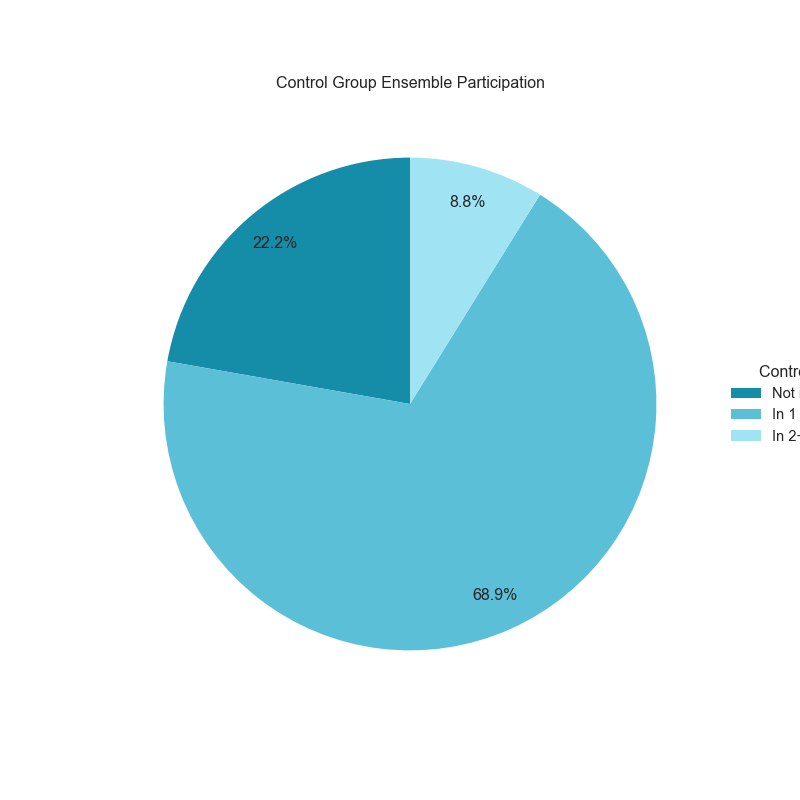


Expt Group:
  Total Neurons: 302
  Neurons Not in Ensembles: 77
  Neurons in 1 Ensemble: 204
  Neurons in 2+ Ensembles: 21
  Percentages: {'Not in Ensembles': 25.496688741721858, 'In 1 Ensemble': 67.54966887417218, 'In 2+ Ensembles': 6.95364238410596}


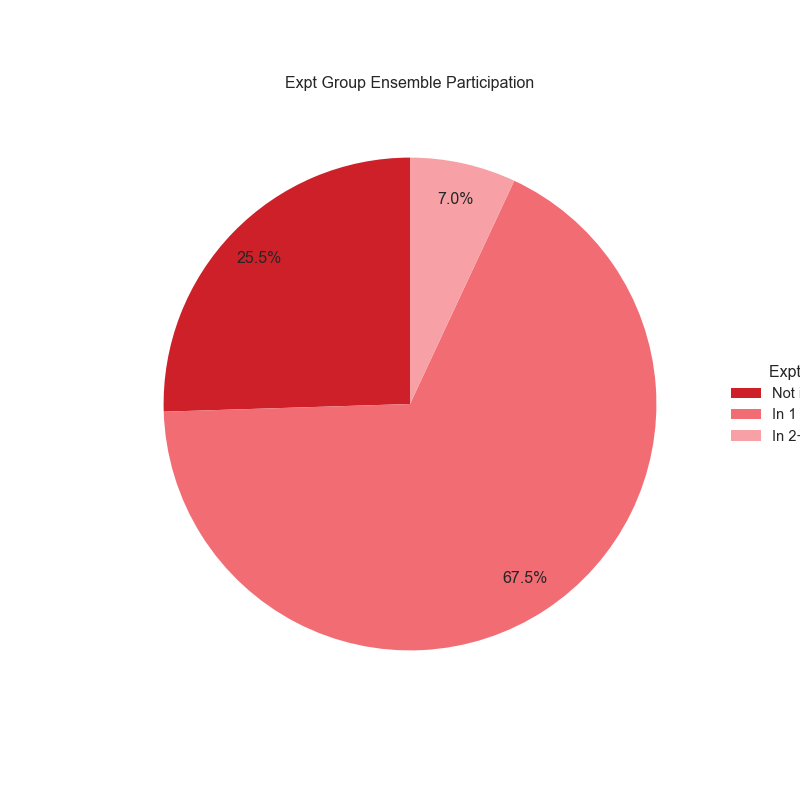

In [71]:
plot_ensemble_participation_pie(ensemble_stats, save_dir=figDataSaveDir + '/imagingInhib_population_supp',
                                filename_prefix = 'piechart_neuronsInEnsembles')


Proportions:

Control:
Increase: 13.4%
Decrease: 4.4%
Stable: 82.2%

Expt:
Increase: 7.6%
Decrease: 6.7%
Stable: 85.8%

Statistical Tests:
Chi-square test: chi2 = 5.759, df = 2, p-value = 5.615e-02
Fisher's exact test: p-value = 2.963e-02, odds_ratio = 1.895e+00
Neuron data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population_supp\aurocChange_prePostEnsembles_neuron_data.csv


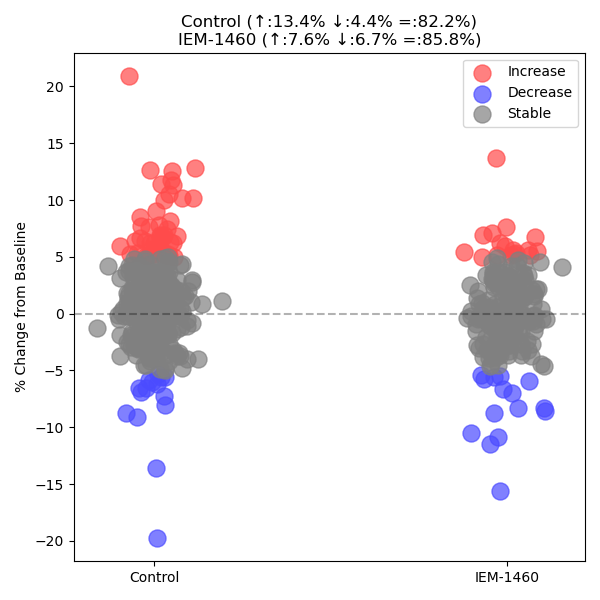

In [29]:
# Plot the results
fig, ax = plot_neuron_auroc_percent_change(results, percent_change = 5,
                                      save_dir=figDataSaveDir + '/imagingInhib_population_supp',
                                      filename_prefix='aurocChange_prePostEnsembles')

### saving & plotting

In [73]:
# Define the results to be saved
results_to_save = {
    'assembly_results_partner_day0': assembly_results_partner_day0,
    'assembly_results_partner_day1': assembly_results_partner_day1,
    'assembly_results_partner_day2': assembly_results_partner_day2,
    'assembly_results_partner_day14': assembly_results_partner_day14,
    'assembly_results_novel_day2': assembly_results_novel_day2,
    'assembly_results_nonsocial_day2': assembly_results_nonsocial_day2,
    'assemblies_data_day0': assemblies_data_day0,
    'assemblies_data_day1': assemblies_data_day1,
    'assemblies_data_day2': assemblies_data_day2,
    'assemblies_data_day14': assemblies_data_day14
}

save_path = figDataSaveDir + '/populationEncoding_012325.pkl'

# Save the results to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(results_to_save, f)

print(f'Results saved to {save_path}')

Results saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/populationEncoding_012325.pkl



Statistical Results:
Control: n=8, mean=0.06, SEM=0.01
IEM-1460: n=7, mean=0.02, SEM=0.01
t(13) = 2.53, p = 0.026


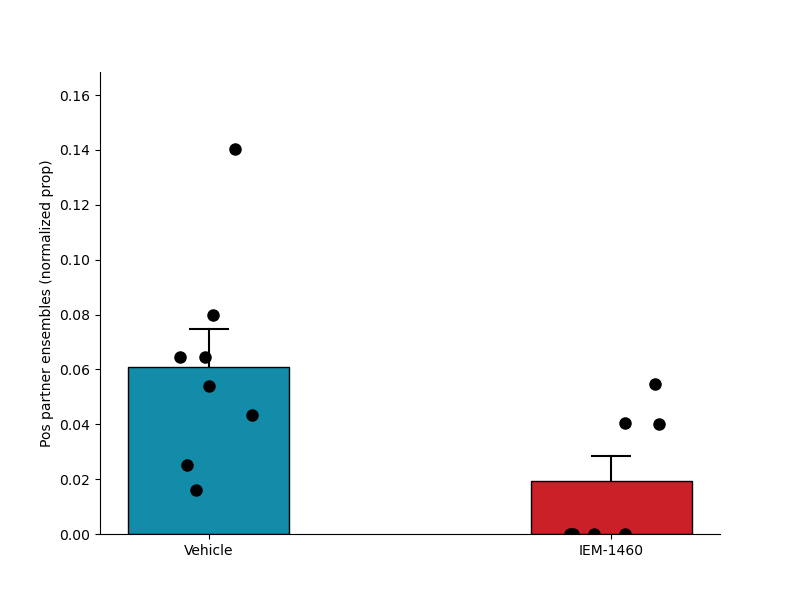

In [31]:
plot_assembly_prediction_results(assembly_results_partner_day2, proportion_type='positive', save_dir=figDataSaveDir + '/imagingInhib_population', 
                                 filename='day2_assemblies_partner_positive',  y_label='Pos partner ensembles (normalized prop)')



Statistical Results:
Control: n=8, mean=0.02, SEM=0.01
IEM-1460: n=7, mean=0.03, SEM=0.01
t(13) = -0.20, p = 0.842


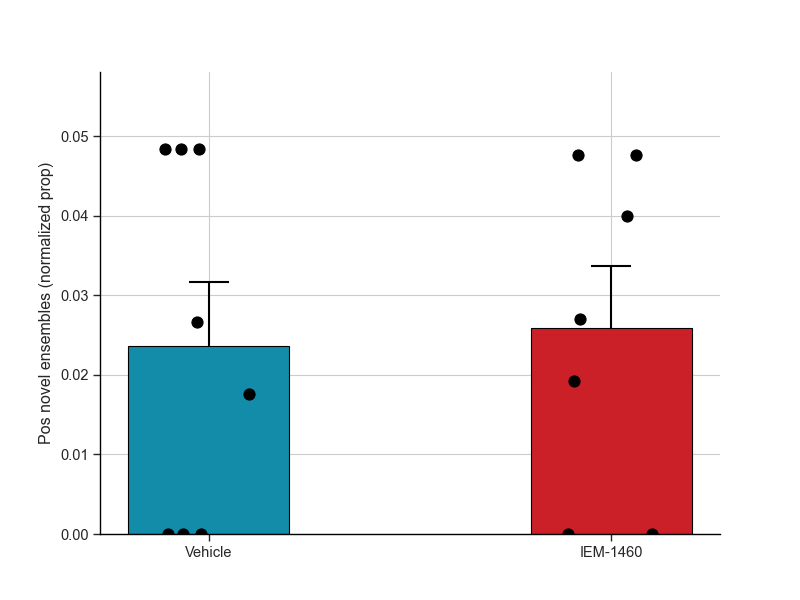

In [68]:
plot_assembly_prediction_results(assembly_results_novel_day2, proportion_type='positive', save_dir=figDataSaveDir + '/imagingInhib_population_supp', 
                                 filename='day2_assemblies_novel_positive',  y_label='Pos novel ensembles (normalized prop)')


Statistical Results:
Control: n=8, mean=0.02, SEM=0.01
IEM-1460: n=7, mean=0.03, SEM=0.01
t(13) = -0.20, p = 0.842


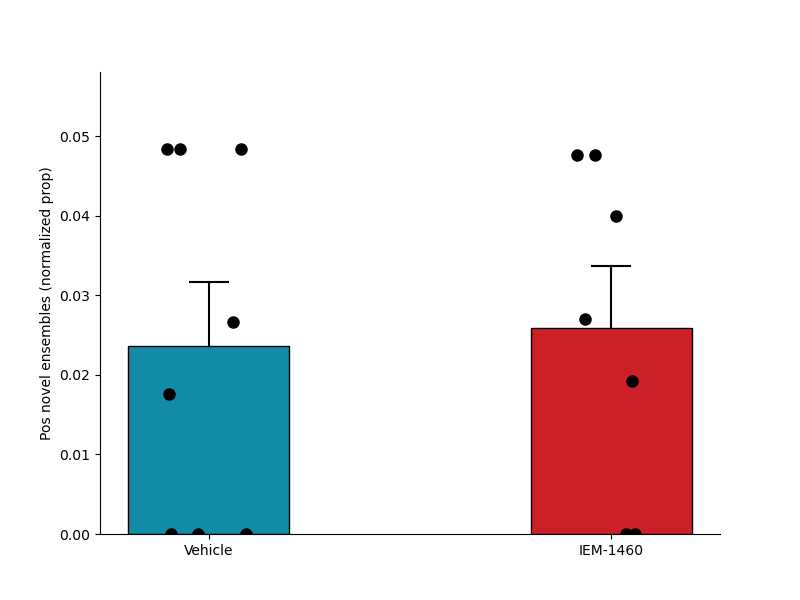

In [33]:
plot_assembly_prediction_results(assembly_results_novel_day2, proportion_type='positive', save_dir=figDataSaveDir + '/imagingInhib_population_supp', 
                                 filename='day2_assemblies_novel_positive',  y_label='Pos novel ensembles (normalized prop)')


Statistical Results:
Control: n=7, mean=0.05, SEM=0.02
IEM-1460: n=7, mean=0.04, SEM=0.02
t(12) = 0.62, p = 0.549


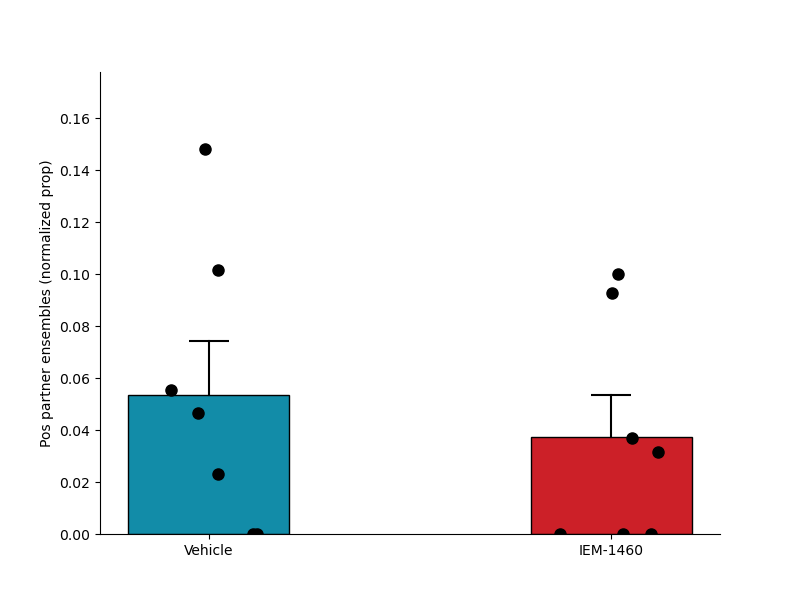

In [34]:
plot_assembly_prediction_results(assembly_results_partner_day14, proportion_type='positive', save_dir=figDataSaveDir + '/imagingInhib_population_supp', 
                                 filename='day14_assemblies_partner_positive',  y_label='Pos partner ensembles (normalized prop)')

In [35]:
def plot_total_assembly_results_across_days(
    assemblies_data_day0, assemblies_data_day1, assemblies_data_day2, save_dir=None, filename=None, title_in=None, x_label=None, y_label=None
):
    """
    Plot normalized total number of assemblies in control vs. experimental groups across days, with individual data points, mean, and standard error.
    Saves the data points to a CSV file.

    Parameters:
    - assemblies_data_day0: dict, output from extract_assemblies function for day0
    - assemblies_data_day1: dict, output from extract_assemblies function for day1
    - assemblies_data_day2: dict, output from extract_assemblies function for day2
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots and CSV
    - title_in: str, title of the plot
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis
    """
    control_totals = {'day0': {}, 'day1': {}, 'day2': {}}
    expt_totals = {'day0': {}, 'day1': {}, 'day2': {}}
    csv_data = []

    for day, results in zip(['day0', 'day1', 'day2'], [assemblies_data_day0, assemblies_data_day1, assemblies_data_day2]):
        for group_name, group_data in results.items():
            for animal_id, data in group_data.items():
                if day in data:
                    num_neurons = data[day]['num_neurons']
                    num_assemblies = data[day]['num_assemblies']
                    normalized_total = num_assemblies / num_neurons
                    
                    csv_data.append({
                        'Group': 'Control' if group_name == 'control' else 'Experimental',
                        'Animal_ID': animal_id,
                        'Day': day,
                        'Normalized_Total': normalized_total
                    })

                    if group_name == 'control':
                        control_totals[day][animal_id] = normalized_total
                    elif group_name == 'expt':
                        expt_totals[day][animal_id] = normalized_total

    control_df = pd.DataFrame([
        {'animal_id': animal_id, 'day': day, 'total': total, 'group': 'control'}
        for day, animals in control_totals.items()
        for animal_id, total in animals.items()
    ])

    expt_df = pd.DataFrame([
        {'animal_id': animal_id, 'day': day, 'total': total, 'group': 'expt'}
        for day, animals in expt_totals.items()
        for animal_id, total in animals.items()
    ])

    df = pd.concat([control_df, expt_df], ignore_index=True)

    # Calculate means and standard errors
    control_means = df[df['group'] == 'control'].groupby('day')['total'].mean().reindex(['day0', 'day1', 'day2'])
    control_sems = df[df['group'] == 'control'].groupby('day')['total'].sem().reindex(['day0', 'day1', 'day2'])
    expt_means = df[df['group'] == 'expt'].groupby('day')['total'].mean().reindex(['day0', 'day1', 'day2'])
    expt_sems = df[df['group'] == 'expt'].groupby('day')['total'].sem().reindex(['day0', 'day1', 'day2'])

    # Perform t-tests for each day
    for day in ['day0', 'day1', 'day2']:
        control_values = df[(df['group'] == 'control') & (df['day'] == day)]['total'].dropna()
        expt_values = df[(df['group'] == 'expt') & (df['day'] == day)]['total'].dropna()
        t_stat, p_value = stats.ttest_ind(control_values, expt_values, equal_var=False)
        print(f"T-test results for {day}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

    # Perform repeated measures ANOVA using mixed linear model
    model = MixedLM.from_formula('total ~ group * day', groups='animal_id', data=df)
    result = model.fit()
    print(result.summary())

    # Plotting
    plt.figure()
    x = ['day0', 'day1', 'day2']
    
    colors = {'control': '#048BA8', 'expt': '#D31F30'}

    # Plot control group
    for animal_id in df[df['group'] == 'control']['animal_id'].unique():
        animal_data = df[(df['group'] == 'control') & (df['animal_id'] == animal_id)].set_index('day').reindex(x)['total']
        plt.plot(x, animal_data, color=colors['control'], alpha=0.3)
    plt.errorbar(x, control_means, yerr=control_sems, fmt='o-', color=colors['control'], capsize=0, label='Control')

    # Plot experimental group
    for animal_id in df[df['group'] == 'expt']['animal_id'].unique():
        animal_data = df[(df['group'] == 'expt') & (df['animal_id'] == animal_id)].set_index('day').reindex(x)['total']
        plt.plot(x, animal_data, color=colors['expt'], alpha=0.3)
    plt.errorbar(x, expt_means, yerr=expt_sems, fmt='o-', color=colors['expt'], capsize=0, label='Experimental')

    plt.ylabel(y_label if y_label else 'Normalized Number of Assemblies')
    plt.title(title_in if title_in else 'Normalized Number of Assemblies Across Days in Control vs. Experimental Groups')
    plt.xlabel(x_label if x_label else 'Day')
    plt.legend()

    plt.grid(False)

    if save_dir and filename:
        # Save plot
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')

        # Save CSV
        csv_path = os.path.join(save_dir, filename + '_data.csv')
        pd.DataFrame(csv_data).to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    
    plt.show()

    
def plot_assembly_prediction_results_across_days(
    results_day0, results_day1, results_day2, proportion_type='total', save_dir=None, filename=None, title_in=None, x_label=None, y_label=None
):
    """
    Plot normalized proportions of control and experimental animals across days, with individual data points, mean, and standard error.
    Saves data points into a CSV file.

    Parameters:
    - results_day0: dict, results from assembly_prediction_PPTs for day0
    - results_day1: dict, results from assembly_prediction_PPTs for day1
    - results_day2: dict, results from assembly_prediction_PPTs for day2
    - proportion_type: str, type of proportion to plot ('total', 'positive', 'negative'), default is 'total'
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots and CSV
    - title_in: str, title of the plot
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis
    """
    control_proportions = {'day0': {}, 'day1': {}, 'day2': {}}
    expt_proportions = {'day0': {}, 'day1': {}, 'day2': {}}
    csv_data = []

    for day, results in zip(['day0', 'day1', 'day2'], [results_day0, results_day1, results_day2]):
        for group_name, group_data in results.items():
            for animal_id, data in group_data.items():
                if day in data:
                    num_neurons = data[day]['num_neurons']
                    if proportion_type == 'total':
                        count = len(data[day]['pos_indices']) + len(data[day]['neg_indices'])
                    elif proportion_type == 'positive':
                        count = len(data[day]['pos_indices'])
                    elif proportion_type == 'negative':
                        count = len(data[day]['neg_indices'])
                    else:
                        raise ValueError("proportion_type must be 'total', 'positive', or 'negative'")
                    
                    normalized_count = count / num_neurons
                    
                    csv_data.append({
                        'Group': 'Control' if group_name == 'control' else 'Experimental',
                        'Animal_ID': animal_id,
                        'Day': day,
                        'Normalized_Proportion': normalized_count
                    })
                    
                    if group_name == 'control':
                        control_proportions[day][animal_id] = normalized_count
                    elif group_name == 'expt':
                        expt_proportions[day][animal_id] = normalized_count

    control_df = pd.DataFrame([
        {'animal_id': animal_id, 'day': day, 'proportion': proportion, 'group': 'control'}
        for day, animals in control_proportions.items()
        for animal_id, proportion in animals.items()
    ])

    expt_df = pd.DataFrame([
        {'animal_id': animal_id, 'day': day, 'proportion': proportion, 'group': 'expt'}
        for day, animals in expt_proportions.items()
        for animal_id, proportion in animals.items()
    ])

    df = pd.concat([control_df, expt_df], ignore_index=True)

    # Perform repeated measures ANOVA using mixed linear model
    model = MixedLM.from_formula('proportion ~ group + day', groups='animal_id', data=df)
    result = model.fit()
    print(result.summary())
    
    # Calculate means and standard errors
    control_means = df[df['group'] == 'control'].groupby('day')['proportion'].mean().reindex(['day0', 'day1', 'day2'])
    control_sems = df[df['group'] == 'control'].groupby('day')['proportion'].sem().reindex(['day0', 'day1', 'day2'])
    expt_means = df[df['group'] == 'expt'].groupby('day')['proportion'].mean().reindex(['day0', 'day1', 'day2'])
    expt_sems = df[df['group'] == 'expt'].groupby('day')['proportion'].sem().reindex(['day0', 'day1', 'day2'])

    # Perform t-tests for each day
    for day in ['day0', 'day1', 'day2']:
        control_values = df[(df['group'] == 'control') & (df['day'] == day)]['proportion'].dropna()
        expt_values = df[(df['group'] == 'expt') & (df['day'] == day)]['proportion'].dropna()
        t_stat, p_value = stats.ttest_ind(control_values, expt_values, equal_var=False)
        print(len(control_values)+len(expt_values))
        print(f"T-test results for {day}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

    # Plotting
    plt.figure()
    plt.style.use('default')
    x = ['day0', 'day1', 'day2']
    
    colors = {'control': '#048BA8', 'expt': '#D31F30'}

    # Plot control group
    for animal_id in df[df['group'] == 'control']['animal_id'].unique():
        animal_data = df[(df['group'] == 'control') & (df['animal_id'] == animal_id)].set_index('day').reindex(x)['proportion']
        plt.plot(x, animal_data, color=colors['control'], alpha=0.3)
    plt.errorbar(x, control_means, yerr=control_sems, fmt='o-', color=colors['control'], capsize=0, label='Control')

    # Plot experimental group
    for animal_id in df[df['group'] == 'expt']['animal_id'].unique():
        animal_data = df[(df['group'] == 'expt') & (df['animal_id'] == animal_id)].set_index('day').reindex(x)['proportion']
        plt.plot(x, animal_data, color=colors['expt'], alpha=0.3)
    plt.errorbar(x, expt_means, yerr=expt_sems, fmt='o-', color=colors['expt'], capsize=0, label='Experimental')

    plt.ylabel(y_label if y_label else f'Normalized {proportion_type.capitalize()} Proportion of Assemblies')
    plt.title(title_in if title_in else f'Normalized {proportion_type.capitalize()} Proportion of Assemblies Across Days in Control vs. Experimental Groups')
    plt.xlabel(x_label if x_label else 'Day')
    plt.legend()
    plt.grid(False)

    if save_dir and filename:
        # Save plot
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')

        # Save CSV
        csv_path = os.path.join(save_dir, filename + '_data.csv')
        pd.DataFrame(csv_data).to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    
    plt.show()




         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: proportion
No. Observations: 50      Method:             REML      
No. Groups:       10      Scale:              0.0010    
Min. group size:  2       Log-Likelihood:     85.9027   
Max. group size:  6       Converged:          Yes       
Mean group size:  5.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.042    0.009  4.549 0.000  0.024  0.060
group[T.expt] -0.022    0.009 -2.444 0.015 -0.040 -0.004
day[T.day1]   -0.004    0.011 -0.404 0.686 -0.025  0.017
day[T.day2]    0.010    0.011  0.914 0.361 -0.012  0.032
animal_id Var  0.000    0.006                           

18
T-test results for day0: t-statistic = 0.491, p-value = 6.327e-01
17
T-test results for day1: t-statistic = 1.153, p-value = 2.668e-01
15
T-test result

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\ensembles_partner_across_days_data.csv


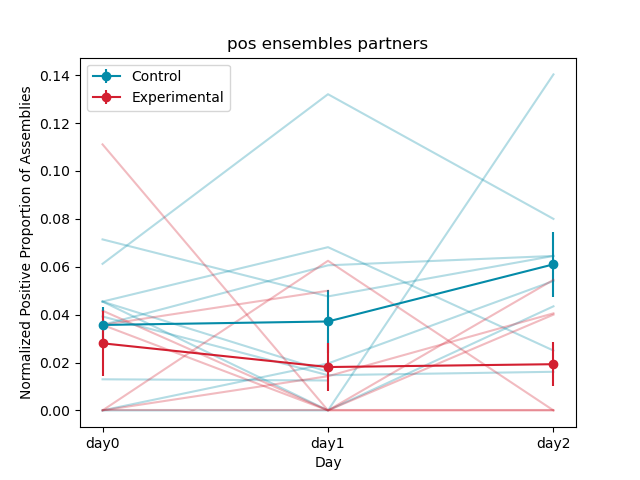

In [36]:
plot_assembly_prediction_results_across_days(assembly_results_partner_day0, 
                                             assembly_results_partner_day1, 
                                             assembly_results_partner_day2, 
                                             proportion_type='positive', 
                                             save_dir=figDataSaveDir + '/imagingInhib_population', 
                                             filename='ensembles_partner_across_days', 
                                             title_in='pos ensembles partners')



T-test results for day0: t-statistic = -1.103, p-value = 2.926e-01
T-test results for day1: t-statistic = -1.714, p-value = 1.271e-01
T-test results for day2: t-statistic = -0.810, p-value = 4.359e-01
               Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      total  
No. Observations:      50           Method:                  REML   
No. Groups:            10           Scale:                   0.0012 
Min. group size:       2            Log-Likelihood:          76.6698
Max. group size:       6            Converged:               Yes    
Mean group size:       5.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.305    0.012 25.889 0.000  0.282  0.328
group[T.expt]              0.023    0.017  1.408 0.159 -

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


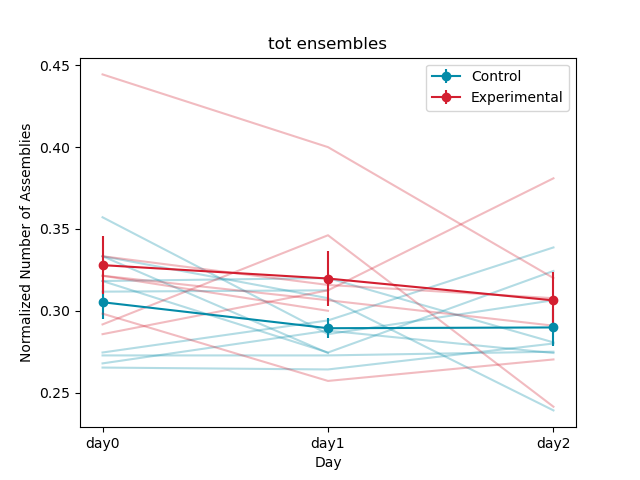

In [37]:
plot_total_assembly_results_across_days(
    assemblies_data_day0=assemblies_data_day0,
    assemblies_data_day1=assemblies_data_day1,
    assemblies_data_day2=assemblies_data_day2,
    save_dir=figDataSaveDir + '/imagingInhib_population',  
    filename='total_ensembles_across_days', 
    title_in='tot ensembles'
)

In [38]:
def plot_assembly_pvsn(results_partner, results_novel, proportion_type='total', save_dir=None, filename=None, title_in=None, x_label=None, y_label=None):
    """
    Plot normalized proportions of control and experimental animals for partner and novel, with individual data points, mean, and standard error.
    Save the data in a CSV for reproducibility.

    Parameters:
    - results_partner: dict, results from assembly_prediction_PPTs for partner
    - results_novel: dict, results from assembly_prediction_PPTs for novel
    - proportion_type: str, type of proportion to plot ('total', 'positive', 'negative', 'subtraction'), default is 'total'
    - save_dir: str, directory to save the plots and CSV
    - filename: str, filename to save the plots and CSV
    - title_in: str, title of the plot
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis
    """
    def process_results(results):
        proportions = {'control': [], 'expt': []}
        animal_data = []
        for group_name, group_data in results.items():
            for animal_id, animal_data_dict in group_data.items():
                for day, data in animal_data_dict.items():
                    if proportion_type == 'total':
                        count = len(data['pos_indices']) + len(data['neg_indices'])
                    elif proportion_type == 'positive':
                        count = len(data['pos_indices'])
                    elif proportion_type == 'negative':
                        count = len(data['neg_indices'])
                    elif proportion_type == 'subtraction':
                        count = len(data['pos_indices']) - len(data['neg_indices'])
                    else:
                        raise ValueError("proportion_type must be 'total', 'positive', 'negative', or 'subtraction'")
                    
                    normalized_count = count / data['num_neurons']
                    animal_data.append({
                        'animal_id': animal_id,
                        'day': day,
                        'group': group_name,
                        'type': 'partner' if results is results_partner else 'novel',
                        'proportion': normalized_count
                    })
                    proportions[group_name].append(normalized_count)
        return proportions['control'], proportions['expt'], animal_data

    def plot_data(ax, partner_proportions, novel_proportions, colors, title):
        partner_mean = np.nanmean(partner_proportions)
        partner_sem = stats.sem(partner_proportions, nan_policy='omit')
        novel_mean = np.nanmean(novel_proportions)
        novel_sem = stats.sem(novel_proportions, nan_policy='omit')

        jitter_strength = 0.1
        partner_jitter = np.random.normal(0, jitter_strength, len(partner_proportions))
        novel_jitter = np.random.normal(0, jitter_strength, len(novel_proportions))
        
        ax.scatter(np.full(len(partner_proportions), 1) + partner_jitter, partner_proportions, color=colors['partner'], label='Partner')
        ax.scatter(np.full(len(novel_proportions), 2) + novel_jitter, novel_proportions, color=colors['novel'], label='Novel')
        
        ax.errorbar(1, partner_mean, yerr=partner_sem, fmt='o', color='black', capsize=0)
        ax.errorbar(2, novel_mean, yerr=novel_sem, fmt='o', color='black', capsize=0)
        
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Partner', 'Novel'])
        ax.set_title(title)
        ax.legend()

        t_stat, p_value = stats.ttest_ind(partner_proportions, novel_proportions, equal_var=False, nan_policy='omit')
        print(f"{title} - T-test results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

    colors = {
        'control': {'partner': '#048BA8', 'novel': '#81E2FF'},
        'expt': {'partner': '#D31F30', 'novel': '#FF9999'}
    }

    control_proportions_partner, expt_proportions_partner, partner_data = process_results(results_partner)
    control_proportions_novel, expt_proportions_novel, novel_data = process_results(results_novel)

    # Combine all animal data into a single DataFrame
    all_data = pd.DataFrame(partner_data + novel_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    plot_data(ax1, control_proportions_partner, control_proportions_novel, colors['control'], 'Control Group: Partner vs. Novel')
    plot_data(ax2, expt_proportions_partner, expt_proportions_novel, colors['expt'], 'Experimental Group: Partner vs. Novel')

    # Set consistent y-axis limits for all plots
    ax1.set_ylim(-0.02, 0.18)
    ax2.set_ylim(-0.02, 0.18)

    fig.suptitle(title_in if title_in else f'Normalized {proportion_type.capitalize()} Proportion of Assemblies')
    fig.text(0.5, 0.02, x_label if x_label else 'Assembly Type', ha='center')
    fig.text(0.04, 0.5, y_label if y_label else f'Normalized {proportion_type.capitalize()} Proportion', va='center', rotation='vertical')

    plt.tight_layout()

    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        save_path_csv = os.path.join(save_dir, filename + '.csv')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        all_data.to_csv(save_path_csv, index=False)
        print(f"Plots saved as {save_path_svg} and {save_path_png}")
        print(f"Data saved as {save_path_csv}")
    
    plt.show()



Control Group: Partner vs. Novel - T-test results: t-statistic = 2.369, p-value = 3.664e-02
Experimental Group: Partner vs. Novel - T-test results: t-statistic = -0.548, p-value = 5.939e-01
Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population_supp\assembly_comparison.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population_supp\assembly_comparison.png
Data saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population_supp\assembly_comparison.csv


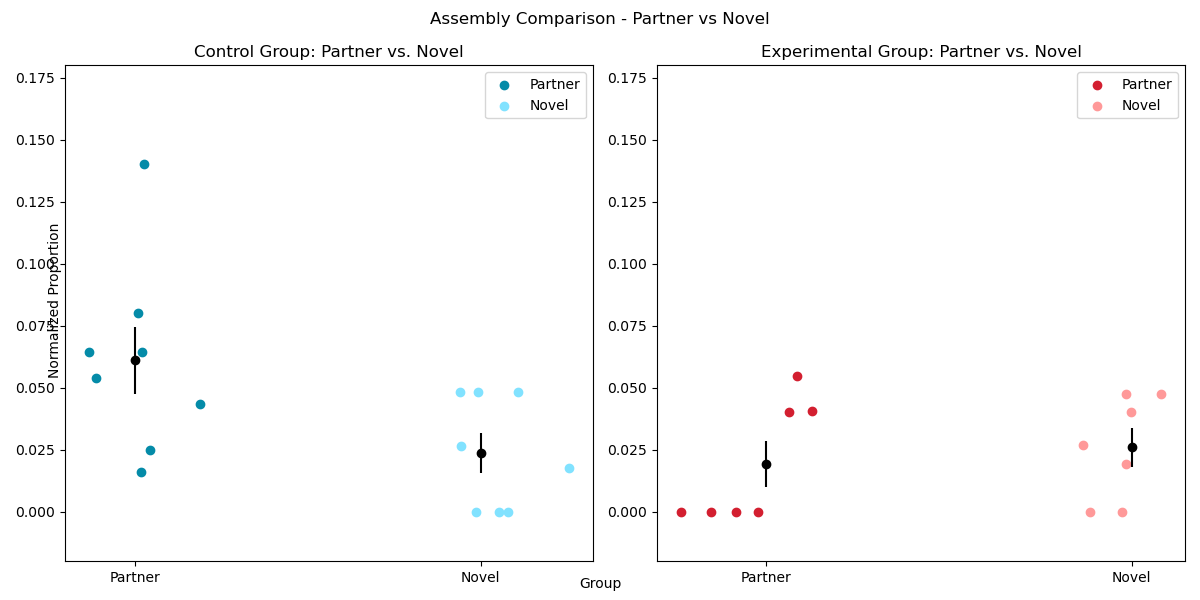

In [39]:
plot_assembly_pvsn(assembly_results_partner_day2, assembly_results_novel_day2, proportion_type='positive', 
                   save_dir=figDataSaveDir + '/imagingInhib_population_supp', filename='assembly_comparison', 
                   title_in='Assembly Comparison - Partner vs Novel', 
                   x_label='Group', y_label='Normalized Proportion')

### # of partner-neurons in assemblies

In [40]:
def analyze_assembly_sizes(assembly_results_partner_day2, save_dir=None, filename_prefix=None):
    """
    Analyze and compare assembly sizes for both all assemblies and partner-encoding assemblies.
    
    Returns:
    --------
    dict containing results and statistics for both analyses
    """
    results = {
        'all': {'control': [], 'expt': []},
        'partner': {'control': [], 'expt': []}
    }
    
    # Set colors
    colors = {'control': '#128CA8', 'expt': '#CC2028'}
    
    for group_name in ['control', 'expt']:
        for animal_id, assembly_data in assembly_results_partner_day2[group_name].items():
            if 'day2' in assembly_data:
                patterns = assembly_data['day2']['important_neurons']
                total_neurons = patterns.shape[1]
                important_neuron_indices = get_important_neurons(patterns, mode='stdev', stdevthresh=2)
                
                # Analysis for all assemblies
                all_important_neurons = [neurons for neurons in important_neuron_indices if len(neurons) > 1]
                if all_important_neurons:
                    avg_important_neurons = np.mean([len(neurons) for neurons in all_important_neurons])
                    normalized_avg = avg_important_neurons / total_neurons
                    results['all'][group_name].append((animal_id, normalized_avg))
                
                # Analysis for partner-encoding assemblies
                pos_indices = assembly_data['day2']['pos_indices']
                partner_important_neurons = [
                    important_neuron_indices[idx] for idx in pos_indices if len(important_neuron_indices[idx]) > 1
                ]
                if partner_important_neurons:
                    avg_important_neurons = np.mean([len(neurons) for neurons in partner_important_neurons])
                    normalized_avg = avg_important_neurons / total_neurons
                    results['partner'][group_name].append((animal_id, normalized_avg))
    
    # Create statistics and plots
    stats_results = {}
    
    for analysis_type in ['all', 'partner']:
        # Extract data
        control_data = [value for _, value in results[analysis_type]['control']]
        expt_data = [value for _, value in results[analysis_type]['expt']]
        csv_data = []
        
        # Prepare CSV data
        for animal_id, value in results[analysis_type]['control']:
            csv_data.append({
                'Group': 'Control',
                'Animal': animal_id,
                'Normalized_Size': value
            })
        for animal_id, value in results[analysis_type]['expt']:
            csv_data.append({
                'Group': 'Experimental',
                'Animal': animal_id,
                'Normalized_Size': value
            })
        
        # Calculate statistics
        control_mean = np.mean(control_data)
        control_sem = stats.sem(control_data) if len(control_data) > 1 else 0
        expt_mean = np.mean(expt_data)
        expt_sem = stats.sem(expt_data) if len(expt_data) > 1 else 0
        
        # Create plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(top=False, right=False)
        
        # Plot bars
        width = 0.4
        bar_positions = [0, 1]
        ax.bar(bar_positions[0], control_mean, width, color=colors['control'], 
               edgecolor='black', zorder=2)
        ax.bar(bar_positions[1], expt_mean, width, color=colors['expt'], 
               edgecolor='black', zorder=2)

        # Add SEM lines
        if control_sem > 0:
            ax.plot([bar_positions[0], bar_positions[0]], 
                   [control_mean, control_mean + control_sem], 
                   color='black', linewidth=1.5, zorder=3)
            ax.hlines(control_mean + control_sem, 
                     bar_positions[0]-0.05, bar_positions[0]+0.05, 
                     color='black', linewidth=1.5, zorder=3)
        
        if expt_sem > 0:
            ax.plot([bar_positions[1], bar_positions[1]], 
                   [expt_mean, expt_mean + expt_sem], 
                   color='black', linewidth=1.5, zorder=3)
            ax.hlines(expt_mean + expt_sem, 
                     bar_positions[1]-0.05, bar_positions[1]+0.05, 
                     color='black', linewidth=1.5, zorder=3)
        
        # Add jittered black dots
        jitter_range = width/3
        for pos, data in [(bar_positions[0], control_data), 
                         (bar_positions[1], expt_data)]:
            if data:
                jitter = np.random.uniform(-jitter_range, jitter_range, size=len(data))
                ax.scatter(pos + jitter, data, color='black', s=64, zorder=3)
        
        # Set labels and title
        ax.set_ylabel('Normalized Avg # of Important Neurons')
        if analysis_type == 'partner':
            ax.set_title('Assembly Size (Partner-Encoding Only)')
        else:
            ax.set_title('Assembly Size (All Assemblies)')
        
        # Set x-axis
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(['Vehicle', 'IEM-1460'])
        
        # Set y-axis limits
        all_values = control_data + expt_data
        ax.set_ylim(0, max(all_values) * 1.2)
        
        # Save results
        if save_dir and filename_prefix:
            os.makedirs(save_dir, exist_ok=True)
            filename = f"{filename_prefix}_{analysis_type}_assembly_sizes"
            plt.savefig(os.path.join(save_dir, filename + '.svg'), 
                       format='svg', bbox_inches='tight')
            plt.savefig(os.path.join(save_dir, filename + '.png'), 
                       format='png', bbox_inches='tight')
            
            # Save CSV
            pd.DataFrame(csv_data).to_csv(os.path.join(save_dir, filename + '_data.csv'), 
                                        index=False)
        
        # Calculate and print statistics
        t_stat, p_value = stats.ttest_ind(control_data, expt_data, equal_var=False)
        n_control = len(control_data)
        n_expt = len(expt_data)
        
        print(f"\n{analysis_type.capitalize()} Assemblies Analysis:")
        print(f"Control: n={n_control}, mean={control_mean:.2f}, SEM={control_sem:.2f}")
        print(f"IEM-1460: n={n_expt}, mean={expt_mean:.2f}, SEM={expt_sem:.2f}")
        print(f"t({n_control + n_expt - 2}) = {t_stat:.2f}, p = {p_value:.3f}")
        
        stats_results[analysis_type] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'df': n_control + n_expt - 2,
            'n_control': n_control,
            'n_expt': n_expt
        }
        
        plt.show()
    
    return {
        'results': results,
        'statistics': stats_results
    }


All Assemblies Analysis:
Control: n=8, mean=0.05, SEM=0.00
IEM-1460: n=7, mean=0.07, SEM=0.01
t(13) = -1.79, p = 0.112


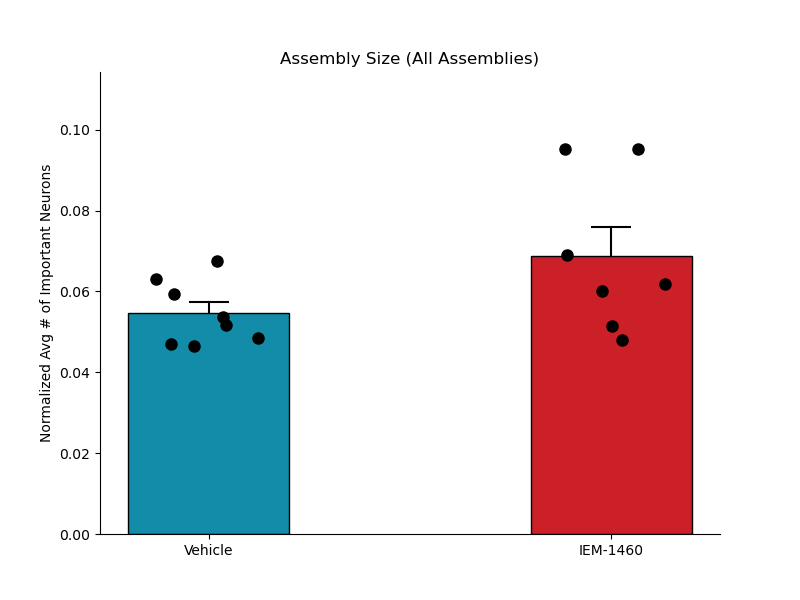


Partner Assemblies Analysis:
Control: n=8, mean=0.05, SEM=0.00
IEM-1460: n=3, mean=0.05, SEM=0.00
t(9) = 0.70, p = 0.505


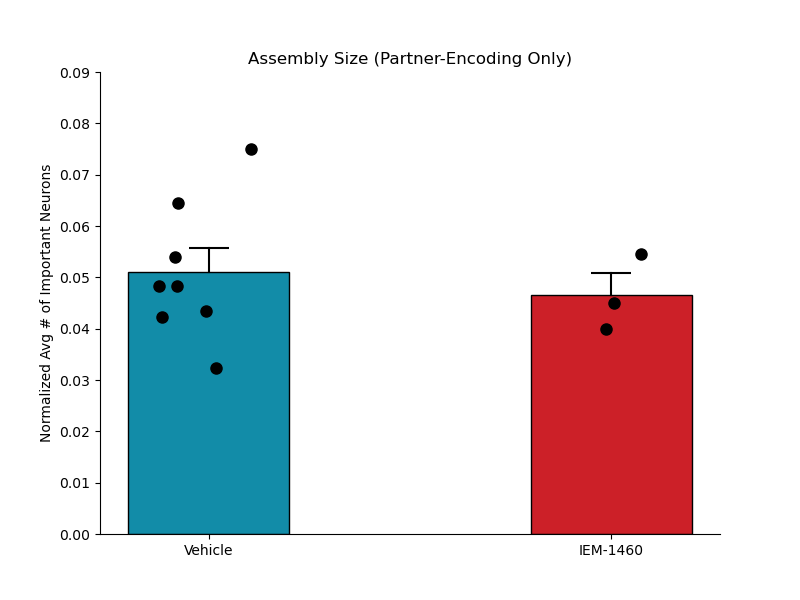

In [41]:
results = analyze_assembly_sizes(assembly_results_partner_day2,  save_dir=figDataSaveDir + '/imagingInhib_population_supp',
                                 filename_prefix='number_important_neurons')


### ensembles in space

In [42]:
def calculate_pairwise_distances(cells):
    """Calculate the pairwise Euclidean distances between cells."""
    return pdist(cells, metric='euclidean')

def shuffle_and_calculate_distances(cells, n_selected, n_shuffles=1000):
    """Shuffle cell labels and calculate pairwise distances for a random subset of cells."""
    shuffled_distances = []
    for _ in range(n_shuffles):
        shuffled_indices = np.random.choice(len(cells), n_selected, replace=False)
        shuffled_cells = cells[shuffled_indices]
        distances = calculate_pairwise_distances(shuffled_cells)
        shuffled_distances.append(np.mean(distances))
    return shuffled_distances

def identify_outliers(observed_distance, shuffled_distances):
    """Identify if observed distance is outside the 5% or 95% of the shuffle distribution."""
    lower_bound = np.percentile(shuffled_distances, 5)
    upper_bound = np.percentile(shuffled_distances, 95)
    percentile = (np.sum(np.array(shuffled_distances) < observed_distance) / len(shuffled_distances)) * 100
    
    if observed_distance < lower_bound:
        return 'below 5%', percentile
    elif observed_distance > upper_bound:
        return 'above 95%', percentile
    else:
        return 'within range', percentile


def analyze_spatial_clustering_assemblies(assembly_results_partner_day2, data_groups, non_partner_encoding=False):
    results = {'control': {}, 'expt': {}}

    for group_name in ['control', 'expt']:
        for animal_id, assembly_data in assembly_results_partner_day2[group_name].items():
            if 'day2' in assembly_data:
                pos_indices = assembly_data['day2']['pos_indices']  # Partner-encoding assemblies
                patterns = assembly_data['day2']['important_neurons']  # Neuron weight matrix (assemblies x neurons)

                # Extract spatial_save and dims_save from data_groups on the fly
                if animal_id not in data_groups[group_name] or 'day2' not in data_groups[group_name][animal_id]:
                    print(f"Warning: Spatial data for animal {animal_id} on day2 not found in group {group_name}")
                    continue
                
                spatial_data = data_groups[group_name][animal_id]['day2'].get('spatial_data', {})
                spatial_save = spatial_data.get('spatial_save')
                dims_save = spatial_data.get('dims_save')

                if spatial_save is None or dims_save is None:
                    print(f"Warning: Spatial_save or dims_save missing for animal {animal_id} on day2 in group {group_name}")
                    continue
                
                height, width = dims_save  # Assuming dims_save contains the imaging frame dimensions

                # Get the 2D positions of all cells
                all_cells = []
                for i in range(spatial_save.shape[1]):
                    footprint_1d = spatial_save[:, i].toarray().ravel()
                    expected_size = height * width
                    if footprint_1d.size != expected_size:
                        if footprint_1d.size % expected_size != 0:
                            print(f"Skipping neuron {i}: cannot reshape array of size {footprint_1d.size} into shape ({height}, {width})")
                            continue
                        footprint_1d = footprint_1d[:expected_size]
                    footprint_2d = np.reshape(footprint_1d, (height, width), order='F')
                    max_pos = np.unravel_index(np.argmax(footprint_2d), footprint_2d.shape)
                    all_cells.append(max_pos)
                
                all_cells = np.array(all_cells)

                # Determine which assemblies to analyze based on the flag
                if non_partner_encoding:
                    # Use all assemblies except partner-encoding ones
                    all_indices = set(range(len(patterns)))
                    non_partner_indices = all_indices - set(pos_indices)
                    indices_to_analyze = list(non_partner_indices)
                else:
                    # Use partner-encoding assemblies only
                    indices_to_analyze = pos_indices

                # Get important neuron indices for the selected assemblies
                important_neuron_indices = get_important_neurons(patterns, mode='stdev', stdevthresh=2)
                selected_important_neurons = [
                    important_neuron_indices[idx] for idx in indices_to_analyze if len(important_neuron_indices[idx]) > 1
                ]

                # Skip animals without valid assemblies
                if not selected_important_neurons:
                    print(f"Skipping animal {animal_id}: No valid assemblies or insufficient important neurons")
                    continue

                # Analyze selected assemblies
                assembly_percentiles = []
                for neuron_indices in selected_important_neurons:
                    if len(neuron_indices) > 1:
                        selected_cells = all_cells[neuron_indices]

                        # Calculate observed pairwise distances
                        observed_distances = calculate_pairwise_distances(selected_cells)
                        observed_mean_distance = np.mean(observed_distances)
                        
                        # Shuffle all cells and calculate pairwise distances
                        shuffled_distances = shuffle_and_calculate_distances(all_cells, len(selected_cells))
                        
                        # Identify if the observed mean distance is an outlier and get its percentile
                        _, percentile = identify_outliers(observed_mean_distance, shuffled_distances)
                        assembly_percentiles.append(percentile)
                
                # Average percentile across selected assemblies
                if assembly_percentiles:
                    avg_percentile = np.mean(assembly_percentiles)
                else:
                    avg_percentile = None

                results[group_name][animal_id] = {
                    'average_percentile': avg_percentile,
                    'important_neurons': important_neuron_indices,
                    'selected_important_neurons': selected_important_neurons,
                    'analyzed_assemblies': indices_to_analyze
                }

    return results




def plot_spatial_clustering_results(results, save_dir=None, filename_prefix=None):
    control_percentiles = []
    experimental_percentiles = []

    # Create a list to store data for the CSV
    csv_data = []

    print("Results of Spatial Clustering Analysis:")
    for group_name in results:
        print(f"\nGroup: {group_name.capitalize()}")
        for animal_id, result in results[group_name].items():
            avg_percentile = result['average_percentile']
            if avg_percentile is not None:
                print(f"Animal {animal_id}: Average Percentile: {avg_percentile:.2f}%")
                csv_data.append({'Group': group_name.capitalize(), 'AnimalID': animal_id, 'Percentile': avg_percentile})
                if group_name == 'control':
                    control_percentiles.append(avg_percentile)
                elif group_name == 'expt':
                    experimental_percentiles.append(avg_percentile)
            else:
                print(f"Animal {animal_id}: not enough cells for analysis")
                csv_data.append({'Group': group_name.capitalize(), 'AnimalID': animal_id, 'Percentile': None})

    # Save the CSV file
    if save_dir and filename_prefix:
        csv_path = os.path.join(save_dir, f'{filename_prefix}_percentiles.csv')
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_path, index=False)
        print(f"Percentiles saved to {csv_path}")

    # Histograms
    fig_hist, ax_hist = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.style.use('default')

    ax_hist[0].hist(control_percentiles, bins=20, color='#048BA8', edgecolor='black', alpha=0.7)
    ax_hist[0].set_title('Control Group Percentiles')
    ax_hist[0].set_xlabel('Percentile')
    ax_hist[0].set_ylabel('Frequency')
    ax_hist[0].axvline(50, color='gray', linestyle='--')
    ax_hist[0].set_xlim(0, 100)

    ax_hist[1].hist(experimental_percentiles, bins=20, color='#D31F30', edgecolor='black', alpha=0.7)
    ax_hist[1].set_title('Experimental Group Percentiles')
    ax_hist[1].set_xlabel('Percentile')
    ax_hist[1].axvline(50, color='gray', linestyle='--')
    ax_hist[1].set_xlim(0, 100)

    plt.tight_layout()

    if save_dir and filename_prefix:
        hist_save_path_svg = os.path.join(save_dir, f'{filename_prefix}_histograms.svg')
        hist_save_path_png = os.path.join(save_dir, f'{filename_prefix}_histograms.png')
        plt.savefig(hist_save_path_svg, format='svg')
        plt.savefig(hist_save_path_png, format='png')

    plt.show()

    # CDF Plot
    combined_percentiles = control_percentiles + experimental_percentiles
    combined_group = ['Control'] * len(control_percentiles) + ['Experimental'] * len(experimental_percentiles)

    sorted_control = np.sort(control_percentiles)
    sorted_experimental = np.sort(experimental_percentiles)
    y_control = np.arange(1, len(sorted_control) + 1) / len(sorted_control)
    y_experimental = np.arange(1, len(sorted_experimental) + 1) / len(sorted_experimental)

    fig_cdf, ax_cdf = plt.subplots(figsize=(8, 6))
    ax_cdf.plot(sorted_control, y_control, marker='o', linestyle='-', color='#048BA8', label='Control')
    ax_cdf.plot(sorted_experimental, y_experimental, marker='o', linestyle='-', color='#D31F30', label='Experimental')

    ax_cdf.set_title('CDF of Spatial Clustering Percentiles')
    ax_cdf.set_xlabel('Percentile')
    ax_cdf.set_ylabel('Cumulative Probability')
    ax_cdf.axvline(50, color='gray', linestyle='--')
    ax_cdf.set_xlim(0, 100)
    ax_cdf.legend()

    plt.tight_layout()

    if save_dir and filename_prefix:
        cdf_save_path_svg = os.path.join(save_dir, f'{filename_prefix}_cdf.svg')
        cdf_save_path_png = os.path.join(save_dir, f'{filename_prefix}_cdf.png')
        plt.savefig(cdf_save_path_svg, format='svg')
        plt.savefig(cdf_save_path_png, format='png')

    plt.show()

    # Perform t-tests
    t_stat_control, p_val_control = ttest_1samp(control_percentiles, 50)
    t_stat_expt, p_val_expt = ttest_1samp(experimental_percentiles, 50)
    print(len(control_percentiles))
    print(f"Control vs. Null: t-statistic = {t_stat_control:.3f}, p-value = {p_val_control:.3e}")
    print(len(experimental_percentiles))
    print(f"Experimental vs. Null: t-statistic = {t_stat_expt:.3f}, p-value = {p_val_expt:.3e}")

Skipping animal animal2: No valid assemblies or insufficient important neurons
Skipping animal animal3: No valid assemblies or insufficient important neurons
Skipping animal animal6: No valid assemblies or insufficient important neurons
Skipping animal animal7: No valid assemblies or insufficient important neurons
Results of Spatial Clustering Analysis:

Group: Control
Animal animal1: Average Percentile: 33.98%
Animal animal2: Average Percentile: 0.00%
Animal animal3: Average Percentile: 4.20%
Animal animal4: Average Percentile: 24.90%
Animal animal5: Average Percentile: 1.52%
Animal animal6: Average Percentile: 11.25%
Animal animal7: Average Percentile: 87.00%
Animal animal8: Average Percentile: 25.22%

Group: Expt
Animal animal1: Average Percentile: 8.57%
Animal animal4: Average Percentile: 7.65%
Animal animal5: Average Percentile: 18.43%
Percentiles saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\spatia

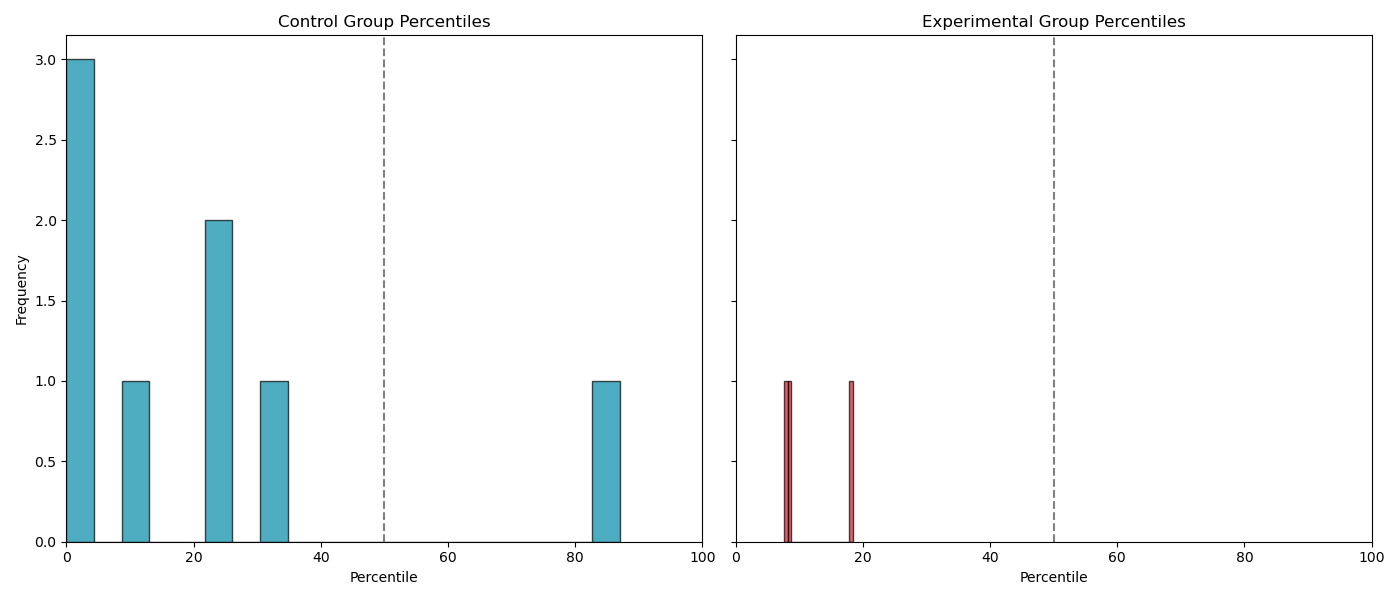

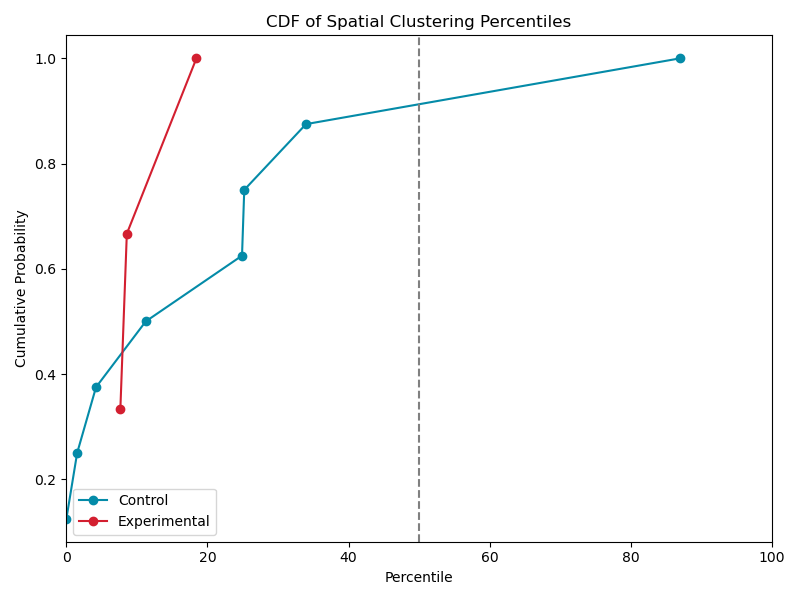

8
Control vs. Null: t-statistic = -2.625, p-value = 3.417e-02
3
Experimental vs. Null: t-statistic = -11.139, p-value = 7.963e-03


In [43]:
ensemble_spatial_clustering = analyze_spatial_clustering_assemblies(assembly_results_partner_day2, data_groups_d2)
plot_spatial_clustering_results(ensemble_spatial_clustering, save_dir=figDataSaveDir + '/imagingInhib_population', filename_prefix='spatial_clustering')

Results of Spatial Clustering Analysis:

Group: Control
Animal animal1: Average Percentile: 24.63%
Animal animal2: Average Percentile: 23.56%
Animal animal3: Average Percentile: 16.21%
Animal animal4: Average Percentile: 43.43%
Animal animal5: Average Percentile: 29.68%
Animal animal6: Average Percentile: 30.99%
Animal animal7: Average Percentile: 43.00%
Animal animal8: Average Percentile: 38.41%

Group: Expt
Animal animal1: Average Percentile: 17.18%
Animal animal2: Average Percentile: 39.70%
Animal animal3: Average Percentile: 21.07%
Animal animal4: Average Percentile: 33.00%
Animal animal5: Average Percentile: 32.51%
Animal animal6: Average Percentile: 16.54%
Animal animal7: Average Percentile: 55.77%
Percentiles saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population_supp\spatial_clustering_nonpartner_percentiles.csv


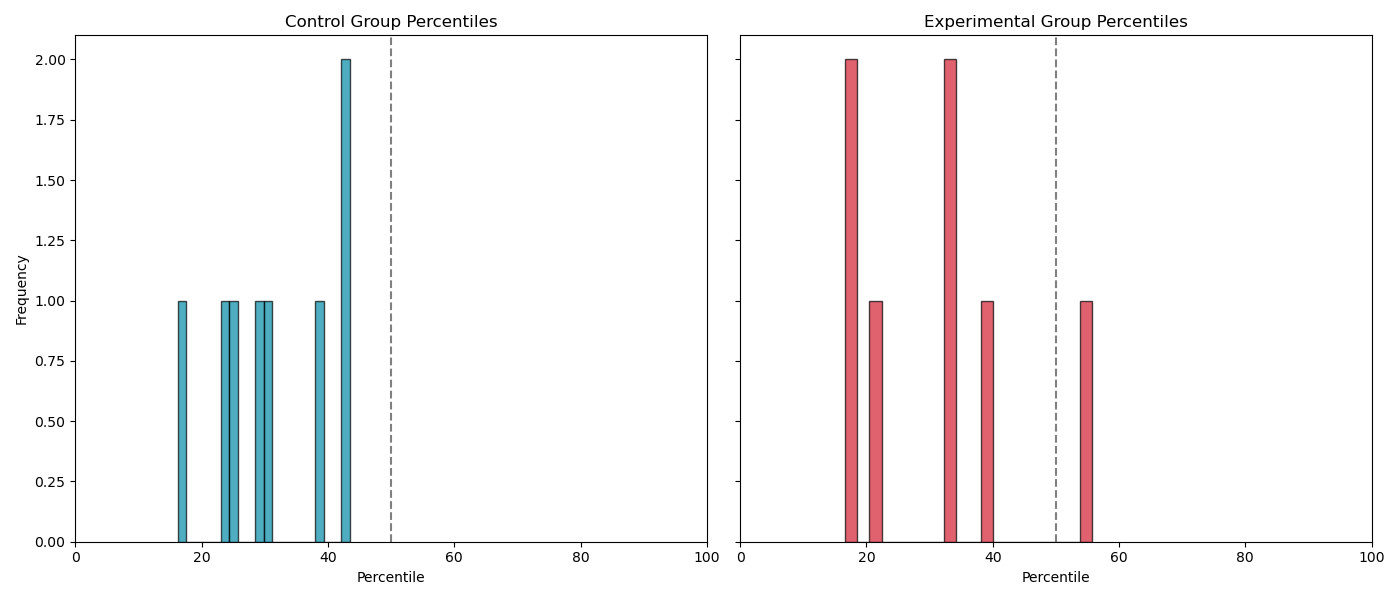

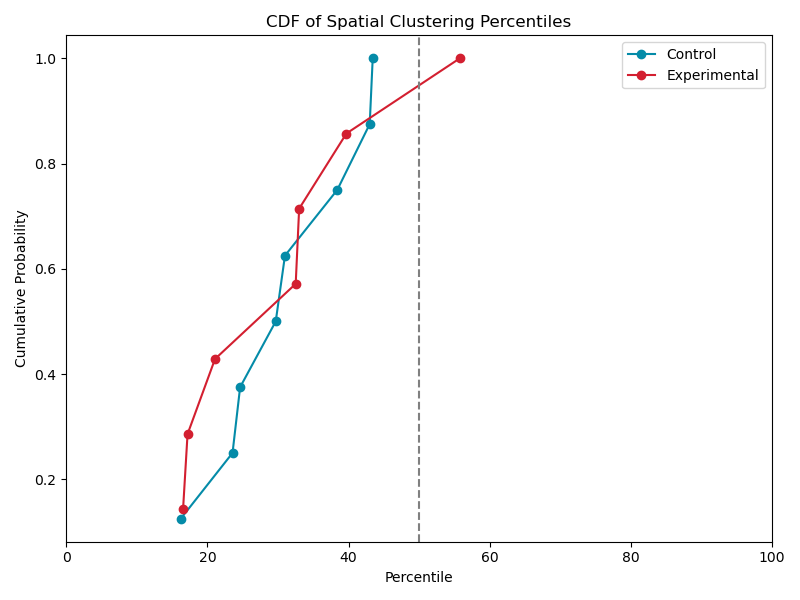

8
Control vs. Null: t-statistic = -5.426, p-value = 9.805e-04
7
Experimental vs. Null: t-statistic = -3.596, p-value = 1.142e-02


In [44]:
nonpartner_ensemble_spatial_clustering = analyze_spatial_clustering_assemblies(assembly_results_partner_day2, data_groups_d2, non_partner_encoding=True)
plot_spatial_clustering_results(nonpartner_ensemble_spatial_clustering, save_dir=figDataSaveDir + '/imagingInhib_population_supp', filename_prefix='spatial_clustering_nonpartner')

In [45]:
def plot_ensemble_members(
    data_groups, assembly_results, group_name, animal_id, day='day2', max_ensembles=None, 
    marker_size=5, save_dir=None, filename=None, threshold=0.5, cmap='tab10', sigma=1.5):
    """
    Plot the ensemble members for partner-encoding assemblies with pseudocolored ROIs overlaid 
    on a white background with smoothing and black outlines.

    Parameters:
    - data_groups: dict, the grouped data
    - assembly_results: dict, the assembly results data
    - group_name: str, the group name ('control' or 'expt')
    - animal_id: str, the ID of the animal to plot
    - day: str, the day to plot (e.g., 'day2')
    - max_ensembles: int, the maximum number of ensembles to plot
    - marker_size: int, size of the marker for maximum points
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots
    - threshold: float, threshold value for refining ROIs
    - cmap: str, colormap name for pseudocolor
    - sigma: float, standard deviation for Gaussian smoothing (default=1.5)
    """


    # Check if animal exists in assembly_results
    if animal_id not in assembly_results.get(group_name, {}):
        print(f"Warning: No assembly results found for animal {animal_id} in group {group_name}. Skipping.")
        return

    animal_results = assembly_results[group_name][animal_id]

    # Check if the specified day exists in assembly_results
    if 'important_neurons' not in animal_results or 'analyzed_assemblies' not in animal_results:
        print(f"Warning: Missing important neurons or analyzed assemblies for animal {animal_id}. Skipping.")
        return

    important_neurons_list = animal_results['important_neurons']
    pos_assemblies = animal_results['analyzed_assemblies']

    # Limit the number of ensembles to plot
    if max_ensembles is not None:
        pos_assemblies = pos_assemblies[:max_ensembles]

    # Check if animal exists in data_groups
    if animal_id not in data_groups[group_name] or day not in data_groups[group_name][animal_id]:
        print(f"Warning: Spatial data for animal {animal_id} on {day} not found. Skipping.")
        return

    spatial_data = data_groups[group_name][animal_id][day].get('spatial_data', {})
    spatial_save = spatial_data.get('spatial_save')
    dims_save = spatial_data.get('dims_save')

    if spatial_save is None or dims_save is None:
        print(f"Warning: Spatial data for animal {animal_id} on {day} is incomplete. Skipping.")
        return

    height, width = dims_save

    def get_thin_edges(mask):
        """Helper function to get thin edges from a binary mask"""
        # Convert to uint8
        mask_uint8 = mask.astype(np.uint8)
        
        # Find contours - this gives single-pixel edges
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw contours on empty image
        edges = np.zeros_like(mask_uint8)
        cv2.drawContours(edges, contours, -1, 1, 1)  # thickness=1
        
        return edges > 0

    # Initialize RGBA image with white background
    final_image = np.ones((height, width, 4))  # RGBA

    # Get the full tab20 colormap
    full_cmap = plt.cm.get_cmap('tab20')
    
    # Create a custom colormap excluding the first color (red)
    n_colors = len(pos_assemblies)
    # Start from index 2 to skip red (indices 0 and 1 in tab20)
    color_indices = np.linspace(2, 9, n_colors)
    colors = full_cmap(color_indices / 20)

    # Map ensembles to colors
    ensemble_color_map = {assembly_idx: colors[color_idx] for color_idx, assembly_idx in enumerate(pos_assemblies)}

    # Extract ROIs for partner-encoding assemblies
    for assembly_idx in pos_assemblies:
        important_neurons = important_neurons_list[assembly_idx]
        color = ensemble_color_map[assembly_idx]
        
        # Create a separate image for this ensemble
        ensemble_image = np.zeros((height, width, 4))
        
        for neuron in important_neurons:
            footprint_1d = spatial_save[:, neuron].toarray().ravel()
            footprint_2d = np.reshape(footprint_1d, (height, width), order='F')

            # Apply Gaussian smoothing
            smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)

            # Threshold the smoothed footprint
            max_value = np.max(smoothed_footprint)
            if max_value > 0:
                # Dynamic threshold adjustment for sparse neurons
                if max_value < 0.1:
                    neuron_threshold = threshold * 0.5
                else:
                    neuron_threshold = threshold

                roi_mask = (smoothed_footprint > (neuron_threshold * max_value))
                
                # Get thin edges
                edges = get_thin_edges(roi_mask.astype(np.uint8))

                # Add the ROI to the ensemble image
                for c in range(4):  # RGBA channels
                    if c < 3:  # RGB channels
                        ensemble_image[roi_mask, c] = color[c]
                    else:  # Alpha channel
                        ensemble_image[roi_mask, c] = 0.7  # Set some transparency

                # Add black edges with full opacity
                ensemble_image[edges] = [0, 0, 0, 1]

        # Composite this ensemble onto the final image
        mask = ensemble_image[:, :, 3] > 0
        final_image[mask] = ensemble_image[mask]

    # Plot the combined ROIs
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(final_image)
    ax.axis('off')
    ax.set_title(f'{group_name.capitalize()} Animal {animal_id} - {day.capitalize()} (Partner Assemblies)')

    # Save the plot if save_dir and filename are provided
    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '_ensembles.svg')
        save_path_png = os.path.join(save_dir, filename + '_ensembles.png')
        plt.savefig(save_path_svg, format='svg', transparent=True)
        plt.savefig(save_path_png, format='png', transparent=True)

    plt.show()

def plot_ensemble_members(
    data_groups, assembly_results, group_name, animal_id, day='day2', max_ensembles=None, 
    marker_size=5, save_dir=None, filename=None, threshold=0.5, cmap='tab10', sigma=1.5):
    """
    Plot the ensemble members with pseudocolored ROIs and non-ensemble members with black outlines
    overlaid on a white background with smoothing.

    Parameters:
    - data_groups: dict, the grouped data
    - assembly_results: dict, the assembly results data
    - group_name: str, the group name ('control' or 'expt')
    - animal_id: str, the ID of the animal to plot
    - day: str, the day to plot (e.g., 'day2')
    - max_ensembles: int, the maximum number of ensembles to plot
    - marker_size: int, size of the marker for maximum points
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots
    - threshold: float, threshold value for refining ROIs
    - cmap: str, colormap name for pseudocolor
    - sigma: float, standard deviation for Gaussian smoothing (default=1.5)
    """
    # Check if animal exists in assembly_results
    if animal_id not in assembly_results.get(group_name, {}):
        print(f"Warning: No assembly results found for animal {animal_id} in group {group_name}. Skipping.")
        return

    animal_results = assembly_results[group_name][animal_id]

    # Check if the specified day exists in assembly_results
    if 'important_neurons' not in animal_results or 'analyzed_assemblies' not in animal_results:
        print(f"Warning: Missing important neurons or analyzed assemblies for animal {animal_id}. Skipping.")
        return

    important_neurons_list = animal_results['important_neurons']
    pos_assemblies = animal_results['analyzed_assemblies']

    # Limit the number of ensembles to plot
    if max_ensembles is not None:
        pos_assemblies = pos_assemblies[:max_ensembles]

    # Check if animal exists in data_groups
    if animal_id not in data_groups[group_name] or day not in data_groups[group_name][animal_id]:
        print(f"Warning: Spatial data for animal {animal_id} on {day} not found. Skipping.")
        return

    spatial_data = data_groups[group_name][animal_id][day].get('spatial_data', {})
    spatial_save = spatial_data.get('spatial_save')
    dims_save = spatial_data.get('dims_save')

    if spatial_save is None or dims_save is None:
        print(f"Warning: Spatial data for animal {animal_id} on {day} is incomplete. Skipping.")
        return

    height, width = dims_save

    def get_thin_edges(mask):
        """Helper function to get thin edges from a binary mask"""
        mask_uint8 = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        edges = np.zeros_like(mask_uint8)
        cv2.drawContours(edges, contours, -1, 1, 1)  # thickness=1
        return edges > 0

    # Initialize RGBA image with white background
    final_image = np.ones((height, width, 4))  # RGBA

    # Get the full tab20 colormap
    full_cmap = plt.cm.get_cmap('tab20')
    
    # Create a custom colormap excluding the first color (red)
    n_colors = len(pos_assemblies)
    # Start from index 2 to skip red (indices 0 and 1 in tab20)
    color_indices = np.linspace(2, 9, n_colors)
    colors = full_cmap(color_indices / 20)

    # Map ensembles to colors
    ensemble_color_map = {assembly_idx: colors[color_idx] for color_idx, assembly_idx in enumerate(pos_assemblies)}

    # Get all neurons in ensembles
    ensemble_neurons = set()
    for assembly_idx in pos_assemblies:
        ensemble_neurons.update(important_neurons_list[assembly_idx])

    # First, plot non-ensemble members with just black outlines
    total_neurons = spatial_save.shape[1]
    for neuron in range(total_neurons):
        if neuron not in ensemble_neurons:
            footprint_1d = spatial_save[:, neuron].toarray().ravel()
            footprint_2d = np.reshape(footprint_1d, (height, width), order='F')

            # Apply Gaussian smoothing
            smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)

            # Threshold the smoothed footprint
            max_value = np.max(smoothed_footprint)
            if max_value > 0:
                # Dynamic threshold adjustment for sparse neurons
                if max_value < 0.1:
                    neuron_threshold = threshold * 0.5
                else:
                    neuron_threshold = threshold

                roi_mask = (smoothed_footprint > (neuron_threshold * max_value))
                
                # Get thin edges
                edges = get_thin_edges(roi_mask.astype(np.uint8))

                # Add only black edges with full opacity
                final_image[edges] = [0, 0, 0, 1]

    # Then plot ensemble members with colors
    for assembly_idx in pos_assemblies:
        important_neurons = important_neurons_list[assembly_idx]
        color = ensemble_color_map[assembly_idx]
        
        # Create a separate image for this ensemble
        ensemble_image = np.zeros((height, width, 4))
        
        for neuron in important_neurons:
            footprint_1d = spatial_save[:, neuron].toarray().ravel()
            footprint_2d = np.reshape(footprint_1d, (height, width), order='F')

            # Apply Gaussian smoothing
            smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)

            # Threshold the smoothed footprint
            max_value = np.max(smoothed_footprint)
            if max_value > 0:
                # Dynamic threshold adjustment for sparse neurons
                if max_value < 0.1:
                    neuron_threshold = threshold * 0.5
                else:
                    neuron_threshold = threshold

                roi_mask = (smoothed_footprint > (neuron_threshold * max_value))
                
                # Get thin edges
                edges = get_thin_edges(roi_mask.astype(np.uint8))

                # Add the ROI to the ensemble image
                for c in range(4):  # RGBA channels
                    if c < 3:  # RGB channels
                        ensemble_image[roi_mask, c] = color[c]
                    else:  # Alpha channel
                        ensemble_image[roi_mask, c] = 0.7  # Set some transparency

                # Add black edges with full opacity
                ensemble_image[edges] = [0, 0, 0, 1]

        # Composite this ensemble onto the final image
        mask = ensemble_image[:, :, 3] > 0
        final_image[mask] = ensemble_image[mask]

    # Plot the combined ROIs
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(final_image)
    ax.axis('off')
    ax.set_title(f'{group_name.capitalize()} Animal {animal_id} - {day.capitalize()} (Partner Assemblies)')

    # Save the plot if save_dir and filename are provided
    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '_ensembles.svg')
        save_path_png = os.path.join(save_dir, filename + '_ensembles.png')
        plt.savefig(save_path_svg, format='svg', transparent=True)
        plt.savefig(save_path_png, format='png', transparent=True)

    plt.show()



C:\Users\ephys\AppData\Local\Temp\ipykernel_28548\3503761431.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  full_cmap = plt.cm.get_cmap('tab20')


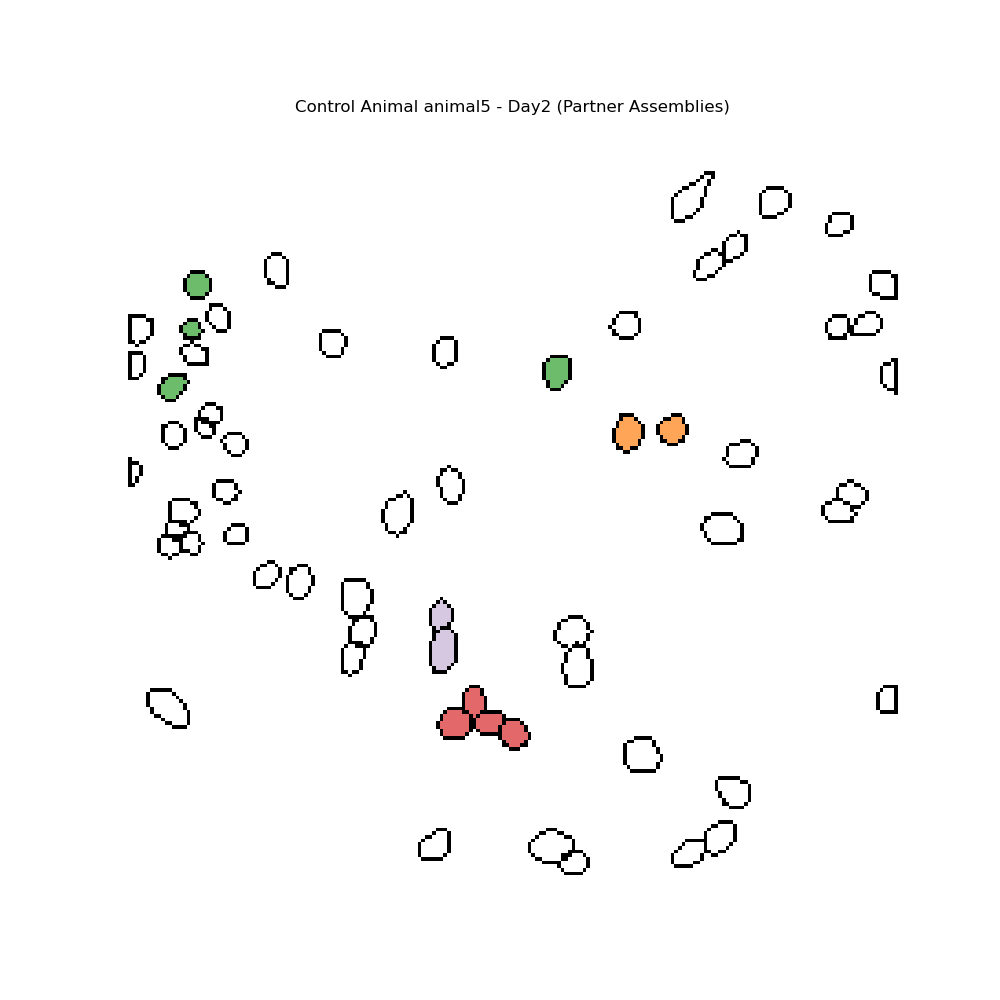

In [46]:
# Iterate through each animal in control and experimental groups and plot ensemble members
for group in ['control']: #['expt']
    for animal_id in ['animal5']:
            plot_ensemble_members(
                data_groups_d2, 
                ensemble_spatial_clustering, 
                group, 
                animal_id, 
                marker_size=10, 
                save_dir=figDataSaveDir + '/imagingInhib_population', 
                filename=f'{group}_ensemble_{animal_id}_day2'
            )

### ensemble SVMs

In [47]:
def SVM_assemblies(assemblies_data, n_shuffles=500, plot_results=False, what_to_plot='all', n_splits=10):
    results = {
        'control': [],
        'expt': []
    }

    for group in ['control','expt']:
        for animal_id in assemblies_data[group]:
            if 'day2' in assemblies_data[group][animal_id]:
                session_data = assemblies_data[group][animal_id]['day2']
                activations = session_data['activations']
                cv = session_data['cv']
                num_assemblies = session_data['num_assemblies']
                num_neurons = session_data['num_neurons']
                partner_side = session_data.get('partner_side', None)
                
                # Determine partner and novel sides based on partner_side
                if partner_side == 'left':
                    partner_area = 'Left'
                    novel_area = 'Right'
                elif partner_side == 'right':
                    partner_area = 'Right'
                    novel_area = 'Left'
                else:
                    print(f"Skipping animal {animal_id} due to invalid partner_side: {partner_side}")
                    continue

                partner_event_type = [f'Area:Mouse 1 Center In {partner_area} chamber']
                partner_vectors, partner_event_indices = generate_event_vectors(cv, activations, None, partner_event_type)
                novel_event_type = [f'Area:Mouse 1 Center In {novel_area} chamber']
                novel_vectors, novel_event_indices = generate_event_vectors(cv, activations, None, novel_event_type)

                if partner_vectors.size == 0 or novel_vectors.size == 0:
                    print(f"Skipping animal {animal_id} due to empty vectors.")
                    continue
                
                # Prepare data
                X = np.vstack((partner_vectors, novel_vectors))
                y = np.hstack((np.ones(len(partner_vectors)), np.zeros(len(novel_vectors))))
                
                # Check sample sizes before applying StratifiedKFold
                if len(partner_vectors) < n_splits or len(novel_vectors) < n_splits:
                    print(f"Skipping animal {animal_id} due to insufficient samples for n_splits={n_splits}.")
                    continue
                    
                # K-Fold Cross-Validation
                skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
                f1_scores = []
                
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    
                    svm = SVC(kernel='linear', random_state=42, probability=False, class_weight=None)
                    svm.fit(X_train, y_train)
                    
                    y_pred = svm.predict(X_test)
                    f1_scores.append(f1_score(y_test, y_pred))
                
                # Average metrics across folds
                avg_f1 = np.mean(f1_scores)

                
                # Null F1 scores and AUC calculation
                null_f1_scores = []
                null_auc_scores = []
                for shift in range(n_shuffles):  # Generate null distributions
                    shift_amount = np.random.randint(1, activations.shape[1])
                    partner_vectors_shifted, _ = generate_event_vectors(cv, np.roll(activations, shift_amount, axis=1), None, partner_event_type)
                    novel_vectors_shifted, _ = generate_event_vectors(cv, np.roll(activations, shift_amount, axis=1), None, novel_event_type)
                
                    if partner_vectors_shifted.size == 0 or novel_vectors_shifted.size == 0:
                        continue  # Skip if shifted vectors are empty
                
                    X_shifted = np.vstack((partner_vectors_shifted, novel_vectors_shifted))
                    y_shifted = np.hstack((np.ones(len(partner_vectors_shifted)), np.zeros(len(novel_vectors_shifted))))
                
                    try:
                        X_train_shifted, X_test_shifted, y_train_shifted, y_test_shifted = train_test_split(
                            X_shifted, y_shifted, test_size=0.2, random_state=42, stratify=y_shifted
                        )
                        svm_shifted = SVC(kernel='linear', random_state=42, probability=False, class_weight=None)
                        svm_shifted.fit(X_train_shifted, y_train_shifted)
                
                        y_pred_shifted = svm_shifted.predict(X_test_shifted)
                        f1_shifted = f1_score(y_test_shifted, y_pred_shifted)
                
                        null_f1_scores.append(f1_shifted)
                    except ValueError as e:
                        print(f"Error during null distribution computation: {e}")
                        continue
                
                # Compute averages for null F1 and AUC
                avg_null_f1 = np.mean(null_f1_scores) if null_f1_scores else None
                
                # Append results with all metrics
                results[group].append((animal_id, avg_f1, avg_null_f1, num_neurons))
                print(f"Group: {group}, Animal: {animal_id}, Avg F1: {avg_f1}, Avg Null F1: {avg_null_f1}")

    return results





In [48]:
def plot_decoder(results, save_dir=None, filename_prefix=None, minCells=3):
    fig, ax = plt.subplots(figsize=(10, 5))
    t_test_results = {}
    
    colors = {'control': '#048BA8', 'expt': '#D31F30'}
    
    # Filter and extract scores, null scores, and number of neurons
    control_data = [(f1, null_f1, num_neurons) for _, f1, null_f1, num_neurons in results['control'] if num_neurons > minCells - 1]
    expt_data = [(f1, null_f1, num_neurons) for _, f1, null_f1, num_neurons in results['expt'] if num_neurons > minCells - 1]

    control_f1, control_null_f1 = zip(*[(f1, null_f1) for f1, null_f1, _ in control_data]) if control_data else ([], [])
    expt_f1, expt_null_f1 = zip(*[(f1, null_f1) for f1, null_f1, _ in expt_data]) if expt_data else ([], [])
    
    control_scores, control_null_scores = control_f1, control_null_f1
    expt_scores, expt_null_scores = expt_f1, expt_null_f1
    score_name = 'F1'

    print(f"Control {score_name} scores:", control_scores)
    print(f"Control Null {score_name} scores:", control_null_scores)
    print(f"Expt {score_name} scores:", expt_scores)

    # Combine all null scores
    all_null_scores = list(control_null_scores) + list(expt_null_scores)
    avg_null_score = np.nanmean(all_null_scores) if all_null_scores else np.nan
    se_null_score = np.nanstd(all_null_scores) / np.sqrt(len(all_null_scores)) if all_null_scores else np.nan
    
    # Perform non-parametric tests
    if control_scores and expt_scores:
        # Mann-Whitney U test for independent samples
        u_stat_control_expt, p_value_control_expt = mannwhitneyu(control_scores, expt_scores, alternative='two-sided')
        t_test_results['control_vs_expt'] = (u_stat_control_expt, p_value_control_expt)
    else:
        t_test_results['control_vs_expt'] = (np.nan, np.nan)
    
    # Initialize variables for paired t-tests
    t_stat_control_null, p_value_control_null = np.nan, np.nan
    t_stat_expt_null, p_value_expt_null = np.nan, np.nan
    
    if control_scores and control_null_scores:
        # Paired t-test for control vs null scores
        try:
            t_stat_control_null, p_value_control_null = ttest_rel(
                control_scores, control_null_scores, nan_policy='omit'
            )
        except ValueError:
            t_stat_control_null, p_value_control_null = (np.nan, np.nan)
    
    if expt_scores and expt_null_scores:
        # Paired t-test for experimental vs null scores
        try:
            t_stat_expt_null, p_value_expt_null = ttest_rel(
                expt_scores, expt_null_scores, nan_policy='omit'
            )
        except ValueError:
            t_stat_expt_null, p_value_expt_null = (np.nan, np.nan)
    
    # Print test results
    print(f'Control vs Expt {score_name} Scores - Day 2: statistic = {t_test_results["control_vs_expt"][0]}, p-value = {t_test_results["control_vs_expt"][1]}')
    print(f'Control vs Null {score_name} Scores - Day 2: statistic = {t_stat_control_null}, p-value = {p_value_control_null}')
    print(f'Expt vs Null {score_name} Scores - Day 2: statistic = {t_stat_expt_null}, p-value = {p_value_expt_null}')


    # Plot scores with jitter
    x_jitter = 0.025
    ax.scatter(np.random.normal(0, x_jitter, len(control_scores)), control_scores, color=colors['control'], alpha=0.7, s=50, label='Control')
    ax.scatter(np.random.normal(1, x_jitter, len(expt_scores)), expt_scores, color=colors['expt'], alpha=0.7, s=50, label='Expt')
    
    if control_scores:
        control_mean = np.nanmean(control_scores)
        control_se = np.nanstd(control_scores) / np.sqrt(len(control_scores))
        ax.errorbar([0], [control_mean], yerr=[control_se], fmt='', color=colors['control'], capsize=5)
    
    if expt_scores:
        expt_mean = np.nanmean(expt_scores)
        expt_se = np.nanstd(expt_scores) / np.sqrt(len(expt_scores))
        ax.errorbar([1], [expt_mean], yerr=[expt_se], fmt='', color=colors['expt'], capsize=5)
    
    ax.axhline(avg_null_score, color='black', linestyle='--', linewidth=1, label=f'Average Null {score_name} = {avg_null_score:.4f}')
    ax.fill_between([-0.5, 1.5], avg_null_score - se_null_score, avg_null_score + se_null_score, color='black', alpha=0.2)
    ax.grid(False)
    ax.set_title(f'Decoder {score_name} Scores - Day 2')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'Control Actual {score_name}', f'Expt Actual {score_name}'])
    ax.set_ylabel(f'Decoder {score_name} Score')
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.5, 1.5)
    ax.legend()
    plt.tight_layout()
    
    if save_dir and filename_prefix:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path_svg = os.path.join(save_dir, f'{filename_prefix}_day2_decoder.svg')
        save_path_png = os.path.join(save_dir, f'{filename_prefix}_day2_decoder.png')
        csv_path = os.path.join(save_dir, f'{filename_prefix}_day2_decoder_data.csv')

        # Save plot
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        print(f"Plots saved as {save_path_svg} and {save_path_png}")

        # Save data to CSV
        data = {
            'Control Scores': control_scores,
            'Control Null Scores': control_null_scores,
            'Expt Scores': expt_scores,
            'Expt Null Scores': expt_null_scores,
        }
        pd.DataFrame.from_dict(data, orient='index').transpose().to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")
    
    plt.show()
    
    # Print number of animals
    print(f'Number of Control animals: {len(control_scores)}')
    print(f'Number of Expt animals: {len(expt_scores)}')



In [49]:
svm_assemblies = SVM_assemblies(assemblies_data_day2, n_splits=10)

Group: control, Animal: animal1, Avg F1: 0.5926190476190476, Avg Null F1: 0.5153416814695452
Group: control, Animal: animal2, Avg F1: 0.7133613445378152, Avg Null F1: 0.6373783035167531
Group: control, Animal: animal3, Avg F1: 0.6133333333333333, Avg Null F1: 0.5707070596070596
Group: control, Animal: animal4, Avg F1: 0.7600177763413056, Avg Null F1: 0.6621571590847457
Group: control, Animal: animal5, Avg F1: 0.7014141414141414, Avg Null F1: 0.5674922891833244
Group: control, Animal: animal6, Avg F1: 0.6000000000000001, Avg Null F1: 0.5732160173160173
Group: control, Animal: animal7, Avg F1: 0.5662825409884233, Avg Null F1: 0.49215064269864395
Group: control, Animal: animal8, Avg F1: 0.4133333333333333, Avg Null F1: 0.38975238095238096
Group: expt, Animal: animal1, Avg F1: 0.5585714285714286, Avg Null F1: 0.5776750471750473
Group: expt, Animal: animal2, Avg F1: 0.5861904761904762, Avg Null F1: 0.6503259629259628
Group: expt, Animal: animal3, Avg F1: 0.5276190476190477, Avg Null F1: 0.5

Control F1 scores: (0.5926190476190476, 0.7133613445378152, 0.6133333333333333, 0.7600177763413056, 0.7014141414141414, 0.6000000000000001, 0.5662825409884233, 0.4133333333333333)
Control Null F1 scores: (0.5153416814695452, 0.6373783035167531, 0.5707070596070596, 0.6621571590847457, 0.5674922891833244, 0.5732160173160173, 0.49215064269864395, 0.38975238095238096)
Expt F1 scores: (0.5585714285714286, 0.5861904761904762, 0.5276190476190477, 0.6544122544122544, 0.5838095238095238, 0.51, 0.35)
Control vs Expt F1 Scores - Day 2: statistic = 44.0, p-value = 0.0721056721056721
Control vs Null F1 Scores - Day 2: statistic = 5.235661377014316, p-value = 0.0012049595292890642
Expt vs Null F1 Scores - Day 2: statistic = 0.23573667696876027, p-value = 0.8214774646657654
Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_day2_assemblies_day2_decoder.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\Int

C:\Users\ephys\AppData\Local\Temp\ipykernel_28548\2542366166.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))


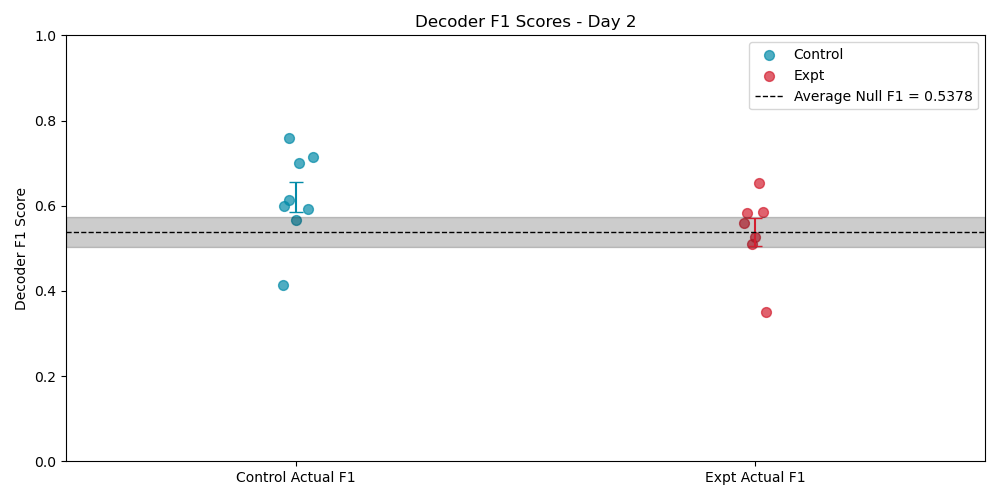

Number of Control animals: 8
Number of Expt animals: 7


In [50]:
plot_decoder(svm_assemblies, save_dir=figDataSaveDir + '/imagingInhib_population', filename_prefix='svm_day2_assemblies')

### cell SVM

In [51]:
def SVM_neurons(data_groups, numShuffles=500, n_splits=10):
    results = {
        'control': [],
        'expt': []
    }

    
    for group in ['control','expt']:
        for animal_id in data_groups[group]:
            if 'day2' in data_groups[group][animal_id]:
                session_data = data_groups[group][animal_id]['day2']
                C_final = session_data['C_final']
                cv = session_data['cv']


                # Retrieve partner side information
                side_info = session_data.get('partner_side', None)
                if side_info is None:
                    print(f"Skipping animal {animal_id} due to missing partner side information.")
                    continue

                # Define partner and novel areas
                if side_info == 'left':
                    partner_area, novel_area = 'Left', 'Right'
                elif side_info == 'right':
                    partner_area, novel_area = 'Right', 'Left'
                else:
                    print(f"Skipping animal {animal_id} due to invalid partner_side: {side_info}")
                    continue

                # Extract event vectors
                partner_event_type = [f'Area:Mouse 1 Center In {partner_area} chamber']
                novel_event_type = [f'Area:Mouse 1 Center In {novel_area} chamber']
                partner_vectors, _ = generate_event_vectors(cv, C_final, None, partner_event_type)
                novel_vectors, _ = generate_event_vectors(cv, C_final, None, novel_event_type)

                if partner_vectors.size == 0 or novel_vectors.size == 0:
                    print(f"Skipping animal {animal_id} due to empty vectors.")
                    continue

                # Prepare data
                X = np.vstack((partner_vectors, novel_vectors))
                y = np.hstack((np.ones(len(partner_vectors)), np.zeros(len(novel_vectors))))

                # Check sample sizes before applying StratifiedKFold
                if len(partner_vectors) < n_splits or len(novel_vectors) < n_splits:
                    print(f"Skipping animal {animal_id} due to insufficient samples for n_splits={n_splits}.")
                    continue

                # K-Fold Cross-Validation
                skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
                f1_scores = []
                auc_scores = []

                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    svm = SVC(kernel='linear', random_state=42, probability=False, class_weight=None)
                    svm.fit(X_train, y_train)

                    y_pred = svm.predict(X_test)
                    f1_scores.append(f1_score(y_test, y_pred))

                # Average metrics across folds
                avg_f1 = np.mean(f1_scores)

                # Null F1 scores and AUC calculation
                null_f1_scores = []
                for shift in range(numShuffles):
                    shift_amount = np.random.randint(1, C_final.shape[1])
                    partner_vectors_shifted, _ = generate_event_vectors(cv, np.roll(C_final, shift_amount, axis=1), None, partner_event_type)
                    novel_vectors_shifted, _ = generate_event_vectors(cv, np.roll(C_final, shift_amount, axis=1), None, novel_event_type)

                    if partner_vectors_shifted.size == 0 or novel_vectors_shifted.size == 0:
                        continue

                    X_shifted = np.vstack((partner_vectors_shifted, novel_vectors_shifted))
                    y_shifted = np.hstack((np.ones(len(partner_vectors_shifted)), np.zeros(len(novel_vectors_shifted))))

                    try:
                        X_train_shifted, X_test_shifted, y_train_shifted, y_test_shifted = train_test_split(
                            X_shifted, y_shifted, test_size=0.2, random_state=42, stratify=y_shifted
                        )
                        svm_shifted = SVC(kernel='linear', random_state=42, probability=False, class_weight=None)
                        svm_shifted.fit(X_train_shifted, y_train_shifted)

                        y_pred_shifted = svm_shifted.predict(X_test_shifted)
                        f1_shifted = f1_score(y_test_shifted, y_pred_shifted)

                        null_f1_scores.append(f1_shifted)
                    except ValueError:
                        continue

                avg_null_f1 = np.mean(null_f1_scores) if null_f1_scores else None

                # Append results
                results[group].append((animal_id, avg_f1, avg_null_f1, C_final.shape[0]))
                print(f"Group: {group}, Animal: {animal_id}, Avg F1: {avg_f1:.4f}, Avg Null F1: {avg_null_f1}")

    return results

In [52]:
svm_neurons = SVM_neurons(data_groups_d2, n_splits=10)

Group: control, Animal: animal1, Avg F1: 0.9238, Avg Null F1: 0.5072816298940137
Group: control, Animal: animal2, Avg F1: 0.6762, Avg Null F1: 0.6613389296253015
Group: control, Animal: animal3, Avg F1: 0.6517, Avg Null F1: 0.5119516927516927
Group: control, Animal: animal4, Avg F1: 0.9106, Avg Null F1: 0.5704836133469007
Group: control, Animal: animal5, Avg F1: 0.9045, Avg Null F1: 0.5180884071974151
Group: control, Animal: animal6, Avg F1: 0.7600, Avg Null F1: 0.4825253968253968
Group: control, Animal: animal7, Avg F1: 0.7561, Avg Null F1: 0.47009669535830806
Group: control, Animal: animal8, Avg F1: 0.5800, Avg Null F1: 0.2992095238095238
Group: expt, Animal: animal1, Avg F1: 0.5205, Avg Null F1: 0.5806454767454767
Group: expt, Animal: animal2, Avg F1: 0.7890, Avg Null F1: 0.5957061605061604
Group: expt, Animal: animal3, Avg F1: 0.6059, Avg Null F1: 0.5606065342466271
Group: expt, Animal: animal4, Avg F1: 0.8488, Avg Null F1: 0.6123984278897943
Group: expt, Animal: animal5, Avg F1: 0

Control F1 scores: (0.9238095238095237, 0.6761904761904762, 0.6516666666666666, 0.9106160506160507, 0.9045454545454547, 0.76, 0.7561138861138861, 0.58)
Control Null F1 scores: (0.5072816298940137, 0.6613389296253015, 0.5119516927516927, 0.5704836133469007, 0.5180884071974151, 0.4825253968253968, 0.47009669535830806, 0.2992095238095238)
Expt F1 scores: (0.5204761904761905, 0.7890476190476191, 0.605873015873016, 0.848845598845599, 0.6963564213564213, 0.6433333333333333, 0.5)
Control vs Expt F1 Scores - Day 2: statistic = 41.0, p-value = 0.151981351981352
Control vs Null F1 Scores - Day 2: statistic = 5.726647730677061, p-value = 0.0007154009479504675
Expt vs Null F1 Scores - Day 2: statistic = 2.1116379042420466, p-value = 0.07919332526784995
Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_day2_neurons_day2_decoder.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\

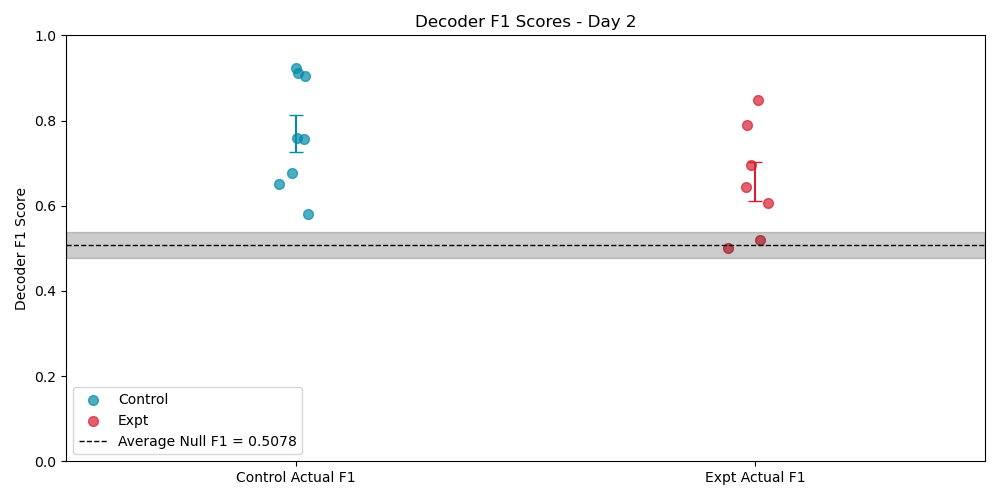

Number of Control animals: 8
Number of Expt animals: 7


In [53]:
plot_decoder(svm_neurons, save_dir=figDataSaveDir + '/imagingInhib_population', filename_prefix='svm_day2_neurons')

In [54]:
def visualize_truth_and_predictions_with_mismatch_lines(
    event_indices, true_labels, predictions, title, save_dir=None, filename_prefix=None
):
    """
    Visualize ground truth and predictions with mismatches highlighted.
    Parameters:
    - event_indices: list of event times
    - true_labels: list of ground truth labels (1 for partner, 0 for novel)
    - predictions: list of predicted labels (1 for partner, 0 for novel)
    - title: title for the plot
    """

    plt.figure(figsize=(12, 4))
    
    # Define y positions for actual and predicted events
    y_actual = 1.1
    y_predicted = 0.9
    
    # Define colors
    partner_color = "#048BA8"  # Teal for partner
    novel_color = "#D31F30"  # Red for novel
    
    # Separate true P, true N, predicted P, predicted N
    true_P = sorted([time for time, label in zip(event_indices, true_labels) if label == 1])
    true_N = sorted([time for time, label in zip(event_indices, true_labels) if label == 0])
    predicted_P = sorted([time for time, label in zip(event_indices, predictions) if label == 1])
    predicted_N = sorted([time for time, label in zip(event_indices, predictions) if label == 0])
    
    # Plot actual labels
    for time, truth in zip(event_indices, true_labels):
        color = partner_color if truth == 1 else novel_color
        plt.scatter(time, y_actual, color=color, edgecolor=None, s=50, label="Truth" if time == event_indices[0] else None)
    
    # Plot predictions
    for time, pred in zip(event_indices, predictions):
        color = partner_color if pred == 1 else novel_color
        plt.scatter(time, y_predicted, color=color, edgecolor=None, s=50, label="Prediction" if time == event_indices[0] else None)
    
    # Draw mismatch lines
    for time, truth, pred in zip(event_indices, true_labels, predictions):
        if truth != pred:
            plt.plot([time, time], [y_actual, y_predicted], color="black", lw=1.5)
    
    # Customize plot
    plt.xlabel("Event Times", fontsize=12, fontweight="bold")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.ylim(0.8, 1.2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    plt.grid(False)
    
    plt.tight_layout()
    
    if save_dir and filename_prefix:
        # Save plot
        save_path_svg = os.path.join(save_dir, f'{filename_prefix}_SVM_example_viz.svg')
        save_path_png = os.path.join(save_dir, f'{filename_prefix}_SVM_example_viz.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        print(f"Plots saved as {save_path_svg} and {save_path_png}")
        
        # CSV 1: Separate Columns
        csv_path_separate = os.path.join(save_dir, f'{filename_prefix}_SVM_results_separate_columns.csv')
        max_length = max(len(true_P), len(true_N), len(predicted_P), len(predicted_N))
        padded_true_P = true_P + [""] * (max_length - len(true_P))
        padded_true_N = true_N + [""] * (max_length - len(true_N))
        padded_predicted_P = predicted_P + [""] * (max_length - len(predicted_P))
        padded_predicted_N = predicted_N + [""] * (max_length - len(predicted_N))
        with open(csv_path_separate, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["True P Event Times", "True N Event Times", "Predicted P Event Times", "Predicted N Event Times"])
            for row in zip(padded_true_P, padded_true_N, padded_predicted_P, padded_predicted_N):
                writer.writerow(row)
        print(f"CSV saved as {csv_path_separate}")
        
        # CSV 2: Combined Format
        csv_path_combined = os.path.join(save_dir, f'{filename_prefix}_SVM_results_combined.csv')
        with open(csv_path_combined, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["True Event Time", "True Label (P/N)", "Predicted Event Time", "Predicted Label (P/N)"])
            for t_time, t_label, p_time, p_label in zip(event_indices, true_labels, event_indices, predictions):
                writer.writerow([t_time, "P" if t_label == 1 else "N", p_time, "P" if p_label == 1 else "N"])
        print(f"CSV saved as {csv_path_combined}")

    plt.show()


def SVM_neurons_with_temporal_visualization(
    data_groups, example_animal_id, numShuffles=500, n_splits=5, saveDir=None, filename_prefix=None
):
    """
    Perform SVM decoding and visualize predictions for a specified animal with debugging.
    """
    results = {"control": [], "expt": []}

    for group in ["control", "expt"]:
        for animal_id in data_groups[group]:
            if "day2" in data_groups[group][animal_id]:
                session_data = data_groups[group][animal_id]["day2"]
                C_final = session_data["C_final"]
                cv = session_data["cv"]

                # Define partner and novel areas
                side_info = session_data.get("partner_side", None)
                if side_info == "left":
                    partner_area, novel_area = "Left", "Right"
                elif side_info == "right":
                    partner_area, novel_area = "Right", "Left"
                else:
                    print(f"Skipping animal {animal_id} due to invalid or missing partner_side.")
                    continue

                # Extract partner and novel event vectors
                partner_event_type = [f"Area:Mouse 1 Center In {partner_area} chamber"]
                novel_event_type = [f"Area:Mouse 1 Center In {novel_area} chamber"]

                partner_vectors, partner_event_indices = generate_event_vectors(cv, C_final, None, partner_event_type)
                novel_vectors, novel_event_indices = generate_event_vectors(cv, C_final, None, novel_event_type)

                if partner_vectors.size == 0 or novel_vectors.size == 0:
                    print(f"Skipping animal {animal_id} due to empty vectors.")
                    continue

                X = np.vstack((partner_vectors, novel_vectors))
                y = np.hstack((np.ones(len(partner_vectors)), np.zeros(len(novel_vectors))))

                # Check sample size for StratifiedKFold
                if len(partner_vectors) < n_splits or len(novel_vectors) < n_splits:
                    print(f"Skipping animal {animal_id} due to insufficient samples for n_splits={n_splits}.")
                    continue

                # Stratified K-Fold Cross-Validation
                skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
                y_pred_all, test_indices_all = [], []
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    svm = SVC(kernel="linear", random_state=42, probability=False)
                    svm.fit(X_train, y_train)

                    y_pred_all.extend(svm.predict(X_test))
                    test_indices_all.extend(test_index)

                # Ensure proper alignment of indices
                test_indices_all = np.array(test_indices_all)
                y_pred_all = np.array(y_pred_all)

                valid_event_times = []
                valid_true_labels = []
                valid_predictions = []
                
                # Align test indices with event times, ensuring valid dimensions
                for i, idx in enumerate(test_indices_all):
                    if idx < len(partner_event_indices):
                        valid_event_times.append(np.mean(partner_event_indices[idx]))  # Average for tuple
                        valid_true_labels.append(y[idx])
                        valid_predictions.append(y_pred_all[i])
                    elif idx - len(partner_event_indices) < len(novel_event_indices):
                        valid_event_times.append(np.mean(novel_event_indices[idx - len(partner_event_indices)]))  # Average for tuple
                        valid_true_labels.append(y[idx])
                        valid_predictions.append(y_pred_all[i])
                
                # Ensure all lists are aligned and same length
                valid_event_times = np.array(valid_event_times)
                valid_true_labels = np.array(valid_true_labels)
                valid_predictions = np.array(valid_predictions)
                assert len(valid_event_times) == len(valid_true_labels) == len(valid_predictions), "Misaligned data!"

                # Debugging: Print alignment of predictions and truth
                if animal_id == example_animal_id and group=='control':

                    visualize_truth_and_predictions_with_mismatch_lines(
                        event_indices=valid_event_times,
                        true_labels=valid_true_labels,
                        predictions=valid_predictions,
                        title=f"SVM Predictions for {example_animal_id}",
                        save_dir = saveDir,
                        filename_prefix = filename_prefix
                    )

    return results


Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_predictions_example_SVM_example_viz.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_predictions_example_SVM_example_viz.png
CSV saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_predictions_example_SVM_results_separate_columns.csv
CSV saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\svm_predictions_example_SVM_results_combined.csv


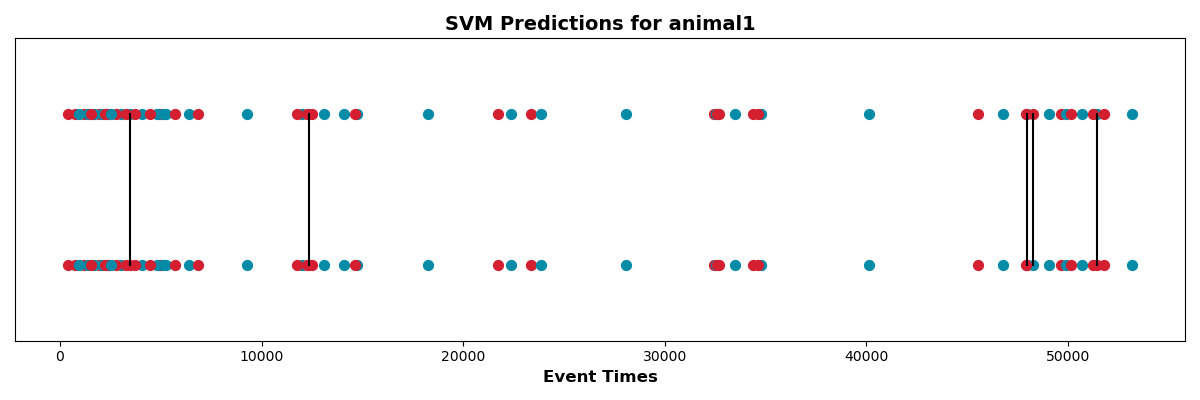

In [55]:
svm_neurons = SVM_neurons_with_temporal_visualization(data_groups_d2, 'animal1', n_splits=10,
    saveDir=figDataSaveDir + '/imagingInhib_population',
    filename_prefix='svm_predictions_example'
)ssss

### PCA

In [86]:
def calculate_pca_behavior_epochs_group(data_groups_d01, data_groups_d2, behavior_label_day0_1, context_day2_14, Smooth=False, smoothLength=5, num_pcs=5):
    """
    Calculate PCA for behavior epochs independently for day0, day1, and day2, without aligning neurons across sessions.

    Args:
        data_groups_d01: dict containing day0 and day1 data for control and expt groups.
        data_groups_d2: dict containing day2 data for control and expt groups.
        behavior_label_day0_1: str, behavior label for days 0 and 1.
        context_day2_14: str, 'partner', 'novel', or 'social' for day2.
        Smooth: bool, whether to smooth the calcium data.
        smoothLength: int, smoothing window size.
        num_pcs: int, number of PCs to retain for variance explained.

    Returns:
        tuple: (results, variance_explained_results)
    """
    results = {
        'control': { 'day0': [], 'day1': [], 'day2': [] },
        'expt': { 'day0': [], 'day1': [], 'day2': [] }
    }

    variance_explained_results = {
        'control': { 'day0': [], 'day1': [], 'day2': [] },
        'expt': { 'day0': [], 'day1': [], 'day2': [] }
    }

    # Process days 0 and 1 from data_groups_d01
    for group in ['control', 'expt']:
        for day in ['day0', 'day1']:
            for animal_id, session_data in data_groups_d01[group].items():
                if day in session_data:
                    # Extract calcium and behavior data
                    C_final = session_data[day]['C_final']
                    cv = session_data[day]['cv']
                    total_frames = C_final.shape[1]

                    if Smooth:
                        C_final = smooth_data(C_final, smoothLength)

                    # Generate labels
                    labels = generate_labels_from_cv(cv, total_frames, behavior_label_day0_1)

                    # Identify behavior bouts
                    behavior_bouts = []
                    current_bout = []
                    for frame in range(len(labels)):
                        if labels[frame] == 1:
                            current_bout.append(frame)
                        elif current_bout:
                            behavior_bouts.append(current_bout)
                            current_bout = []
                    if current_bout:
                        behavior_bouts.append(current_bout)

                    # Average neural activity across behavior bouts
                    bout_averages = []
                    for bout in behavior_bouts:
                        bout_data = C_final[:, bout]
                        bout_average = np.mean(bout_data, axis=1)
                        bout_averages.append(bout_average)
                    bout_averages = np.array(bout_averages).T

                    if bout_averages.shape[1] > 0 and np.var(bout_averages) > 0:
                        # Perform PCA
                        pca = PCA()
                        pca.fit(bout_averages.T)
                        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
                        num_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
                        normalized_components = num_components / bout_averages.shape[0]

                        results[group][day].append(normalized_components)

                        variance_explained = pca.explained_variance_ratio_[:num_pcs]
                        variance_explained_results[group][day].append(variance_explained)
                    else:
                        results[group][day].append(np.nan)
                        variance_explained_results[group][day].append(np.zeros(num_pcs))

    # Process day2 from data_groups_d2
    for group in ['control', 'expt']:
        for animal_id, session_data in data_groups_d2[group].items():
            if 'day2' in session_data:
                # Extract calcium and behavior data
                C_final = session_data['day2']['C_final']
                cv = session_data['day2']['cv']
                total_frames = C_final.shape[1]

                if Smooth:
                    C_final = smooth_data(C_final, smoothLength)

                # Generate labels based on the context
                side_info = session_data.get('partner_side')
                if context_day2_14 == 'partner':
                    event_type = f'Area:Mouse 1 Center In {side_info.capitalize()} chamber'
                elif context_day2_14 == 'novel':
                    opposite_side = 'Right' if side_info == 'left' else 'Left'
                    event_type = f'Area:Mouse 1 Center In {opposite_side} chamber'
                elif context_day2_14 == 'social':
                    event_type = [
                        'Area:Mouse 1 Center In Left chamber',
                        'Area:Mouse 1 Center In Right chamber'
                    ]
                labels = generate_labels_from_cv(cv, total_frames, None, event_type)

                # Identify behavior bouts
                behavior_bouts = []
                current_bout = []
                for frame in range(len(labels)):
                    if labels[frame] == 1:
                        current_bout.append(frame)
                    elif current_bout:
                        behavior_bouts.append(current_bout)
                        current_bout = []
                if current_bout:
                    behavior_bouts.append(current_bout)

                # Average neural activity across behavior bouts
                bout_averages = []
                for bout in behavior_bouts:
                    bout_data = C_final[:, bout]
                    bout_average = np.mean(bout_data, axis=1)
                    bout_averages.append(bout_average)
                bout_averages = np.array(bout_averages).T

                if bout_averages.shape[1] > 0 and np.var(bout_averages) > 0:
                    # Perform PCA
                    pca = PCA()
                    pca.fit(bout_averages.T)
                    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
                    num_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
                    normalized_components = num_components / bout_averages.shape[0]

                    results[group]['day2'].append(normalized_components)

                    variance_explained = pca.explained_variance_ratio_[:num_pcs]
                    variance_explained_results[group]['day2'].append(variance_explained)
                else:
                    results[group]['day2'].append(np.nan)
                    variance_explained_results[group]['day2'].append(np.zeros(num_pcs))

    return results, variance_explained_results
    
def plot_principal_components(results, variance_explained_results, save_dir=None, filename_prefix=None, num_pcs=5):
    fig, axes = plt.subplots(5, len(results['control'].keys()), figsize=(10, 15), sharey='row')
    days = ['day0', 'day1', 'day2']
    
    day0_day1_colors = {'control': '#E49925', 'expt': '#482E8D'}
    day2_colors = {'control': '#048BA8', 'expt': '#D31F30'}

    pc1_3_cumulative_variance = {'control': {}, 'expt': {}}
    normalized_pcs = {'control': {}, 'expt': {}}
    model_data = []

    for i, day in enumerate(days):
        control_data = results['control'][day]
        expt_data = results['expt'][day]
        colors = day2_colors if day == 'day2' else day0_day1_colors
        
        sns.stripplot(data=[control_data, expt_data], ax=axes[0, i], dodge=True, jitter=True, palette=[colors['control'], colors['expt']])
        
        for j, (group, data) in enumerate([('control', control_data), ('expt', expt_data)]):
            if data:
                mean = np.nanmean(data)
                se = np.nanstd(data) / np.sqrt(len(data))
                axes[0, i].errorbar([j], [mean], yerr=[se], fmt='o', color=colors[group], capsize=5)
                normalized_pcs[group][day] = {'mean': mean, 'se': se, 'data': data}
        
        axes[0, i].set_title(f'PCs - {day.capitalize()}')
        axes[0, i].set_xticks([0, 1])
        axes[0, i].set_xticklabels(['Control', 'Expt'])

        def process_variance_data(group_data):
            processed_data = []
            for var in group_data:
                if np.isscalar(var) and np.isnan(var):
                    processed_data.append(np.full(num_pcs, np.nan))
                elif np.all(var == 0):
                    processed_data.append(np.full(num_pcs, np.nan))
                else:
                    processed_data.append(np.pad(var[:num_pcs], (0, max(0, num_pcs - len(var))), constant_values=np.nan))
            return np.array(processed_data)

        control_variance_data = process_variance_data(variance_explained_results['control'][day])
        expt_variance_data = process_variance_data(variance_explained_results['expt'][day])

        for j, (group, data) in enumerate([('control', control_variance_data), ('expt', expt_variance_data)]):
            if data.size > 0:
                means = np.nanmean(data, axis=0)
                ses = np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))
                axes[1, i].bar(np.arange(num_pcs) + (0.2 if j else -0.2), means, yerr=ses, width=0.4, capsize=5, color=colors[group])
                pc1_3_sum = np.sum(data[:, :3], axis=1)
                pc1_3_cumulative_variance[group][day] = {'mean': np.sum(means[:3]), 'se': np.sqrt(np.sum(ses[:3]**2)), 'data': pc1_3_sum}
                
                for k, (norm_pc, pc1_3_var) in enumerate(zip(results[group][day], pc1_3_sum)):
                    if not (np.isnan(norm_pc) or np.isnan(pc1_3_var)):
                        model_data.append({
                            'Group': group,
                            'Day': day,
                            'Animal': f"{group}_{day}_{k}",
                            'NormalizedPCs': norm_pc,
                            'PC1_3Variance': pc1_3_var
                        })

        axes[1, i].set_title(f'Variance Explained - {day.capitalize()}')
        axes[1, i].set_xticks(np.arange(num_pcs))
        axes[1, i].set_xticklabels([f'PC{i+1}' for i in range(num_pcs)])

        for j, (group, data) in enumerate([('control', control_variance_data), ('expt', expt_variance_data)]):
            if data.size > 0:
                means = np.nanmean(data, axis=0)
                ses = np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))
                cumulative_variance = np.nancumsum(means)
                cumulative_se = np.sqrt(np.nancumsum(ses**2))
                axes[2, i].errorbar(np.arange(num_pcs), cumulative_variance, yerr=cumulative_se, fmt='-o', capsize=5, color=colors[group])

        axes[2, i].set_title(f'Cumulative Variance - {day.capitalize()}')
        axes[2, i].set_xticks(np.arange(num_pcs))
        axes[2, i].set_xticklabels([f'PC{i+1}' for i in range(num_pcs)])

    pc1_3_data = []
    norm_pcs_data = []
    for day in days:
        colors = day2_colors if day == 'day2' else day0_day1_colors
        for group in ['control', 'expt']:
            pc1_3_data.extend([
                (d, group, day, colors[group]) 
                for d in pc1_3_cumulative_variance[group][day]['data']
            ])
            norm_pcs_data.extend([
                (d, group, day, colors[group]) 
                for d in normalized_pcs[group][day]['data']
            ])

    pc1_3_df = pd.DataFrame(pc1_3_data, columns=['value', 'group', 'day', 'color'])
    norm_pcs_df = pd.DataFrame(norm_pcs_data, columns=['value', 'group', 'day', 'color'])

    sns.boxplot(data=pc1_3_df, x='day', y='value', hue='group', ax=axes[3, 0],
                palette=[pc1_3_df[pc1_3_df['group'] == g]['color'].iloc[0] for g in ['control', 'expt']])
    axes[3, 0].set_title('PC1-3 Cumulative Variance')
    axes[3, 0].set_xlabel('Days')
    axes[3, 0].set_ylabel('Cumulative Variance')

    sns.boxplot(data=norm_pcs_df, x='day', y='value', hue='group', ax=axes[4, 0],
                palette=[norm_pcs_df[norm_pcs_df['group'] == g]['color'].iloc[0] for g in ['control', 'expt']])
    axes[4, 0].set_title('Normalized PCs')
    axes[4, 0].set_xlabel('Days')
    axes[4, 0].set_ylabel('Normalized PCs')

    for ax in axes[3:, 1:].flat:
        ax.set_visible(False)

    axes[0, 0].set_ylabel('Normalized Number of Principal Components')
    axes[1, 0].set_ylabel('% Variance Explained')
    axes[2, 0].set_ylabel('Cumulative % Variance Explained')
    axes[3, 0].set_ylabel('PC1-3 Cumulative % Variance')
    axes[4, 0].set_ylabel('Normalized Number of PCs')
    
    axes[1, 0].set_ylim(0, 1)
    axes[2, 0].set_ylim(0, 1)

    for i, ax in enumerate([axes[3, 0], axes[4, 0]]):
        boxes = [patch for patch in ax.patches if isinstance(patch, matplotlib.patches.PathPatch)]
        for j, box in enumerate(boxes):
            day_idx = j // 2
            group_idx = j % 2
            color = day2_colors['control' if group_idx == 0 else 'expt'] if day_idx == 2 else day0_day1_colors['control' if group_idx == 0 else 'expt']
            box.set_facecolor(color)
            box.set_alpha(0.7)
    
    plt.tight_layout()

    if save_dir and filename_prefix:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        hist_save_path_svg = os.path.join(save_dir, f'{filename_prefix}.svg')
        hist_save_path_png = os.path.join(save_dir, f'{filename_prefix}.png')
        plt.savefig(hist_save_path_svg, format='svg')
        plt.savefig(hist_save_path_png, format='png')
        print(f"Plots saved as {hist_save_path_svg} and {hist_save_path_png}")

    plt.show()
    
    animal_level_data = []
    for group in ['control', 'expt']:
        for day in days:
            if day in results[group] and day in variance_explained_results[group]:
                result_day = results[group][day]
                variance_day = variance_explained_results[group][day]
                
                if len(result_day) == len(variance_day):
                    for animal_idx, (norm_pc, variance) in enumerate(zip(result_day, variance_day)):
                        animal_level_data.append({
                            'Metric': 'PC1-3 Cumulative Variance',
                            'Group': group,
                            'Day': day,
                            'Animal': f"{group}_animal_{animal_idx + 1}",
                            'Value': np.sum(variance[:3]) if not np.isnan(variance).all() else np.nan
                        })
                        animal_level_data.append({
                            'Metric': 'Normalized PCs',
                            'Group': group,
                            'Day': day,
                            'Animal': f"{group}_animal_{animal_idx + 1}",
                            'Value': norm_pc
                        })
    
    if save_dir and filename_prefix:
        animal_data_path = os.path.join(save_dir, f'{filename_prefix}_animal_data.csv')
        pd.DataFrame(animal_level_data).to_csv(animal_data_path, index=False)
        print(f"Animal-level data saved to {animal_data_path}")

    def format_p_value(p_val):
        if p_val < 0.0001:
            return f"{p_val:.2e}"
        else:
            return f"{p_val:.4f}"

    def print_detailed_results(results, model_name):
        print(f"\nModel: {model_name}")
        # Extract results into a DataFrame
        params = results.params
        pvalues = results.pvalues
        conf_int = results.conf_int()
        
        # Create results DataFrame
        df_results = pd.DataFrame({
            'Coef.': params,
            'Std.Err.': results.bse,
            'z': results.tvalues,
            'P>|z|': pvalues,
            '[0.025': conf_int[0],
            '0.975]': conf_int[1]
        })
        
        # Format p-values
        df_results['P>|z|'] = df_results['P>|z|'].apply(format_p_value)
        
        # Print formatted results
        print(df_results.to_string(float_format=lambda x: '{:.4f}'.format(x)))

    df = pd.DataFrame(model_data)
    df_clean = df.dropna()

    try:
        print('\nNormalized PCs Model:')
        model_normalized = mixedlm("NormalizedPCs ~ Group * Day", groups="Animal", data=df_clean)
        results_normalized = model_normalized.fit()
        print_detailed_results(results_normalized, "Normalized PCs ~ Group * Day")
        
        print('\nFirst 3 PCs Model:')
        model_variance = mixedlm("PC1_3Variance ~ Group * Day", groups="Animal", data=df_clean)
        results_variance = model_variance.fit()
        print_detailed_results(results_variance, "PC1_3Variance ~ Group * Day")

        print('\nInteraction Model:')
        model = mixedlm("NormalizedPCs ~ PC1_3Variance + Group + Day", groups="Animal", data=df_clean)
        results = model.fit()
        print_detailed_results(results, "NormalizedPCs ~ PC1_3Variance + Group + Day")
    except Exception as e:
        print(f"\nError in fitting mixed-effects model: {str(e)}")
        results = None

    return df_clean, results

In [57]:
behavior_label_day0_1 = 'Distance between [ 2 and 1 ] Less Than  50.00 mm'
context_day2_14 = 'social'  

results_pc, variance_explained_results = calculate_pca_behavior_epochs_group(data_groups_d01, data_groups_d2, behavior_label_day0_1, context_day2_14, Smooth=True, smoothLength=5, num_pcs=10)


Plots saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\pca_over_time_mega.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\pca_over_time_mega.png


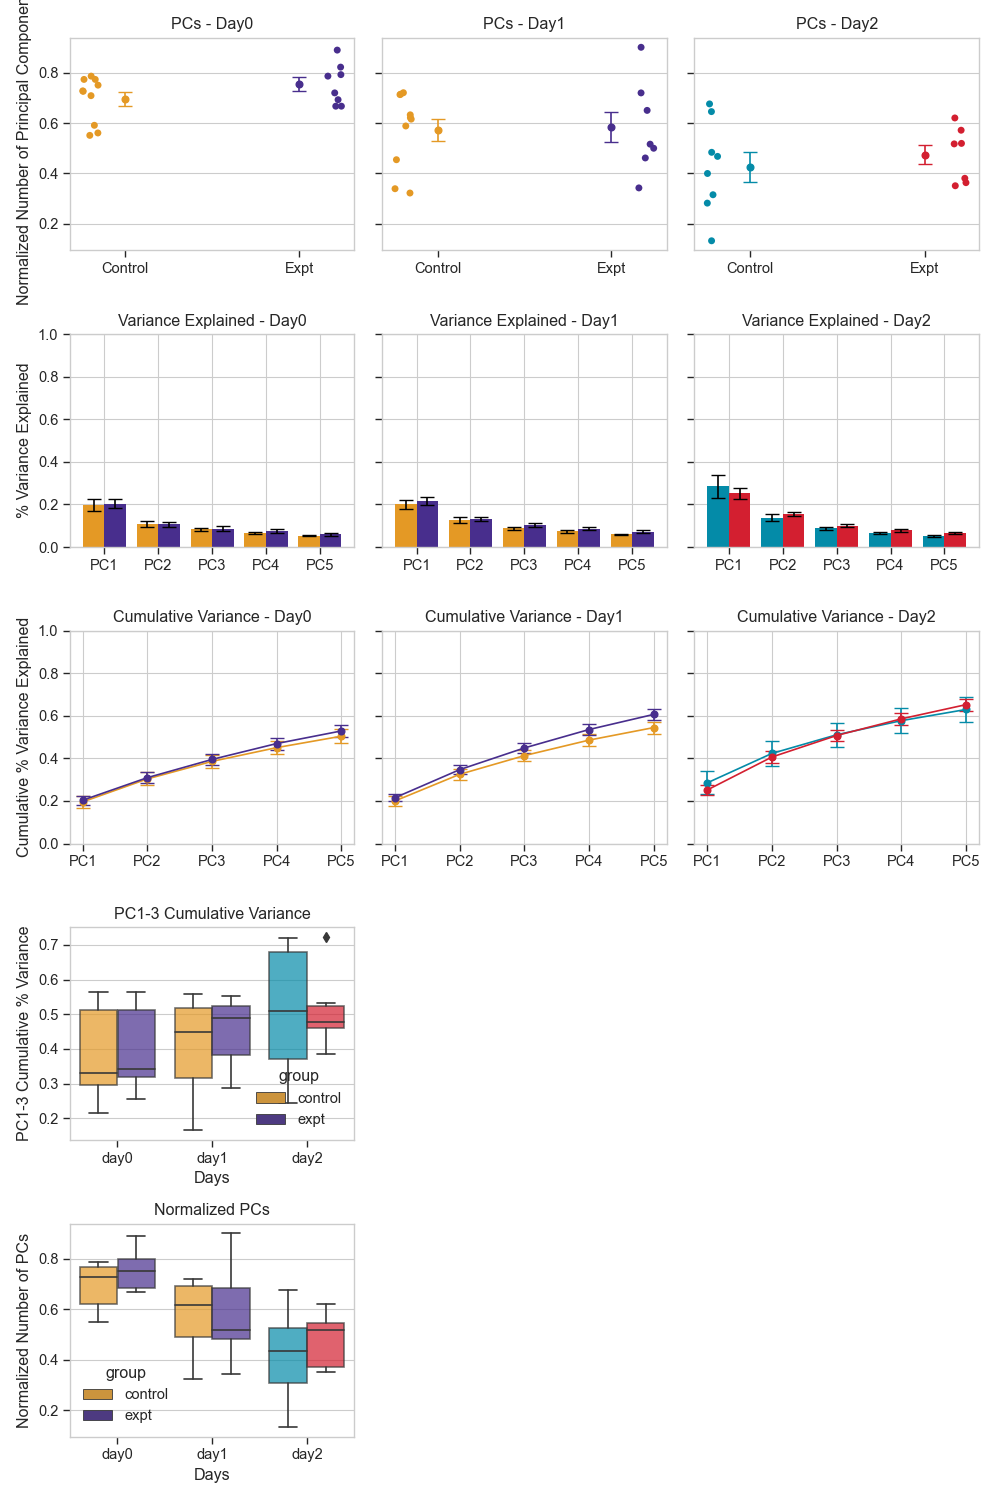

Animal-level data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\pca_over_time_mega_animal_data.csv

Normalized PCs Model:

Model: Normalized PCs ~ Group * Day
                            Coef.  Std.Err.       z     P>|z|  [0.025  0.975]
Intercept                  0.6945    0.0388 17.9034  1.11e-71  0.6185  0.7705
Group[T.expt]              0.0596    0.0413  1.4421    0.1493 -0.0214  0.1406
Day[T.day1]               -0.1224    0.0514 -2.3830    0.0172 -0.2231 -0.0217
Day[T.day2]               -0.2690    0.0472 -5.7037  1.17e-08 -0.3614 -0.1765
Group[T.expt]:Day[T.day1] -0.0474    0.0715 -0.6628    0.5075 -0.1876  0.0928
Group[T.expt]:Day[T.day2] -0.0103    0.0659 -0.1562    0.8759 -0.1394  0.1188
Animal Var                 1.0000       NaN     NaN       nan     NaN     NaN

First 3 PCs Model:

Model: PC1_3Variance ~ Group * Day
                            Coef.  Std.Err.       z      P>|z|  [0.025  0.975]

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\stat

(      Group   Day          Animal  NormalizedPCs  PC1_3Variance
 0   control  day0  control_day0_0       0.750000       0.273345
 1   control  day0  control_day0_1       0.590909       0.490915
 2   control  day0  control_day0_2       0.772727       0.361360
 3   control  day0  control_day0_3       0.772727       0.293627
 4   control  day0  control_day0_4       0.785714       0.565202
 5   control  day0  control_day0_5       0.708333       0.519437
 6   control  day0  control_day0_6       0.725490       0.298406
 7   control  day0  control_day0_7       0.551020       0.544341
 8   control  day0  control_day0_8       0.727273       0.215597
 9   control  day0  control_day0_9       0.560606       0.298464
 10     expt  day0     expt_day0_0       0.821429       0.339609
 11     expt  day0     expt_day0_1       0.666667       0.565068
 12     expt  day0     expt_day0_2       0.791667       0.256116
 13     expt  day0     expt_day0_3       0.888889       0.511933
 14     expt  day0     ex

In [87]:
plot_principal_components(results_pc, variance_explained_results, save_dir=figDataSaveDir + '/imagingInhib_population', filename_prefix='pca_over_time_mega', num_pcs=5)

### PCA centroids

In [59]:
def analyze_pca_centroid_distances(data_silhouette, num_shuffles=1000, Smooth=True, smoothLength=5,
                                   plot_actual_vectors=False, 
                                   plot_group=None, plot_animal=None,  # New parameters
                                   saveDir=None, filename_prefix='PCA_centroid_distances'):
    # Extract control and experiment groups from the single input
    control_group = data_silhouette['control']
    
    # Process control group
    results_control = process_group_centroid_distances(control_group, num_shuffles, group_name="Control", 
                                                       Smooth=Smooth, smoothLength=smoothLength, 
                                                       plot_actual_vectors=plot_actual_vectors,
                                                       plot_group="control", plot_animal=plot_animal,  # Pass through
                                                       saveDir=saveDir, filename_prefix=filename_prefix + '_control')
    
    experiment_group = data_silhouette['expt']
    # Process experimental group
    results_experiment = process_group_centroid_distances(experiment_group, num_shuffles, group_name="Experiment", 
                                                          Smooth=Smooth, smoothLength=smoothLength, 
                                                          plot_actual_vectors=plot_actual_vectors,
                                                          plot_group="expt", plot_animal=plot_animal,  # Pass through
                                                          saveDir=saveDir, filename_prefix=filename_prefix + '_expt')
    
    # Visualize Centroid Plot (averaged across animals)
    plot_mean_centroids(results_control['centroids'], results_experiment['centroids'], saveDir, filename_prefix)

    # Visualize P-Values as Dots
    plot_p_values(results_control['p_values'], results_experiment['p_values'], saveDir, filename_prefix)

    return results_control, results_experiment

def process_group_centroid_distances(group_data, num_shuffles, group_name, Smooth, smoothLength, numPCs=3, 
                                   plot_actual_vectors=False, plot_group=None, plot_animal=None,  # Added parameters
                                   saveDir=None, filename_prefix=None):
    centroids = []
    distances = []
    p_values = []

    for animal_id, animal_data in group_data.items():
        # Process data for each day (assuming we process day2 for example)
        if 'day2' in animal_data:
            session_data = animal_data['day2']
            
            C_final = session_data['C_final']
            cv = session_data['cv']

            # Default smoothing
            if Smooth:
                C_final = smooth_data(C_final, smoothLength)
            
            side_info = session_data.get('partner_side')
            if side_info is None:
                print(f"Warning: No partner side information for {animal_id} on day2")
                continue
            
            partner_event = f'Area:Mouse 1 Center In {side_info.capitalize()} chamber'
            opposite_side = 'Right' if side_info == 'left' else 'Left'
            novel_event = f'Area:Mouse 1 Center In {opposite_side} chamber'

            # Extract PCA projections for each bout, then average across timepoints
            partner_bout_projections, novel_bout_projections = extract_bout_pca_projections(cv, C_final, partner_event, novel_event, numPCs)

            # Only plot if this matches the requested group and animal
            should_plot = plot_actual_vectors and (
                (plot_group is None or plot_group.lower() == group_name.lower()) and
                (plot_animal is None or plot_animal.lower() == animal_id.lower())
            )
            
            if should_plot:
                plot_pca_projection_bouts(partner_bout_projections, novel_bout_projections, group_name, animal_id, saveDir, filename_prefix)

            # Rest of the processing remains the same...
            combined_data = np.vstack((partner_bout_projections, novel_bout_projections))
            labels = np.array(['partner'] * len(partner_bout_projections) + ['novel'] * len(novel_bout_projections))
            combined_data = np.nan_to_num(combined_data)
            partner_centroid = np.nan_to_num(np.mean(partner_bout_projections, axis=0))
            novel_centroid = np.nan_to_num(np.mean(novel_bout_projections, axis=0))
            
            # Ensure centroids don't contain NaN or infinite values
            partner_centroid = np.nan_to_num(partner_centroid)
            novel_centroid = np.nan_to_num(novel_centroid)

            # Calculate the Euclidean distance between centroids
            actual_distance = euclidean(partner_centroid, novel_centroid)

            # Shuffle and compute the shuffled distances
            shuffle_distances = shuffle_labels_and_compute_distances(combined_data, labels, num_shuffles)

            # Calculate p-value based on the rank of actual distance
            p_value = calculate_p_value_for_centroid_distance(actual_distance, shuffle_distances)

            centroids.append((partner_centroid, novel_centroid))
            distances.append(actual_distance)
            p_values.append(p_value)
    
    return {"centroids": centroids, "distances": distances, "p_values": p_values}


def extract_bout_pca_projections(cv, C_final, partner_event, novel_event, numPCs):
    """
    Extracts PCA projections for each bout (partner and novel), averages the projections over 
    timepoints within each bout, and returns these averaged projections.
    """
    partner_bout_projections = []
    novel_bout_projections = []

    # Apply PCA to the entire C_final dataset
    pca = PCA(n_components=numPCs)
    C_final = np.nan_to_num(C_final)
    pca_proj = pca.fit_transform(C_final.T)  # PCA projections over time

    # Partner event processing
    partner_rows = cv[cv['EventType'] == partner_event]
    for _, row in partner_rows.iterrows():
        start_frame = int(row['scopeFrameStart'] // 2)
        end_frame = int(row['scopeFrameEnd'] // 2) - 1
        end_frame = min(end_frame, C_final.shape[1] - 1)  # Ensure end_frame is within bounds
        bout_proj = pca_proj[start_frame:end_frame + 1, :]  # Get the projections for this bout
        avg_proj = np.nan_to_num(np.mean(bout_proj, axis=0))  # Average across timepoints and handle NaNs
        partner_bout_projections.append(avg_proj)

    # Novel event processing
    novel_rows = cv[cv['EventType'] == novel_event]
    for _, row in novel_rows.iterrows():
        start_frame = int(row['scopeFrameStart'] // 2)
        end_frame = int(row['scopeFrameEnd'] // 2) - 1
        end_frame = min(end_frame, C_final.shape[1] - 1)  # Ensure end_frame is within bounds
        bout_proj = pca_proj[start_frame:end_frame + 1, :]  # Get the projections for this bout
        avg_proj = np.nan_to_num(np.mean(bout_proj, axis=0))  # Average across timepoints and handle NaNs
        novel_bout_projections.append(avg_proj)

    return np.array(partner_bout_projections), np.array(novel_bout_projections)

def plot_pca_projection_bouts(partner_bout_projections, novel_bout_projections, group_name, animal_id, saveDir, filename_prefix):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Updated colors
    partner_color = '#000000'  # Black
    novel_color = '#A9A9A9'  # Dark gray
    
    # Scatter plots with updated colors
    ax.scatter(partner_bout_projections[:, 0], partner_bout_projections[:, 1], partner_bout_projections[:, 2],
               color=partner_color, label='Partner', alpha=0.8)
    ax.scatter(novel_bout_projections[:, 0], novel_bout_projections[:, 1], novel_bout_projections[:, 2],
               color=novel_color, label='Stranger', alpha=0.8)
    
    # Set axis labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Updated background color and grid styling (removed deprecated w_xaxis)
    ax.xaxis.pane.set_color((1.0, 1.0, 1.0, 1.0))  # Fully white background
    ax.yaxis.pane.set_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.pane.set_color((1.0, 1.0, 1.0, 1.0))
    
    # Update grid styling
    ax.xaxis._axinfo['grid'].update({'color': '#e0e0e0', 'alpha': 0.01})
    ax.yaxis._axinfo['grid'].update({'color': '#e0e0e0', 'alpha': 0.01})
    ax.zaxis._axinfo['grid'].update({'color': '#e0e0e0', 'alpha': 0.01})
    
    # Updated axis line visibility (removed deprecated w_xaxis)
    ax.xaxis.line.set_alpha(0.5)
    ax.yaxis.line.set_alpha(0.5)
    ax.zaxis.line.set_alpha(0.5)
    
    # Title and legend
    plt.title(f"PCA Projection of Partner and Novel Bouts ({group_name}, Animal {animal_id})")
    plt.legend()
    
    # Save the plot (fixed groupname to group_name)
    if saveDir and filename_prefix:
        save_path = os.path.join(saveDir, f"{filename_prefix}_PCA3d_{group_name.lower()}_{animal_id}")
        plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_path}.svg", format='svg', dpi=300, bbox_inches='tight')
    
    plt.show()

def extract_pca_for_centroids(data, num_pcs=3):
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)
    pca = PCA(n_components=num_pcs)
    pca_data = pca.fit_transform(data_normalized)
    return pca_data

# Helper function to calculate centroids
def calculate_pca_centroids(pca_data, labels):
    partner_points = pca_data[labels == 'partner']
    novel_points = pca_data[labels == 'novel']
    
    partner_centroid = np.mean(partner_points, axis=0)
    novel_centroid = np.mean(novel_points, axis=0)
    
    return partner_centroid, novel_centroid

# Helper function for shuffling and distance calculation
def shuffle_labels_and_compute_distances(pca_data, labels, num_shuffles):
    shuffle_distances = []
    
    for _ in range(num_shuffles):
        # Shuffle labels
        shuffled_labels = np.random.permutation(labels)
        
        # Calculate shuffled centroids
        partner_centroid, novel_centroid = calculate_pca_centroids(pca_data, shuffled_labels)
        
        # Calculate Euclidean distance
        distance = euclidean(partner_centroid, novel_centroid)
        shuffle_distances.append(distance)
    
    return shuffle_distances

# Helper function to compute p-value based on rank
def calculate_p_value_for_centroid_distance(actual_distance, shuffle_distances):
    ranked_distances = np.sort(shuffle_distances)
    rank = np.sum(ranked_distances < actual_distance)
    p_value = rank / len(shuffle_distances)
    return p_value

def plot_mean_centroids(centroids_control, centroids_experiment=None, saveDir=None, filename_prefix=None):
    control_partner_centroids = np.mean([c[0] for c in centroids_control], axis=0)
    control_novel_centroids = np.mean([c[1] for c in centroids_control], axis=0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*control_partner_centroids, color='#048BA8', label='Control Partner')
    ax.scatter(*control_novel_centroids, color='#81E2FF', label='Control Novel')
    ax.plot([control_partner_centroids[0], control_novel_centroids[0]], 
            [control_partner_centroids[1], control_novel_centroids[1]], 
            [control_partner_centroids[2], control_novel_centroids[2]], color='black')

    if centroids_experiment is not None:
        expt_partner_centroids = np.mean([c[0] for c in centroids_experiment], axis=0)
        expt_novel_centroids = np.mean([c[1] for c in centroids_experiment], axis=0)
        
        ax.scatter(*expt_partner_centroids, color='#D31F30', label='Expt Partner')
        ax.scatter(*expt_novel_centroids, color='#FF9999', label='Expt Novel')
        ax.plot([expt_partner_centroids[0], expt_novel_centroids[0]], 
                [expt_partner_centroids[1], expt_novel_centroids[1]], 
                [expt_partner_centroids[2], expt_novel_centroids[2]], color='black')

    plt.title("Mean Centroid Plot (Partner vs Novel)")
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend()
    
    if saveDir and filename_prefix:
        save_path = os.path.join(saveDir, f"{filename_prefix}_mean_centroids")
        plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_path}.svg", format='svg', dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_p_values(p_values_control, p_values_experiment=None, saveDir=None, filename_prefix=None):
    plt.figure(figsize=(8, 6))
    
    # Control group t-test against 0.5
    t_stat_control, p_value_control = stats.ttest_1samp(p_values_control, 0.5)
    n_control = len(p_values_control)
    print(f"\nControl group t-test against 0.5acknowled:")
    print(f"n = {n_control}")
    print(f"t-statistic = {t_stat_control:.3f}")
    print(f"p-value = {p_value_control:.3e}")
    
    # Plot control group
    jitter_control = np.random.normal(0, 0.05, size=len(p_values_control))
    x_control = np.zeros_like(p_values_control)
    plt.scatter(x_control + jitter_control, p_values_control, color='#048BA8', alpha=0.7)
    mean_control = np.mean(p_values_control)
    se_control = np.std(p_values_control) / np.sqrt(len(p_values_control))
    plt.errorbar(0, mean_control, yerr=se_control, fmt='none', color='#048BA8', capsize=5)
    
    if p_values_experiment is not None:
        # Experimental group t-test against 0.5
        t_stat_exp, p_value_exp = stats.ttest_1samp(p_values_experiment, 0.5)
        n_exp = len(p_values_experiment)
        print(f"\nExperimental group t-test against 0.5:")
        print(f"n = {n_exp}")
        print(f"t-statistic = {t_stat_exp:.3f}")
        print(f"p-value = {p_value_exp:.3e}")
        
        # Plot experimental group
        jitter_experiment = np.random.normal(0, 0.05, size=len(p_values_experiment))
        x_experiment = np.ones_like(p_values_experiment)
        plt.scatter(x_experiment + jitter_experiment, p_values_experiment, color='#D31F30', alpha=0.7)
        mean_experiment = np.mean(p_values_experiment)
        se_experiment = np.std(p_values_experiment) / np.sqrt(len(p_values_experiment))
        plt.errorbar(1, mean_experiment, yerr=se_experiment, fmt='none', color='#D31F30', capsize=5)
        plt.xticks([0, 1], ['Control', 'Experiment'])
        plt.xlim(-0.5, 1.5)
    else:
        plt.xticks([0], ['Control'])
        plt.xlim(-0.5, 0.5)
    
    plt.axhline(y=0.05, color='gray', linestyle='--')
    plt.axhline(y=0.95, color='gray', linestyle='--')
    plt.ylim(0, 1.05)
    plt.xlabel('Group')
    plt.ylabel('P-value')
    plt.title('P-values for Control' + (' and Experimental Groups' if p_values_experiment is not None else ' Group'))
    
    plt.grid(False)
    if saveDir and filename_prefix:
        save_path = os.path.join(saveDir, f"{filename_prefix}_p_values")
        plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_path}.svg", format='svg', dpi=300, bbox_inches='tight')
    
    plt.show()


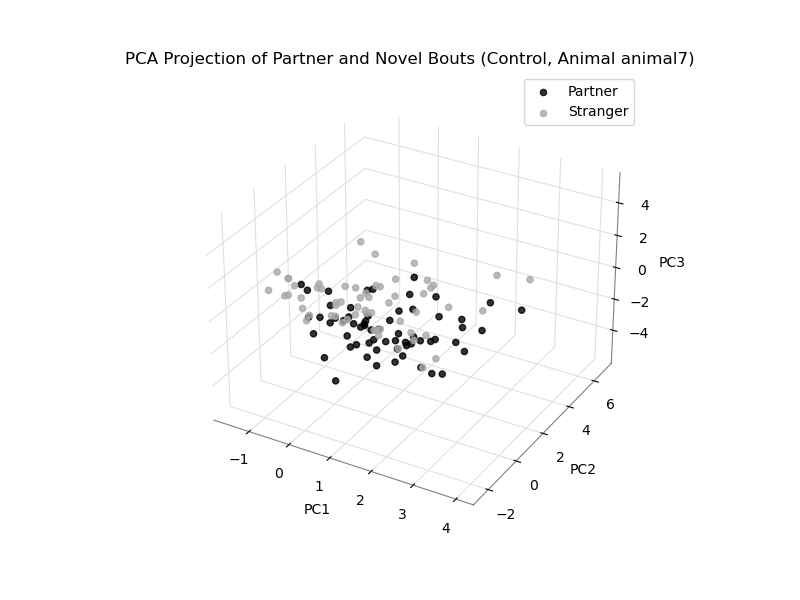

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


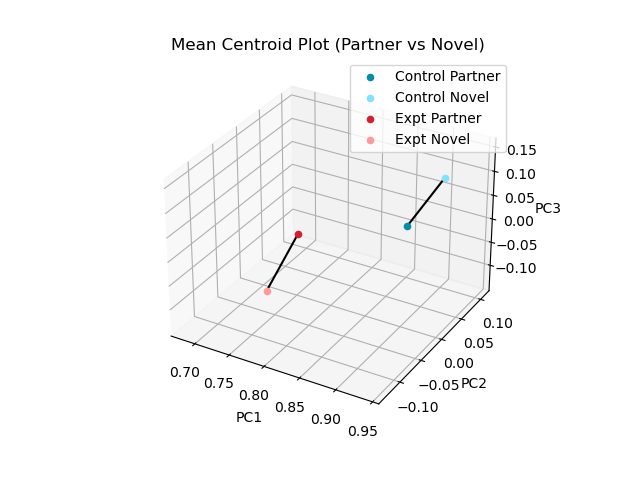


Control group t-test against 0.5acknowled:
n = 8
t-statistic = 1.147
p-value = 2.890e-01

Experimental group t-test against 0.5:
n = 7
t-statistic = 1.657
p-value = 1.486e-01


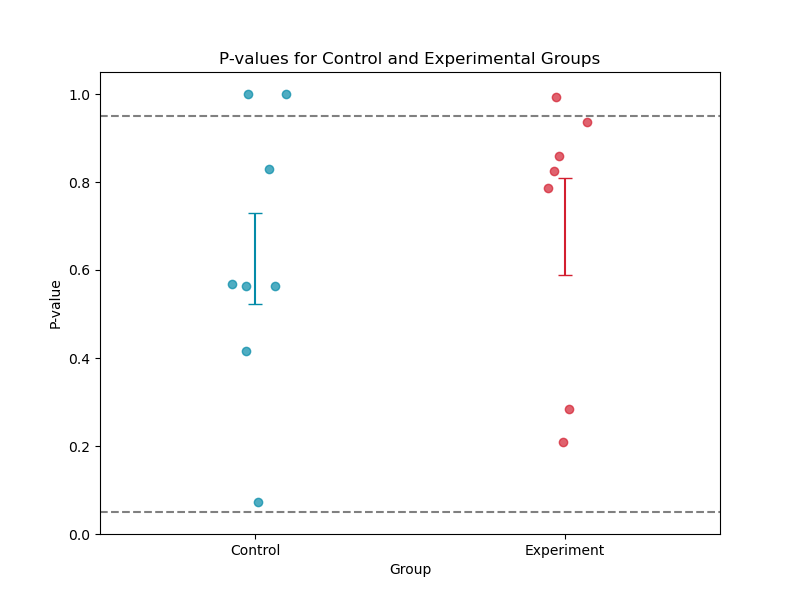

({'centroids': [(array([ 0.65117068, -0.1737565 ,  1.00499395]),
    array([ 0.90547988, -0.47140043,  0.5362863 ])),
   (array([-0.52728113, -0.25466717, -0.1249603 ]),
    array([ 1.00534198, -0.22170758, -0.28742475])),
   (array([ 1.07472345,  0.2905867 , -0.07017039]),
    array([0.98519084, 0.11229423, 0.00508734])),
   (array([-0.47049954,  0.20300097, -0.14612099]),
    array([-0.46463641,  0.0810103 ,  0.09543717])),
   (array([0.86164153, 0.03320446, 0.05384234]),
    array([0.47832731, 0.1004126 , 0.28385985])),
   (array([ 2.14680971, -0.07433474,  0.56478391]),
    array([ 2.23578039, -0.55353173, -0.29296895])),
   (array([ 1.28168405,  0.06360232, -0.50446003]),
    array([0.71946011, 0.39687257, 0.44495835])),
   (array([ 1.9810907 ,  0.36618013, -0.76574115]),
    array([1.6516852 , 0.79299012, 0.39653396]))],
  'distances': [0.6106979118159958,
   1.5415623981086686,
   0.2132323048103321,
   0.27067775413478595,
   0.45205617649615504,
   0.9865523300018616,
   1.152

In [60]:
analyze_pca_centroid_distances(data_groups_d2, 
                             num_shuffles=1000,  
                             plot_actual_vectors=True,
                             plot_group='control',   
                             plot_animal='animal7',   
                             saveDir=figDataSaveDir+'\imagingInhib_population\pca_individual',
                             filename_prefix='PCA_centroid_distances')


### PCA SVM

In [61]:
def SVM_pca_bouts(data_groups, assemblies_data, numShuffles=1000, n_splits=10):
    """
    Performs SVM decoding on PCA-reduced bout-averaged data.
    Assumes social context and day 2 only.
    """
    results = []
    
    for group in ['expt']:
        for animal_id in data_groups[group]:
            if 'day2' not in data_groups[group][animal_id]:
                continue
                
            session_data = data_groups[group][animal_id]['day2']
            C_final = session_data['C_final']
            cv = session_data['cv']
            
            # Get number of assemblies for dimensionality matching
            if animal_id not in assemblies_data[group] or 'day2' not in assemblies_data[group][animal_id]:
                print(f"Skipping animal {animal_id} - no assembly data")
                continue
            num_assemblies = assemblies_data[group][animal_id]['day2']['num_assemblies']

            # Get partner side info
            side_info = session_data.get('partner_side', None)
            if side_info is None:
                print(f"Skipping animal {animal_id} due to missing partner side information.")
                continue
                
            # Generate event vectors for partner and novel separately
            partner_area = 'Left' if side_info == 'left' else 'Right'
            novel_area = 'Right' if side_info == 'left' else 'Left'
            
            # Generate bout averages for partner
            partner_event = f'Area:Mouse 1 Center In {partner_area} chamber'
            partner_labels = generate_labels_from_cv(cv, C_final.shape[1], None, partner_event)
            
            partner_bouts = []
            current_bout = []
            for frame in range(len(partner_labels)):
                if partner_labels[frame] == 1:
                    current_bout.append(frame)
                elif current_bout:
                    partner_bouts.append(current_bout)
                    current_bout = []
            if current_bout:
                partner_bouts.append(current_bout)
                
            partner_averages = []
            for bout in partner_bouts:
                bout_data = C_final[:, bout]
                bout_average = np.mean(bout_data, axis=1)
                partner_averages.append(bout_average)
                
            # Generate bout averages for novel
            novel_event = f'Area:Mouse 1 Center In {novel_area} chamber'
            novel_labels = generate_labels_from_cv(cv, C_final.shape[1], None, novel_event)
            
            novel_bouts = []
            current_bout = []
            for frame in range(len(novel_labels)):
                if novel_labels[frame] == 1:
                    current_bout.append(frame)
                elif current_bout:
                    novel_bouts.append(current_bout)
                    current_bout = []
            if current_bout:
                novel_bouts.append(current_bout)
                
            novel_averages = []
            for bout in novel_bouts:
                bout_data = C_final[:, bout]
                bout_average = np.mean(bout_data, axis=1)
                novel_averages.append(bout_average)
                
            # Stack and convert to arrays
            partner_averages = np.array(partner_averages)
            novel_averages = np.array(novel_averages)
            
            if len(partner_averages) == 0 or len(novel_averages) == 0:
                print(f"Skipping animal {animal_id} - insufficient bout data")
                continue
                
            # Stack all data and create labels
            X = np.vstack((partner_averages, novel_averages))
            y = np.hstack((np.ones(len(partner_averages)), np.zeros(len(novel_averages))))
            
            # Apply PCA
            pca = PCA(n_components=num_assemblies)
            X_pca = pca.fit_transform(X)
            explained_var = pca.explained_variance_ratio_.sum()
            
            # Check if we have enough samples for cross-validation
            if len(partner_averages) < n_splits or len(novel_averages) < n_splits:
                print(f"Skipping animal {animal_id} - insufficient samples for cross-validation")
                continue
                
            # Cross validation
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            f1_scores = []
            
            for train_index, test_index in skf.split(X_pca, y):
                X_train, X_test = X_pca[train_index], X_pca[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                svm = SVC(kernel='linear', random_state=42)
                svm.fit(X_train, y_train)
                
                y_pred = svm.predict(X_test)
                f1_scores.append(f1_score(y_test, y_pred))
            
            avg_f1 = np.mean(f1_scores)
            
            # Null distribution - shift raw data first, then do bout averaging and PCA
            null_f1_scores = []
            for shift in range(numShuffles):
                # Circular shift the raw calcium traces
                shift_amount = np.random.randint(1, C_final.shape[1])
                C_shifted = np.roll(C_final, shift_amount, axis=1)
                
                # Recalculate bout averages on shifted data
                partner_averages_shifted = []
                for bout in partner_bouts:
                    bout_data = C_shifted[:, bout]
                    bout_average = np.mean(bout_data, axis=1)
                    partner_averages_shifted.append(bout_average)
                
                novel_averages_shifted = []
                for bout in novel_bouts:
                    bout_data = C_shifted[:, bout]
                    bout_average = np.mean(bout_data, axis=1)
                    novel_averages_shifted.append(bout_average)
                
                partner_averages_shifted = np.array(partner_averages_shifted)
                novel_averages_shifted = np.array(novel_averages_shifted)
                
                if len(partner_averages_shifted) == 0 or len(novel_averages_shifted) == 0:
                    continue
                
                # Stack shifted data
                X_shifted = np.vstack((partner_averages_shifted, novel_averages_shifted))
                y_shifted = np.hstack((np.ones(len(partner_averages_shifted)), 
                                     np.zeros(len(novel_averages_shifted))))
                
                # Apply PCA to shifted data
                pca_shifted = PCA(n_components=num_assemblies)
                X_shifted_pca = pca_shifted.fit_transform(X_shifted)
                
                # Use the same StratifiedKFold approach for null data
                shift_f1_scores = []
                try:
                    for train_index, test_index in skf.split(X_shifted_pca, y_shifted):
                        X_train_shifted = X_shifted_pca[train_index]
                        X_test_shifted = X_shifted_pca[test_index]
                        y_train_shifted = y_shifted[train_index]
                        y_test_shifted = y_shifted[test_index]
                        
                        svm = SVC(kernel='linear', random_state=42)
                        svm.fit(X_train_shifted, y_train_shifted)
                        
                        y_pred_shifted = svm.predict(X_test_shifted)
                        shift_f1_scores.append(f1_score(y_test_shifted, y_pred_shifted))
                    
                    null_f1_scores.append(np.mean(shift_f1_scores))
                except ValueError:
                    continue
            
            avg_null_f1 = np.mean(null_f1_scores) if null_f1_scores else None
            
            # Store results
            results.append({
                'group': group,
                'animal_id': animal_id,
                'avg_f1': avg_f1,
                'avg_null_f1': avg_null_f1,
                'num_cells': C_final.shape[0],
                'explained_var': explained_var,
                'num_assemblies': num_assemblies,
                'num_partner_bouts': len(partner_averages),
                'num_novel_bouts': len(novel_averages)
            })
            
            print(f"Group: {group}, Animal: {animal_id}, Avg F1: {avg_f1:.4f}, Avg Null F1: {avg_null_f1:.4f}, "
                  f"Explained Var: {explained_var:.4f}, Num Assemblies: {num_assemblies}")
    
    return results

In [62]:
pca_decoding_results = SVM_pca_bouts(data_groups_d2, assemblies_data_day2)

Group: expt, Animal: animal1, Avg F1: 0.6321, Avg Null F1: 0.5504, Explained Var: 0.9334, Num Assemblies: 16
Group: expt, Animal: animal2, Avg F1: 0.6467, Avg Null F1: 0.6073, Explained Var: 0.8070, Num Assemblies: 7
Group: expt, Animal: animal3, Avg F1: 0.6259, Avg Null F1: 0.5890, Explained Var: 0.9165, Num Assemblies: 16
Group: expt, Animal: animal4, Avg F1: 0.8509, Avg Null F1: 0.6520, Explained Var: 0.8689, Num Assemblies: 16
Group: expt, Animal: animal5, Avg F1: 0.7165, Avg Null F1: 0.5317, Explained Var: 0.9290, Num Assemblies: 20
Group: expt, Animal: animal6, Avg F1: 0.3900, Avg Null F1: 0.1179, Explained Var: 0.8340, Num Assemblies: 7
Group: expt, Animal: animal7, Avg F1: 0.4500, Avg Null F1: 0.4499, Explained Var: 0.9479, Num Assemblies: 8


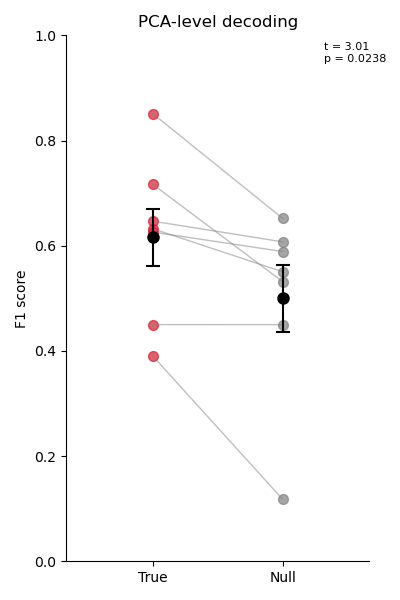

{'true_mean': 0.6160113695827982,
 'true_sem': 0.05443686692203808,
 'null_mean': 0.4997495385566813,
 'null_sem': 0.06302447495676798,
 't_stat': 3.0081244366085134,
 'p_val': 0.023757896220001306}

In [63]:
def plot_pca_decoding_paired(results, saveDir, filename):
    """
    Plot PCA decoding results with paired true and null F1 scores for each animal.
    
    Args:
        results: List of dictionaries with keys 'group', 'animal_id', 'avg_f1', 'avg_null_f1'
        saveDir: Directory to save output files
        filename: Base filename for saved files (without extension)
    """
    # Setup the plot
    plt.figure(figsize=(4, 6))
    
    # Extract experimental group data
    expt_data = [r for r in results if r['group'] == 'expt']
    
    # Get true and null F1 scores
    real_f1s = np.array([r['avg_f1'] for r in expt_data])
    null_f1s = np.array([r['avg_null_f1'] for r in expt_data])
    animal_ids = [r['animal_id'] for r in expt_data]
    
    # Calculate means and SEMs
    real_mean = np.mean(real_f1s)
    real_sem = np.std(real_f1s) / np.sqrt(len(real_f1s))
    null_mean = np.mean(null_f1s)
    null_sem = np.std(null_f1s) / np.sqrt(len(null_f1s))
    
    # Run paired t-test
    t_stat, p_val = stats.ttest_rel(real_f1s, null_f1s)
    
    # Plot paired points for each animal
    x_true = np.ones(len(real_f1s))
    x_null = x_true * 1.3  # Slightly offset
    
    # Plot connecting lines for each animal
    for i in range(len(real_f1s)):
        plt.plot([x_true[i], x_null[i]], [real_f1s[i], null_f1s[i]], 
                 color='gray', alpha=0.5, linestyle='-', linewidth=1)
    
    # Plot individual points
    plt.scatter(x_true, real_f1s, color='#D31F30', alpha=0.7, s=50, label='True F1')
    plt.scatter(x_null, null_f1s, color='gray', alpha=0.7, s=50, label='Null F1')
    
    # Plot means and SEMs
    plt.errorbar(1, real_mean, yerr=real_sem, color='black', capsize=5, 
                capthick=1.5, linewidth=1.5, marker='o', markersize=8)
    plt.errorbar(1.3, null_mean, yerr=null_sem, color='black', capsize=5, 
                capthick=1.5, linewidth=1.5, marker='o', markersize=8)
    
    # Customize the plot
    plt.xlim(0.8, 1.5)
    plt.ylim(0, 1.0)
    plt.ylabel('F1 score')
    plt.title('PCA-level decoding')
    
    # Remove x-axis labels and ticks
    plt.xticks([1, 1.3], ['True', 'Null'])
    
    # Style adjustments
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add statistical test results
    plt.text(0.85, 0.95, f't = {t_stat:.2f}\np = {p_val:.4f}', 
             transform=plt.gca().transAxes, fontsize=8)
    
    plt.tight_layout()
    
    # Create saveDir if it doesn't exist
    os.makedirs(saveDir, exist_ok=True)
    
    # Save plot as SVG and PNG
    svg_path = os.path.join(saveDir, f"{filename}.svg")
    png_path = os.path.join(saveDir, f"{filename}.png")
    plt.savefig(svg_path, format='svg')
    plt.savefig(png_path, format='png', dpi=300)
    
    plt.show()
    
    # Save just the true and null F1 scores for each animal
    csv_path = os.path.join(saveDir, f"{filename}.csv")
    pd.DataFrame({
        'animal_id': animal_ids,
        'true_F1': real_f1s,
        'null_F1': null_f1s
    }).to_csv(csv_path, index=False)
    
    return {
        'true_mean': real_mean,
        'true_sem': real_sem,
        'null_mean': null_mean,
        'null_sem': null_sem,
        't_stat': t_stat,
        'p_val': p_val
    }


plot_pca_decoding_paired(pca_decoding_results, saveDir = figDataSaveDir + '/imagingInhib_population_supp', filename = 'pca_decoding')

### cosine similarity

In [64]:

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def calculate_pairwise_cosine_similarities(vectors1, vectors2=None, return_individual_vectors=False):
    if vectors2 is None:
        vectors2 = vectors1
    
    # Convert to numpy arrays if they're not already
    vectors1 = np.array(vectors1)
    vectors2 = np.array(vectors2)
    
    # Check if vectors are empty
    if vectors1.size == 0 or vectors2.size == 0:
        return np.array([])
    
    # Normalize the vectors
    vectors1_norm = vectors1 / (np.linalg.norm(vectors1, axis=1, keepdims=True) + 1e-8)
    vectors2_norm = vectors2 / (np.linalg.norm(vectors2, axis=1, keepdims=True) + 1e-8)
    
    # Calculate similarities
    similarities = np.dot(vectors1_norm, vectors2_norm.T)
    #similarities = np.dot(vectors1, vectors2.T)
    
    if return_individual_vectors:
        return similarities
    else:
        return similarities.flatten()

def calculate_average_cosine_similarity(vectors1, vectors2=None, return_individual_vectors=False):
    pairwise_similarities = calculate_pairwise_cosine_similarities(vectors1, vectors2, return_individual_vectors)
    
    if return_individual_vectors:
        # For individual vectors, return the average similarity for each vector in vectors1
        return np.mean(pairwise_similarities, axis=1)
    else:
        # For average similarity, return a single average value
        return np.mean(pairwise_similarities) if pairwise_similarities.size > 0 else float('nan')

def calculate_cosine_similarity_day2(data_groups_d2, smoothLength=5, return_individual_vectors=False):
    """
    Calculate intra-partner and intra-novel cosine similarity for day 2 only.
    """
    results = {'control': [], 'expt': []}

    for group in ['control', 'expt']:
        for animal_id in data_groups_d2[group]:
            print(f"Processing {group} - {animal_id}")
            session_data = data_groups_d2[group][animal_id]['day2']
            C_final = session_data['C_final']
            cv = session_data['cv']
            
            # Smooth C_final
            #C_final_smoothed = smooth_data(C_final, smoothLength)

            C_final_smoothed = C_final

            # Retrieve partner side information
            if 'partner_side' not in session_data:
                print(f"Warning: No partner side information for {animal_id}. Skipping...")
                continue

            side_info = session_data['partner_side']
            opposite_side = 'Right' if side_info == 'left' else 'Left'

            # Define event types
            partner_event_type = f'Area:Mouse 1 Center In {side_info.capitalize()} chamber'
            novel_event_type = f'Area:Mouse 1 Center In {opposite_side} chamber'

            # Generate vectors for partner and novel contexts
            partner_vectors = generate_event_vectors(cv, C_final_smoothed, None, partner_event_type, 
                                                     return_individual_vectors=return_individual_vectors)
            novel_vectors = generate_event_vectors(cv, C_final_smoothed, None, novel_event_type, 
                                                   return_individual_vectors=return_individual_vectors)
            
            if not return_individual_vectors:
                partner_vectors, _ = partner_vectors
                novel_vectors, _ = novel_vectors

            # Skip animals with insufficient data
            if partner_vectors.size == 0 or novel_vectors.size == 0:
                print(f"Skipping {group} - {animal_id} due to empty vectors.")
                continue

            # Calculate similarities
            partner_similarity = calculate_average_cosine_similarity(partner_vectors)
            novel_similarity = calculate_average_cosine_similarity(novel_vectors)
            inter_similarity = calculate_average_cosine_similarity(partner_vectors, novel_vectors)
            subtraction_similarity = novel_similarity - partner_similarity

            # Store results
            results[group].append((animal_id, {
                'partner': partner_similarity,
                'novel': novel_similarity,
                'subtraction': subtraction_similarity,
                'inter': inter_similarity
            }))
    
    return results


In [65]:


def plot_distances_day2(results, context='partner', ylabelin='default', saveDir=None, filename_prefix=None):
    """
    Plot cosine similarity for a specified context (partner, novel, inter, or subtraction) for day 2.
    """
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)

    fig, ax = plt.subplots(figsize=(6, 4))

    colors = {
        'control': '#048BA8',
        'expt': '#D31F30',
    }

    control_data = []
    expt_data = []

    # Extract and clean data
    for group in ['control', 'expt']:
        for animal_data in results[group]:
            animal_id, data_dict = animal_data
            value = data_dict.get(context, np.nan)

            if group == 'control':
                control_data.append((animal_id, value))
            else:
                expt_data.append((animal_id, value))

    def clean_data(data):
        return [(animal_id, float(x)) for animal_id, x in data if isinstance(x, (int, float)) and not np.isnan(x) and not np.isinf(x)]

    control_data = clean_data(control_data)
    expt_data = clean_data(expt_data)

    # Plot data points with jitter
    x_jitter = 0.025
    ax.scatter(np.random.normal(0, x_jitter, len(control_data)), [x[1] for x in control_data],
               alpha=0.7, label='Control', color=colors['control'], s=50)
    ax.scatter(np.random.normal(1, x_jitter, len(expt_data)), [x[1] for x in expt_data],
               alpha=0.7, label='Expt', color=colors['expt'], s=50)

    # Plot means and standard errors
    if control_data:
        control_mean = np.mean([x[1] for x in control_data])
        control_se = np.std([x[1] for x in control_data]) / np.sqrt(len(control_data))
        ax.errorbar([0], [control_mean], yerr=[control_se], fmt='none', color=colors['control'], capsize=5)

    if expt_data:
        expt_mean = np.mean([x[1] for x in expt_data])
        expt_se = np.std([x[1] for x in expt_data]) / np.sqrt(len(expt_data))
        ax.errorbar([1], [expt_mean], yerr=[expt_se], fmt='none', color=colors['expt'], capsize=5)

    # Customize plot
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Control', 'Expt'])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylabel(ylabelin if ylabelin != 'default' else 'Similarity', fontweight='bold')
    ax.grid(False)

    # Perform t-test if valid data points exist in both groups
    if control_data and expt_data:
        t_stat, p_value = ttest_ind([x[1] for x in control_data], [x[1] for x in expt_data])
        print(f'{context.capitalize()} Context: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, loc='upper right')

    # Save the plot and data
    if saveDir and filename_prefix:
        os.makedirs(saveDir, exist_ok=True)
        # Save plot
        filename = f"{filename_prefix}_{context}"
        svg_path = os.path.join(saveDir, f"{filename}.svg")
        png_path = os.path.join(saveDir, f"{filename}.png")
        plt.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')
        plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Saved plots to: {svg_path} and {png_path}")

        # Save data to CSV
        csv_path = os.path.join(saveDir, f"{filename}.csv")
        data_to_save = pd.DataFrame({
            'Animal ID': [x[0] for x in control_data + expt_data],
            'Group': ['Control'] * len(control_data) + ['Expt'] * len(expt_data),
            'Value': [x[1] for x in control_data + expt_data]
        })
        data_to_save.to_csv(csv_path, index=False)
        print(f"Saved data to: {csv_path}")

    plt.show()



In [66]:
results_cosine = calculate_cosine_similarity_day2(data_groups_d2, smoothLength=0, return_individual_vectors=False)


Processing control - animal1
Processing control - animal2
Processing control - animal3
Processing control - animal4
Processing control - animal5
Processing control - animal6
Processing control - animal7
Processing control - animal8
Processing expt - animal1
Processing expt - animal2
Processing expt - animal3
Processing expt - animal4
Processing expt - animal5
Processing expt - animal6
Processing expt - animal7


Inter Context: t-statistic = -2.958, p-value = 1.110e-02


C:\Users\ephys\AppData\Local\Temp\ipykernel_28548\102206142.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Saved plots to: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\cosine_partner_vs_novel_day2_inter.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\cosine_partner_vs_novel_day2_inter.png
Saved data to: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_population\cosine_partner_vs_novel_day2_inter.csv


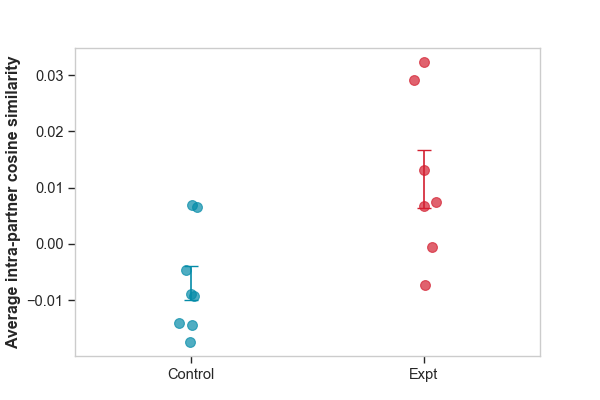

In [67]:
plot_distances_day2(results_cosine, 
                    ylabelin='Average intra-partner cosine similarity',
                    context = 'inter',
                    saveDir=figDataSaveDir + '/imagingInhib_population', 
                    filename_prefix='cosine_partner_vs_novel_day2')
